In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from copy import deepcopy
%matplotlib inline

rs = 42 # Global Random Seed

from kmodes.kprototypes import KPrototypes


# Task 1. Data Preparation for Clustering.

In [2]:
## Read Dataset for Task1
df = pd.read_csv('online_shoppers_intention.csv')

## 1. Can you identify data quality issues in this dataset such as unusual data types, missing values, etc?

The Durations Columns can not be negative. Therefore, we drop the rows that contain negative value in duration columns.

In [3]:
def printColumnInfo(df):
    '''
    Display the information of this Dataframe
    '''
    
    for colName in df.columns:
        print("======================= " + str(colName) + " =======================")
        print("----------------------- FIRST FIVE -----------------------")
        print(df[colName][:5])
        print("----------------------- DESCIRBE -----------------------")
        print(df[colName].describe())
        print("----------------------- COUNTS -----------------------")
        commonList = list(df[colName].value_counts().keys())
        if len(commonList) > 100:
            print("Five Most Common: ", commonList[:5])
        else:
            print("Count List: \n", df[colName].value_counts())
        print("Num of NULL: ", df[colName].isnull().sum())

printColumnInfo(df)

======================= Administrative =======================
----------------------- FIRST FIVE -----------------------
0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: Administrative, dtype: float64
----------------------- DESCIRBE -----------------------
count    12316.000000
mean         2.317798
std          3.322754
min          0.000000
25%          0.000000
50%          1.000000
75%          4.000000
max         27.000000
Name: Administrative, dtype: float64
----------------------- COUNTS -----------------------
Count List: 
 0.0     5754
1.0     1354
2.0     1114
3.0      915
4.0      765
5.0      575
6.0      432
7.0      338
8.0      287
9.0      225
10.0     153
11.0     105
12.0      86
13.0      56
14.0      44
15.0      38
16.0      24
17.0      16
18.0      12
19.0       6
24.0       4
22.0       4
23.0       3
20.0       2
21.0       2
26.0       1
27.0       1
Name: Administrative, dtype: int64
Num of NULL:  14
======================= Administrative_Duration ======

In [4]:
# The columns that have null values

durationCols= [  
  'Administrative_Duration',
  'Informational_Duration',
  'ProductRelated_Duration',]

In [5]:
# Removing the rows with negative duration
for colName in durationCols:
    print('Number of Negative Values: ', len(df[df[colName]<0]) )
    df = df[df[colName]>=0] 

Number of Negative Values:  33
Number of Negative Values:  0
Number of Negative Values:  0


After Removing the the negative value, the dataframe doens't contain the NULL now.

In [6]:
df.isnull().sum() # No null value

Administrative             0
Administrative_Duration    0
Informational              0
Informational_Duration     0
ProductRelated             0
ProductRelated_Duration    0
BounceRates                0
ExitRates                  0
PageValues                 0
SpecialDay                 0
Month                      0
OperatingSystems           0
Browser                    0
Region                     0
TrafficType                0
VisitorType                0
Weekend                    0
Revenue                    0
dtype: int64

// TODO: Change it after deciding the features included

Measurement Level and vriable roles:
1. Administrative -> Interval (Input)
2. Administrative_Duration -> Ratio (Input)
3. Informational -> Interval (Input)
4. Informational_Duration -> Ratio (Input)
5. ProductRelated -> Interval (Input)
6. ProductRelated_Duration -> Ratio (Input)
7. BounceRates -> Ratio (Input)
8. ExitRates -> Ratio (Input)
9. PageValues -> Ratio (Input)
10. SpecialDay -> Ratio (Input)
11. Month -> Nominal (Input)
12. OperatingSystems -> Nominal (Input)
13. Browser -> Nominal (Input)
14. Region -> Nominal (Input)
15. TrafficType -> Nominal (Input)
16. VisitorType -> Nominal (Input)
17. Weekend -> Binary (Input)
18. Revenue -> Binary (Input) - // TODO: This may be the target?

In [7]:
print("Number of observations: ", len(df))

Number of observations:  12283


In [8]:
# This function can help in pre-processing and plotting
def seperateDfToNumAndCat(df):
    Cat = []
    Num = []
    for colName in df.columns:
        if (df[colName].dtype == np.float):
            Num.append(colName)
        else:
            Cat.append(colName)
            
    return {
        'Cat':Cat,
        'Num':Num
    }
seperateDfToNumAndCat(df)

{'Cat': ['Month',
  'OperatingSystems',
  'Browser',
  'Region',
  'TrafficType',
  'VisitorType',
  'Weekend',
  'Revenue'],
 'Num': ['Administrative',
  'Administrative_Duration',
  'Informational',
  'Informational_Duration',
  'ProductRelated',
  'ProductRelated_Duration',
  'BounceRates',
  'ExitRates',
  'PageValues',
  'SpecialDay']}

=================== Administrative ===================


=================== Administrative_Duration ===================


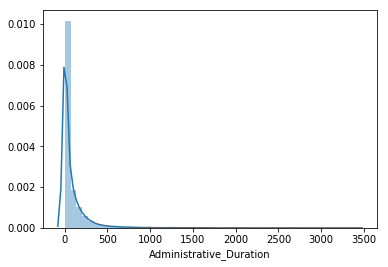

=================== Informational ===================


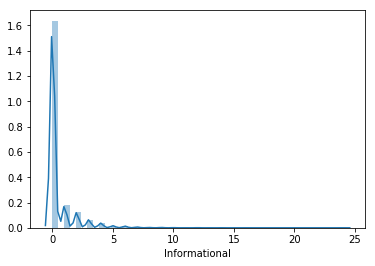

=================== Informational_Duration ===================


=================== ProductRelated ===================


=================== ProductRelated_Duration ===================


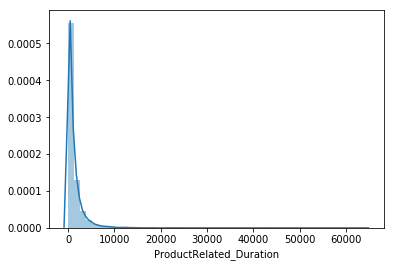

=================== BounceRates ===================


=================== ExitRates ===================


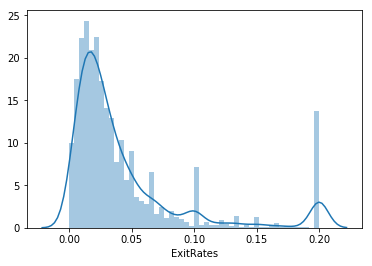

=================== PageValues ===================


=================== SpecialDay ===================


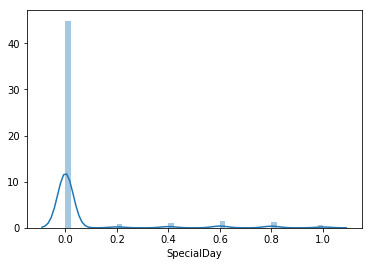

=================== Month ===================


=================== OperatingSystems ===================


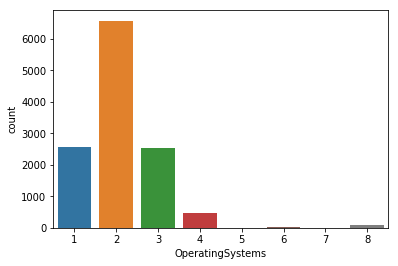

=================== Browser ===================


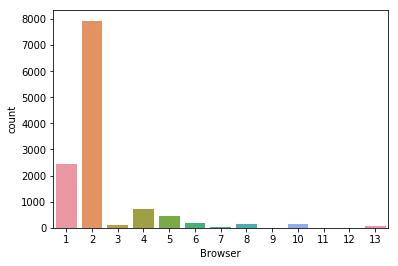

=================== Region ===================


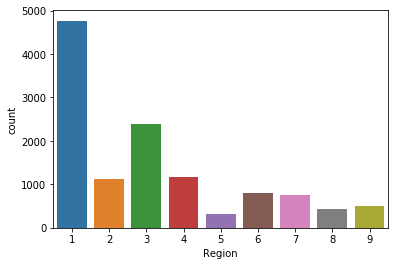

=================== TrafficType ===================


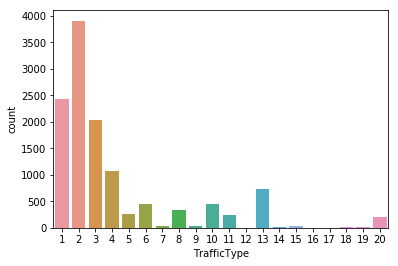

=================== VisitorType ===================


=================== Weekend ===================


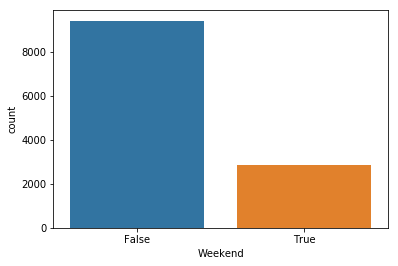

=================== Revenue ===================


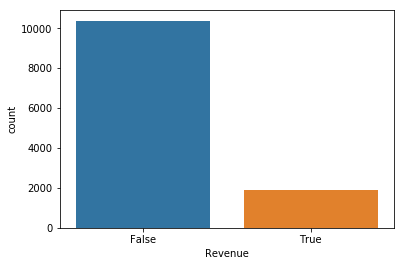

In [9]:
def plotingAllCols(df, colTypes):
    
    for colName in df.columns:
        print('===================',colName,'===================')
        if (colName in colTypes['Num']):
            sns.distplot(df[colName])
        elif (colName in colTypes['Cat']):
            sns.countplot(df[colName])
        else:
            raise ValueError
        plt.show()
plotingAllCols(df, seperateDfToNumAndCat(df))

In [10]:
# If we have the null value in the dataset, we can use this function to fill the null
# But we simply use this function for determining the dataframe column data type since we don't have the null value now

from copy import deepcopy

def preprocessTheNullValue(df_input, colTypes):
    df = deepcopy(df_input)
    for colName in df.columns:
        ## Dealing with the Numerical first
        if (colName in colTypes['Num']):
            df[colName] = df[colName].astype('float')
            if (df[colName].isnull().sum() > 0):
                df[colName] = df[colName].fillna(df[colName].mean())
        
        ## Dealing with the Categorial
        
        elif (colName in colTypes['Cat']):
            df[colName] = df[colName].astype('category')
            if (df[colName].isnull().sum() > 0):
                df[colName] = df[colName].fillna(df[colName].describe()['top'])

    return df

df = preprocessTheNullValue(df, seperateDfToNumAndCat(df))


# Task 2. The first clustering model

### What variables did you include in the analysis and what were their roles and measurement level set? Justify your choice. Answer this question for each of the tasks 2 and 3.

A: Since the requirement is to profile the customers through their time spending behaviour, we decide to pick the time-related attributes as the input of the clustering model, including 'Administrative','Administrative_Duration', 'Informational', 'Informational_Duration', 'ProductRelated' and 'ProductRelated_Duration'. 

In [11]:
taskOneCols = [  
  'Administrative_Duration',
  'Informational_Duration',
  'ProductRelated_Duration',]

taskTwoDf = df[taskOneCols]

Measurement Level and vriable roles:
1. Administrative -> Interval (Input)
2. Administrative_Duration -> Ratio (Input)
3. Informational -> Interval (Input)
4. Informational_Duration -> Ratio (Input)
5. ProductRelated -> Interval (Input)
6. ProductRelated_Duration -> Ratio (Input)

No Target for this clustering model

## 1. Build a clustering model to profile the customers based on the time they spend onthe website. Answer the followings:

### a. What is the optimal number of clusters? 

In [12]:
def getFitModel(model, data, cat):
    
    if isinstance(model, KPrototypes):
        model.fit(data, categorical = cat)
    elif isinstance(model, KMeans):
        model.fit(data)
    else:
        raise ValueError('Do not support this model')
        
        
def getCost(model):
    
    if isinstance(model, KPrototypes):
        return model.cost_
    elif isinstance(model, KMeans):
        return model.inertia_
    else:
        raise ValueError('Do not support this model')
        
        
def getPrediction(model, data, cat=None):
    
    if isinstance(model, KPrototypes):
        return model.predict(data, cat)
    elif isinstance(model, KMeans):
        return model.predict(data)
    else:
        raise ValueError('Do not support this model')
        
def getCentroid(model):
    
    if isinstance(model, KPrototypes):
        return model.cluster_centroids_[0]
    elif isinstance(model, KMeans):
        return model.cluster_centers_
    else: 
        raise ValueError('Do not support this model')
    
    

In [13]:
def ElbowEffectAndSilhouetteScore(data, kRunRange):
    
    clusters = []
    inertial_vals = []
    silhouette_scores = []
    
    for i in kRunRange:
        model = KMeans(n_clusters=i, random_state=rs, n_jobs=10)
        model.fit(data)
        clusters.append(model)
        inertial_vals.append(model.inertia_)
        silhouette_scores.append(silhouette_score(data, model.predict(data)))
    
    
    fig = plt.figure(figsize=(20,10))
    plt.subplot(211)
    plt.plot(kRunRange, inertial_vals, marker='o', label='Inertial_vals')
    plt.ylabel('Inertial_vals', fontsize=22)
    plt.xlabel('Number of clusters', fontsize=22)    
    
    plt.subplot(212)
    plt.plot(kRunRange, silhouette_scores, marker='o', label="silhouette_scores")
    plt.ylabel('Silhouette_scores', fontsize=22)
    plt.xlabel('Number of clusters', fontsize=22)
    
    plt.tight_layout()
    plt.show()
    
    return clusters




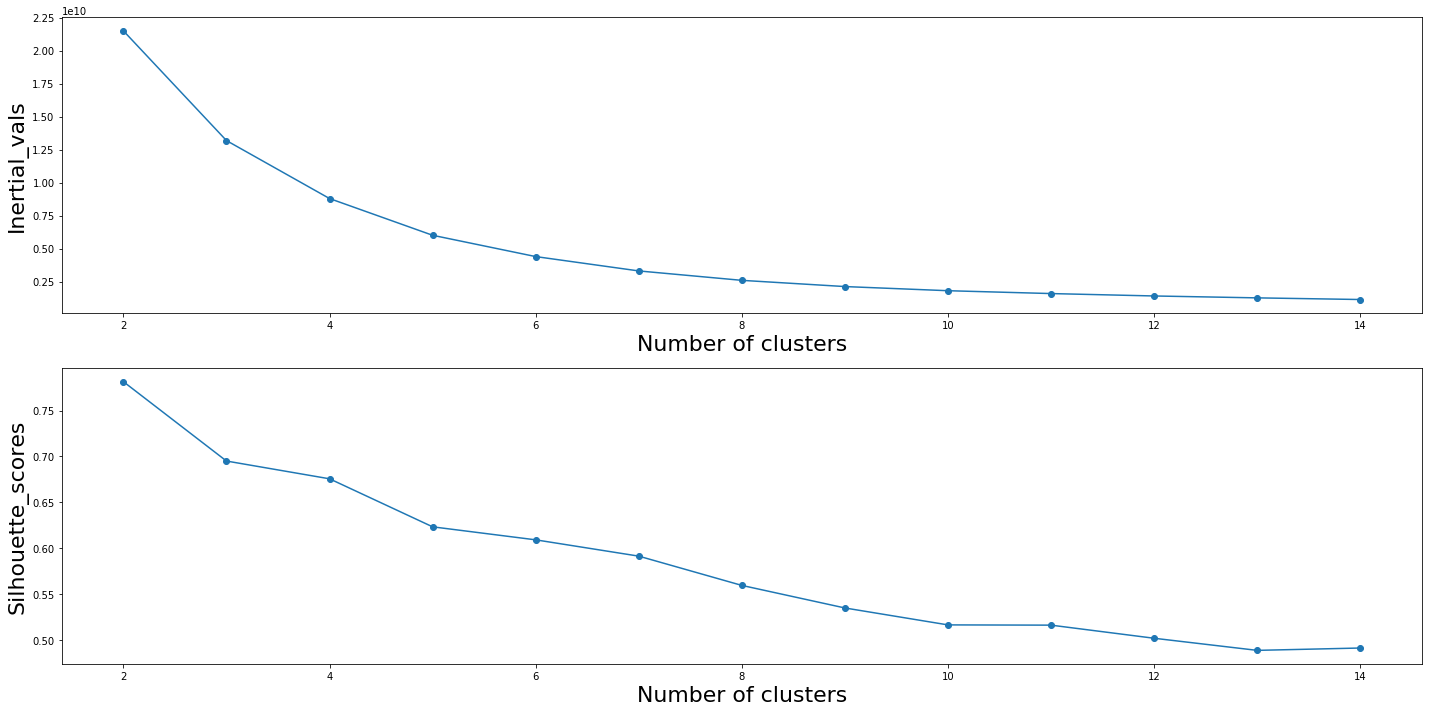

In [14]:
clusters = ElbowEffectAndSilhouetteScore(taskTwoDf, range(2,15,1))

From the plot of Elbow Effect we can find the k=3 or k=4 may be the best option of number of clusters. Then we have a look of the silhouette scores, we found out the k=3 has a slightly higher score. Therefore, we determine the number of clusters is 3.


### b. For the model with the optimal number of clusters, list the variables that were found important in determining the clusters?


Best Model Clusters k = 3
Value counts: 
 Cluster_0    10101
Cluster_1     1975
Cluster_2      207
Name: Cluster_ID, dtype: int64


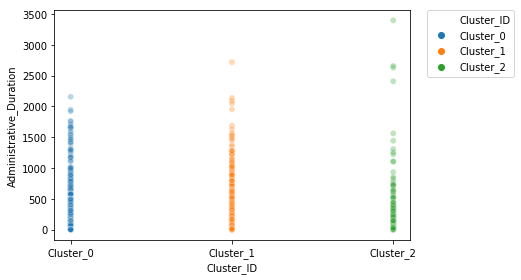

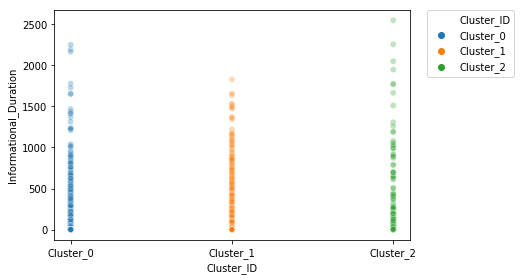

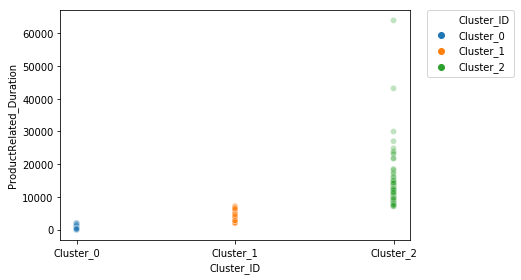

In [15]:
print("Best Model Clusters k =",clusters[1].n_clusters)


def pairplotVisualization(df, model):
    df_WithID = deepcopy(df)
    df_WithID['Cluster_ID'] = model.predict(df)
   
    sorted_countDict = sorted(dict(df_WithID['Cluster_ID'].value_counts()).items(), key=lambda item: item[1])
    for index, i in  enumerate(reversed(sorted_countDict)):
        df_WithID['Cluster_ID'].replace(i[0],"Cluster_" + str(index),inplace=True)
    
    print('Value counts: \n',df_WithID['Cluster_ID'].value_counts())
    for colName in df.columns:
        sns.scatterplot(x='Cluster_ID', y=colName, data=df_WithID, hue='Cluster_ID', alpha=0.3)
        plt.tight_layout()
        plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
        plt.show()



pairplotVisualization(taskTwoDf ,clusters[1])

In [16]:
def calculateFeatureDifference(centers):
    
    numClusters, numFeatures = centers.shape
    
    dif = []
    
    for i in range(numFeatures):
        feature_dif = 0
        for j in range(numClusters):
            for k in range(j+1, numClusters):
                feature_dif+= abs(centers[j, i] - centers[k,i])
        dif.append(feature_dif)
        
    return dif

calculateFeatureDifference(clusters[1].cluster_centers_)

[466.0985735326164, 493.3365836192419, 20613.91886108766]

From the visualization and the calculateFeatureDifferenc function, we found the 3rd feature (ProductRelated_Duration) is the most informative feature in this cluster model since it can appropriately seperate the three different cluster. Moreover, the 3 clusters centroids has the largest difference on the 3rd dimension (ProductRelated_Duration). Therefore, ProductRelated_Duration is the most important in determining the clusters.
  

### c. Explain the cluster results.

In [17]:
# Display the label of the clusters
count_dict = dict(pd.DataFrame(clusters[1].labels_)[0].value_counts())

In [18]:
# Since the result may vary everytime, we wrote a function to display it.

def displayClusterResult(model):
    count_dict = dict(pd.DataFrame(model.labels_)[0].value_counts())
    sorted_countDict = sorted(count_dict.items(), key=lambda item: item[1])
    k = model.n_clusters
    clusterCenter = getCentroid(model)
    
    print("The k =",k,"clustering model seperate all the observations to",k ,"clusters. Cluster",
        sorted_countDict[-1][0], "is the largest cluster, which consists of ",
        sorted_countDict[-1][1],
        "objects. And the the Cluster", sorted_countDict[0][0],
        "is the samllest cluster, which only own ",
        sorted_countDict[0][1],
        'objects. The Sum of squared distance of objects to their closest centroids is ',
        getCost(model),'. Moreover, to get this result, the model runs',
        model.n_iter_,'iteration.\nCentriods:\n',clusterCenter)

In [19]:
displayClusterResult(clusters[1])

The k = 3 clustering model seperate all the observations to 3 clusters. Cluster 2 is the largest cluster, which consists of  10101 objects. And the the Cluster 1 is the samllest cluster, which only own  207 objects. The Sum of squared distance of objects to their closest centroids is  13185315708.802977 . Moreover, to get this result, the model runs 29 iteration.
Centriods:
 [[  154.87747813    84.67261984  3355.10746367]
 [  295.36489079   266.72309447 10886.17436548]
 [   62.31560402    20.05480266   579.21493494]]


## 2. What is the effect of using the standardization method on the model above? Does the variable normalization process enable a better clustering solution?

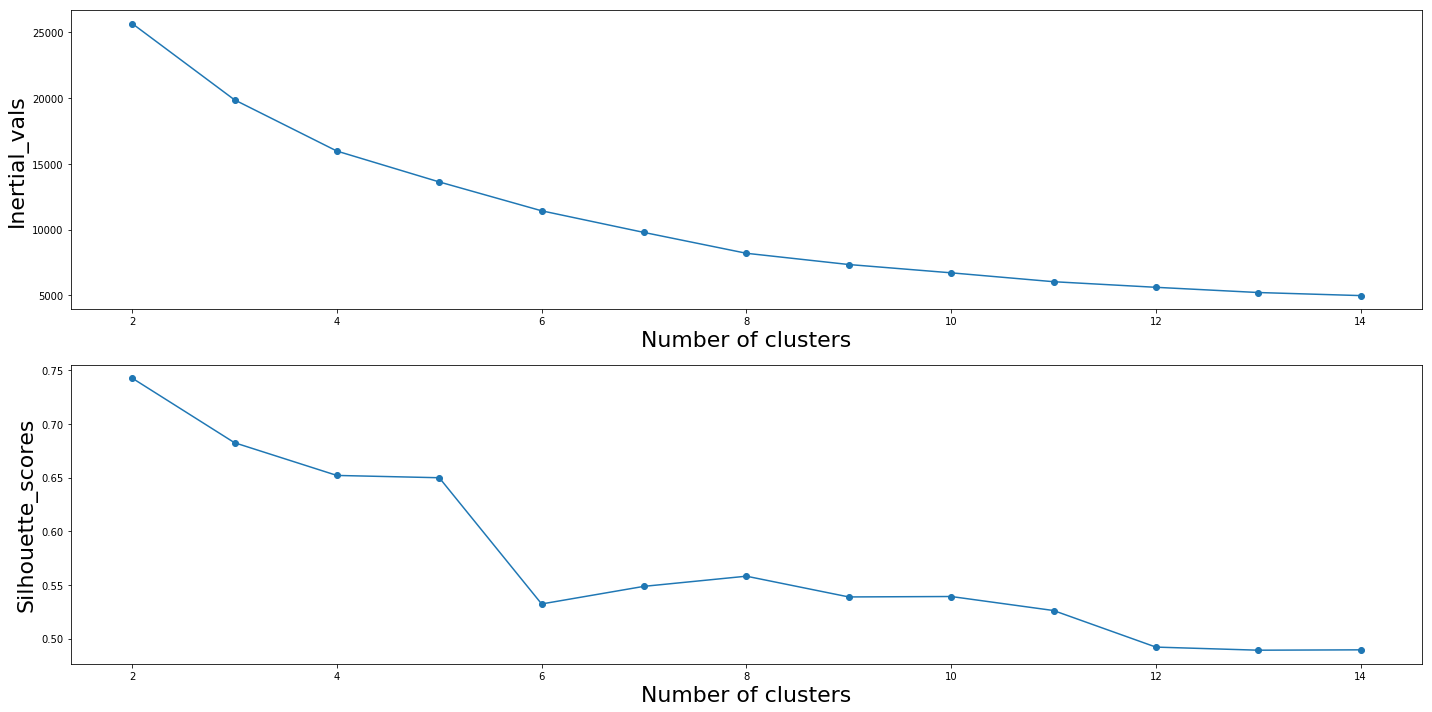

In [20]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
taskTwoDf_Standardised = scaler.fit_transform(taskTwoDf)
taskTwoDf_Standardised = pd.DataFrame(taskTwoDf_Standardised, columns= taskTwoDf.columns)

clusters_Standardised = ElbowEffectAndSilhouetteScore(taskTwoDf_Standardised, range(2,15,1))

From the Elbow Effect, we can find that the stadardised clusters have more gradual decline curve than the original one, which means the number of clusters doesn't have a strong impact as the original model. Moreover, the silhouette scores also show a differnet curve in the standardised model. These factors may affect the decision of k.

Value counts: 
 Cluster_0    10902
Cluster_1     1194
Cluster_2      187
Name: Cluster_ID, dtype: int64


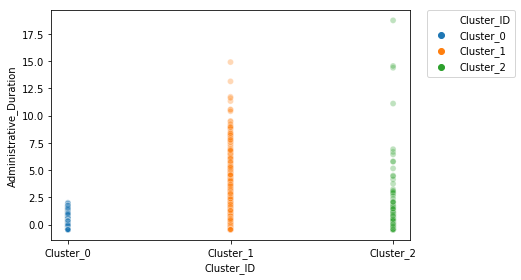

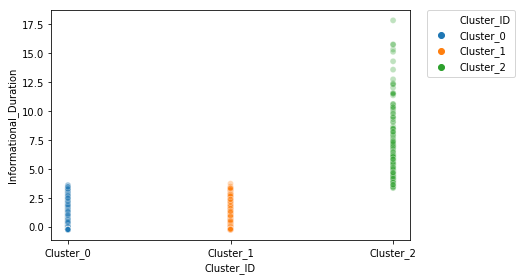

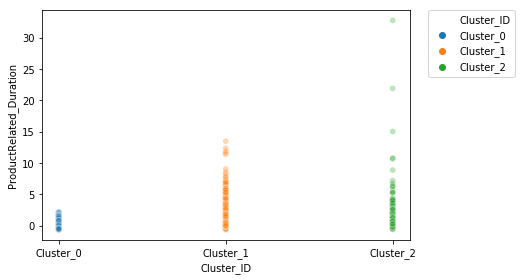

In [21]:
# If we still the k = 3
pairplotVisualization(taskTwoDf_Standardised, clusters_Standardised[1])

From the pairplot visualization, we can see the distribution of each cluster become different. In this model, we can seperate the objects easily in all the features, except the cluster 0 and cluster 1 in informational_Duration feature. In this model, each cluster has a strong character and unique distribution. Therefore, the standardised input results in a better solution in this case.

In [22]:
calculateFeatureDifference(clusters_Standardised[1].cluster_centers_)

[4.004705793981389, 13.373080638205202, 4.0830708223043874]

The standardised model also different from the original in the distance of centroids. The original model has the largest distance in the ProductRelated_Duration feature. However, the standardised has the largest distance in the Informational_Duration.

In [23]:
displayClusterResult(clusters_Standardised[1])

The k = 3 clustering model seperate all the observations to 3 clusters. Cluster 1 is the largest cluster, which consists of  10902 objects. And the the Cluster 2 is the samllest cluster, which only own  187 objects. The Sum of squared distance of objects to their closest centroids is  19875.616386269867 . Moreover, to get this result, the model runs 18 iteration.
Centriods:
 [[ 1.78843011  0.3419077   1.58146492]
 [-0.21392278 -0.14957353 -0.20471064]
 [ 1.05240988  6.53696679  1.83682478]]


## 3. Interpret the cluster analysis outcome. In other words, characterize the nature of each cluster by giving it a descriptive label and a brief description. 

// The Question 3 is based on the result of Q2 or Q1?

3. Interpret the cluster analysis outcome. In other words, characterize the nature of
each cluster by giving it a descriptive label and a brief description. 

Value counts: 
 Cluster_0    10101
Cluster_1     1975
Cluster_2      207
Name: Cluster_ID, dtype: int64


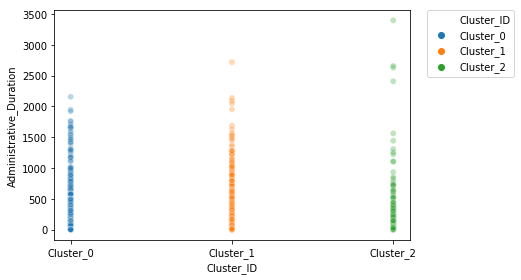

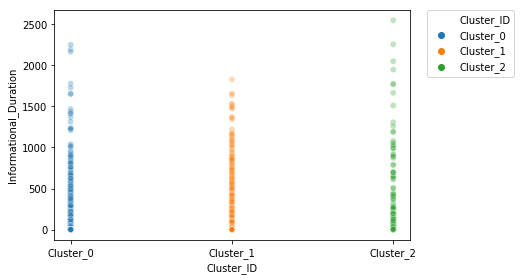

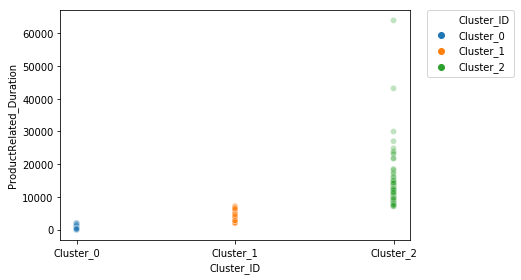

In [24]:
pairplotVisualization( taskTwoDf,clusters[1])

Cluster_1 (Blue): This cluster consist of the most of the observations. Number of objects in this cluster is 10138. This cluster has a Informational_Duration. And, the feature of this cluter is the least ProductRelated_Duration. The Administrative_Duration feature in this cluster is compact, most of the instances are in the range of 0 to 2000.


Cluster_2 (Green): This cluster is the second large group, which has 1973 objects. It has the wider range that Cluster_1 in Administrative_Duration. However, most of the objects is still in the range of 0 to 2000. In terms of the Informational_Duration, this cluster has the least value and samllest range. Moreover, this cluster also has a small value of ProductRelated_Duration but slightly larger than Cluster_1.


Cluster_3 (Red): This cluster has the smallest group, which consist of only 205 objects. This cluster has the widest range and highest value in all the three features. In the Administrative_Duration, even this cluster has the widest range, most of the instances exist in the range of 0 to 1500.


# Task 3. Refining the clustering model 

## 1. Add more information such as where the users come from and when they access the website, to the clustering analysis that you have conducted in the previous task. Answer the followings:

### What variables did you include in the analysis and what were their roles and measurement level set? Justify your choice. Answer this question for each of the tasks 2 and 3.

// TODO: check if we want to include all the info or not

Answer: We found all the feature can be informative; therefore, we decide to include all the features for this clustering task.

In [25]:
taskThreeDf = deepcopy(df)
taskThreeDf = pd.get_dummies(taskThreeDf)

// TODO: Change it after deciding the features included

Measurement Level and vriable roles:
1. Administrative -> Interval (Input)
2. Administrative_Duration -> Ratio (Input)
3. Informational -> Interval (Input)
4. Informational_Duration -> Ratio (Input)
5. ProductRelated -> Interval (Input)
6. ProductRelated_Duration -> Ratio (Input)
7. BounceRates -> Ratio (Input)
8. ExitRates -> Ratio (Input)
9. PageValues -> Ratio (Input)
10. SpecialDay -> Ratio (Input)
11. Month -> Nominal (Input)
12. OperatingSystems -> Nominal (Input)
13. Browser -> Nominal (Input)
14. Region -> Nominal (Input)
15. TrafficType -> Nominal (Input)
16. VisitorType -> Nominal (Input)
17. Weekend -> Binary (Input)
18. Revenue -> Binary (Input) - This may be the target?

In [26]:
print('All',len(taskThreeDf.columns),'Features:\n', list(taskThreeDf.columns))

All 77 Features:
 ['Administrative', 'Administrative_Duration', 'Informational', 'Informational_Duration', 'ProductRelated', 'ProductRelated_Duration', 'BounceRates', 'ExitRates', 'PageValues', 'SpecialDay', 'Month_Aug', 'Month_Dec', 'Month_Feb', 'Month_Jul', 'Month_June', 'Month_Mar', 'Month_May', 'Month_Nov', 'Month_Oct', 'Month_Sep', 'OperatingSystems_1', 'OperatingSystems_2', 'OperatingSystems_3', 'OperatingSystems_4', 'OperatingSystems_5', 'OperatingSystems_6', 'OperatingSystems_7', 'OperatingSystems_8', 'Browser_1', 'Browser_2', 'Browser_3', 'Browser_4', 'Browser_5', 'Browser_6', 'Browser_7', 'Browser_8', 'Browser_9', 'Browser_10', 'Browser_11', 'Browser_12', 'Browser_13', 'Region_1', 'Region_2', 'Region_3', 'Region_4', 'Region_5', 'Region_6', 'Region_7', 'Region_8', 'Region_9', 'TrafficType_1', 'TrafficType_2', 'TrafficType_3', 'TrafficType_4', 'TrafficType_5', 'TrafficType_6', 'TrafficType_7', 'TrafficType_8', 'TrafficType_9', 'TrafficType_10', 'TrafficType_11', 'TrafficType_12

### a. What is the optimal number of clusters? 

In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12283 entries, 0 to 12329
Data columns (total 18 columns):
Administrative             12283 non-null float64
Administrative_Duration    12283 non-null float64
Informational              12283 non-null float64
Informational_Duration     12283 non-null float64
ProductRelated             12283 non-null float64
ProductRelated_Duration    12283 non-null float64
BounceRates                12283 non-null float64
ExitRates                  12283 non-null float64
PageValues                 12283 non-null float64
SpecialDay                 12283 non-null float64
Month                      12283 non-null category
OperatingSystems           12283 non-null category
Browser                    12283 non-null category
Region                     12283 non-null category
TrafficType                12283 non-null category
VisitorType                12283 non-null category
Weekend                    12283 non-null category
Revenue                    12283 n

In [28]:
taskThreeDf.columns

Index(['Administrative', 'Administrative_Duration', 'Informational',
       'Informational_Duration', 'ProductRelated', 'ProductRelated_Duration',
       'BounceRates', 'ExitRates', 'PageValues', 'SpecialDay', 'Month_Aug',
       'Month_Dec', 'Month_Feb', 'Month_Jul', 'Month_June', 'Month_Mar',
       'Month_May', 'Month_Nov', 'Month_Oct', 'Month_Sep',
       'OperatingSystems_1', 'OperatingSystems_2', 'OperatingSystems_3',
       'OperatingSystems_4', 'OperatingSystems_5', 'OperatingSystems_6',
       'OperatingSystems_7', 'OperatingSystems_8', 'Browser_1', 'Browser_2',
       'Browser_3', 'Browser_4', 'Browser_5', 'Browser_6', 'Browser_7',
       'Browser_8', 'Browser_9', 'Browser_10', 'Browser_11', 'Browser_12',
       'Browser_13', 'Region_1', 'Region_2', 'Region_3', 'Region_4',
       'Region_5', 'Region_6', 'Region_7', 'Region_8', 'Region_9',
       'TrafficType_1', 'TrafficType_2', 'TrafficType_3', 'TrafficType_4',
       'TrafficType_5', 'TrafficType_6', 'TrafficType_7', 'Traff

In [65]:
def ElbowEffectAndSilhouetteScoreKprototype(data, kRunRange):
    '''
    Use KPropotype
    '''
    clusters = []
    inertial_vals = []
    silhouette_scores = []
    
    cat_cols = [  i for i, colName in enumerate(data.columns) if not data[colName].dtype == np.float]
    
    print('Current Categorial columns:', cat_cols)
    
    for i in kRunRange:
        print('Doing k = ' + str(i))
        model = KPrototypes(n_clusters=i, random_state=rs, init='Huang')
        model.fit(data, categorical=cat_cols)
        clusters.append(model)
        inertial_vals.append(model.cost_)
        silhouette_scores.append(silhouette_score(data, model.predict(data, cat_cols)))
    
    
    fig = plt.figure(figsize=(20,10))
    plt.subplot(211)
    plt.plot(kRunRange, inertial_vals, marker='o', label='Inertial_vals')
    plt.ylabel('Inertial_vals', fontsize=22)
    plt.xlabel('Number of clusters', fontsize=22)    
    
    plt.subplot(212)
    plt.plot(kRunRange, silhouette_scores, marker='o', label="silhouette_scores")
    plt.ylabel('Silhouette_scores', fontsize=22)
    plt.xlabel('Number of clusters', fontsize=22)
    
    plt.tight_layout()
    plt.show()
    return clusters




Doing k = 2
Doing k = 3
Doing k = 4
Doing k = 5
Doing k = 6


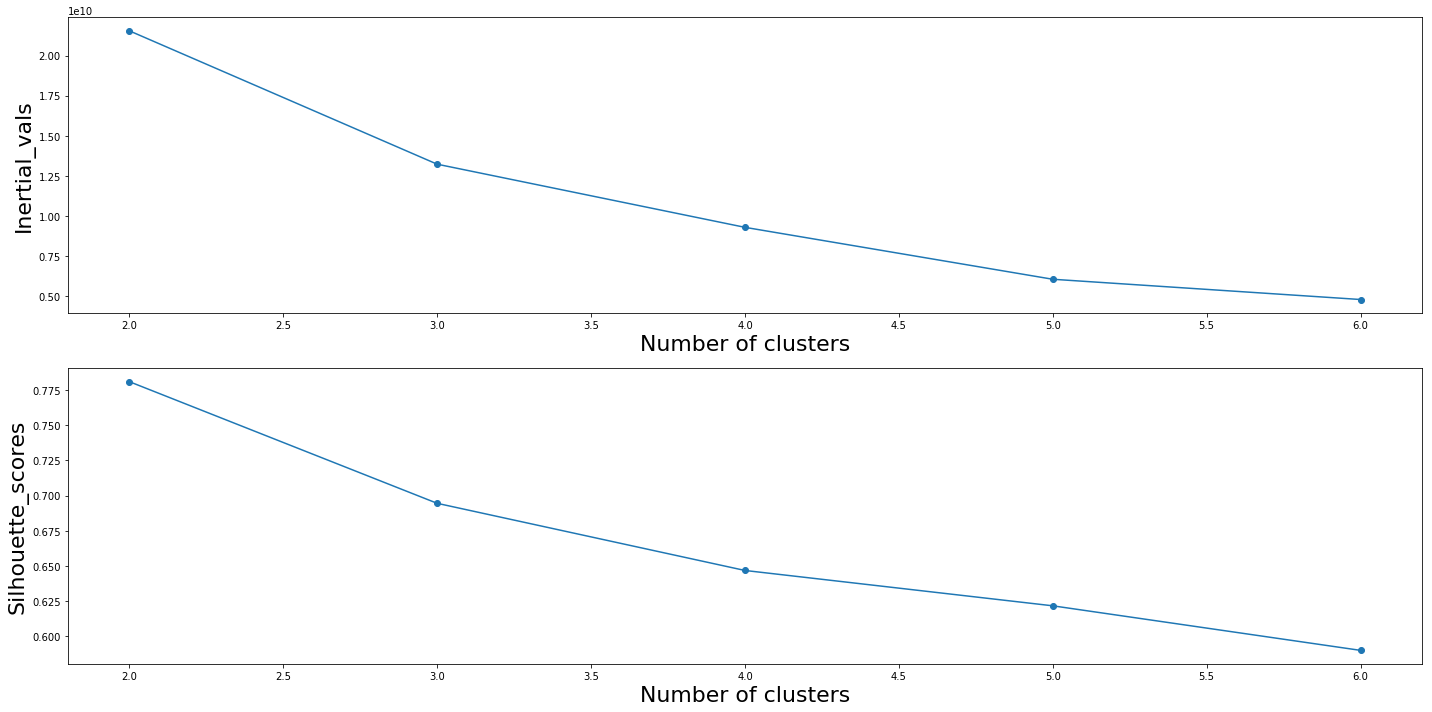

In [58]:
refinedClusters = ElbowEffectAndSilhouetteScoreKprototype(taskThreeDf, list(range(2,7)))

From the plot of Elbow Effect, we can find the Elbow at k=3 or k=4. And, the silhouette scores tell us the k = 3 is better match to its own cluster. Hence, we pick k = 3 for this case.

In [59]:
def CompareVisualization(df_1, model_1, df_2, model_2, columns):
    
    df_1_WithID = deepcopy(df_1)
    df_2_WithID = deepcopy(df_2)
    
    cat_1 = [  i for i, colName in enumerate(df_1_WithID.columns) if not df_1_WithID[colName].dtype == np.float]
    cat_2 = [  i for i, colName in enumerate(df_2_WithID.columns) if not df_2_WithID[colName].dtype == np.float]
    
    
    df_1_WithID['Cluster_ID'] = getPrediction(model_1, df_1, cat_1) # model_1.predict(df_1)
    df_2_WithID['Cluster_ID'] = getPrediction(model_2, df_2, cat_2)

    

    # Rename the Cluster_ID by size
    for df_WithID in [df_1_WithID, df_2_WithID]:
        sorted_countDict = sorted(dict(df_WithID['Cluster_ID'].value_counts()).items(), key=lambda item: item[1])
        for index, i in  enumerate(reversed(sorted_countDict)):
            df_WithID['Cluster_ID'].replace(i[0],"Cluster_" + str(index),inplace=True)
    
    
    print('(1) Value counts: \n',df_1_WithID['Cluster_ID'].value_counts())
    print('(2) Value counts: \n',df_2_WithID['Cluster_ID'].value_counts())
    
    
    
    def getType(colName):
        
        if colName in df_1:
            return df_1[colName].dtype
        elif colName in df_2:
            return df_2[colName].dtype
        else:
            return "NULL"
    
    
    for colName in columns:
        
        print('===========================', colName, '(',getType(colName),')','===========================') 
        
        fig,ax = plt.subplots(ncols=2, nrows=3,figsize=(10, 15))
        if colName in df_1.columns:
            sns.violinplot(x='Cluster_ID', y=colName ,hue= 'Cluster_ID', data=df_1_WithID, ax=ax[0,0] ,scale="count" ,scale_hue=False)
            sns.violinplot(x='Cluster_ID', y=colName ,hue= 'Cluster_ID', data=df_1_WithID, ax=ax[1,0] )           
            sns.scatterplot(x='Cluster_ID', y=colName ,hue= 'Cluster_ID',  data=df_1_WithID, alpha=0.2, ax=ax[2,0])
            ax[0,0].get_legend().remove()
            ax[1,0].get_legend().remove()
            ax[2,0].get_legend().remove()
           
        
        if colName in df_2.columns:
            sns.violinplot(x='Cluster_ID', y=colName ,hue= 'Cluster_ID', data=df_2_WithID, ax=ax[0, 1] ,scale="count",scale_hue=False)
            sns.violinplot(x='Cluster_ID', y=colName ,hue= 'Cluster_ID', data=df_2_WithID, ax=ax[1 ,1]) 
            sns.scatterplot(x='Cluster_ID', y=colName ,hue= 'Cluster_ID', data=df_2_WithID, alpha=0.2, ax=ax[2,1])
            ax[0,1].get_legend().remove()
            ax[1,1].get_legend().remove()
            ax[2,1].get_legend().remove()
            
       
        plt.tight_layout()
#         plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
        plt.show()
    
    return df_1_WithID, df_2_WithID

(1) Value counts: 
 Cluster_0    10101
Cluster_1     1975
Cluster_2      207
Name: Cluster_ID, dtype: int64
(2) Value counts: 
 Cluster_0    10101
Cluster_1     1975
Cluster_2      207
Name: Cluster_ID, dtype: int64
=========================== Administrative ( float64 ) ===========================


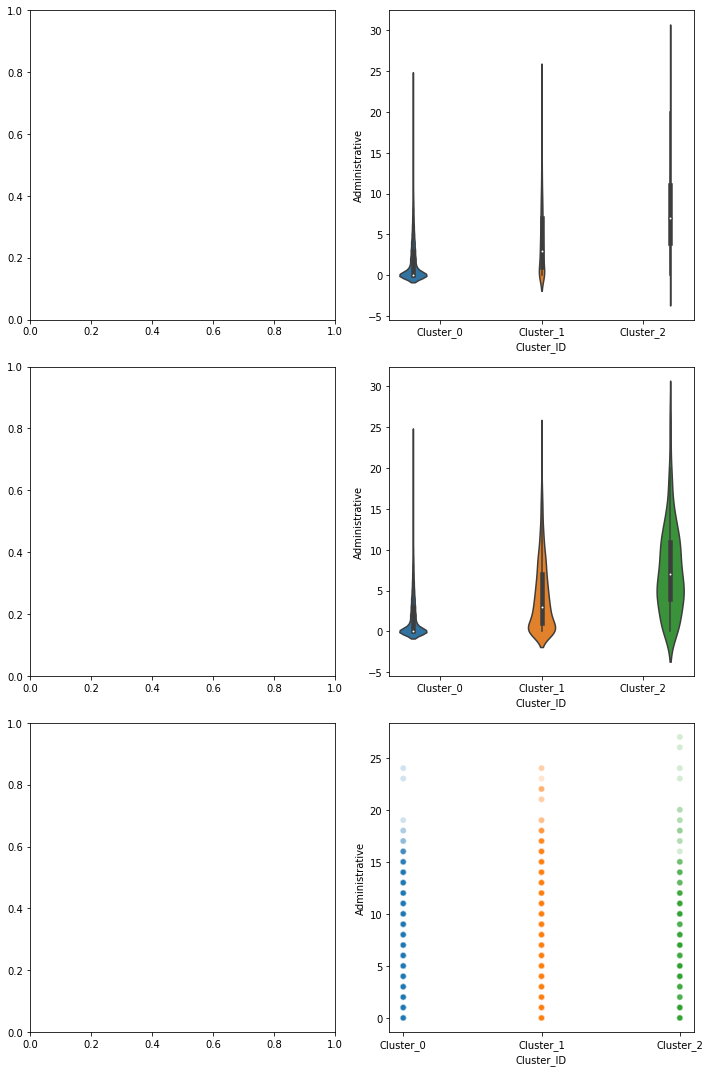

=========================== Administrative_Duration ( float64 ) ===========================


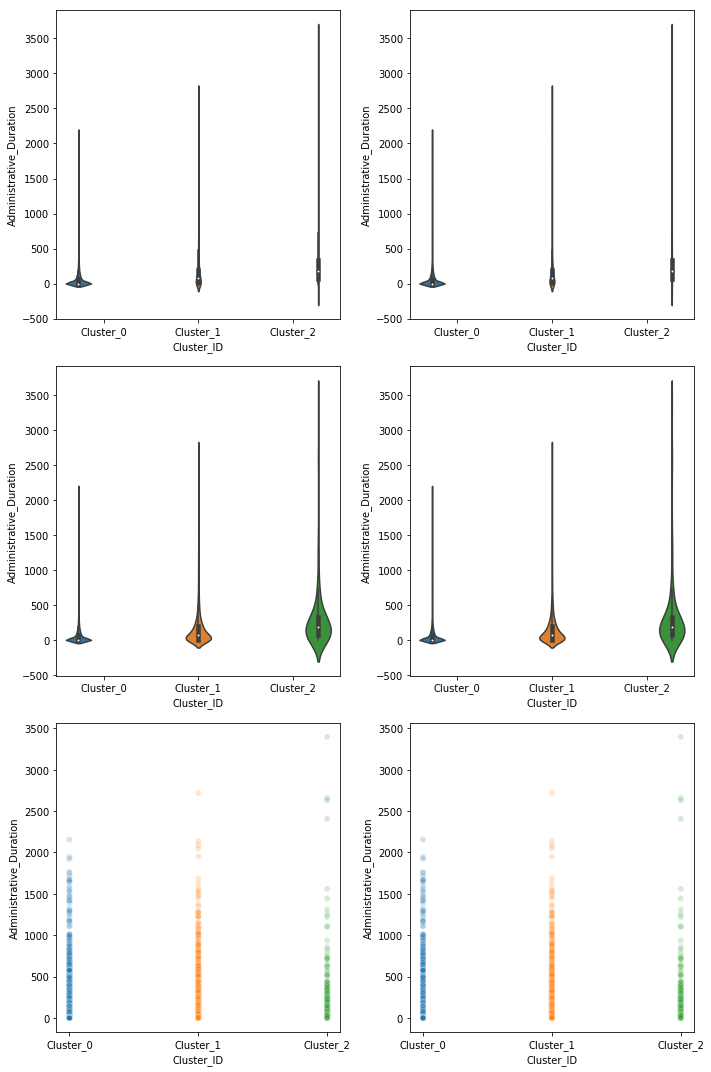

=========================== Informational ( float64 ) ===========================


=========================== Informational_Duration ( float64 ) ===========================


=========================== ProductRelated ( float64 ) ===========================


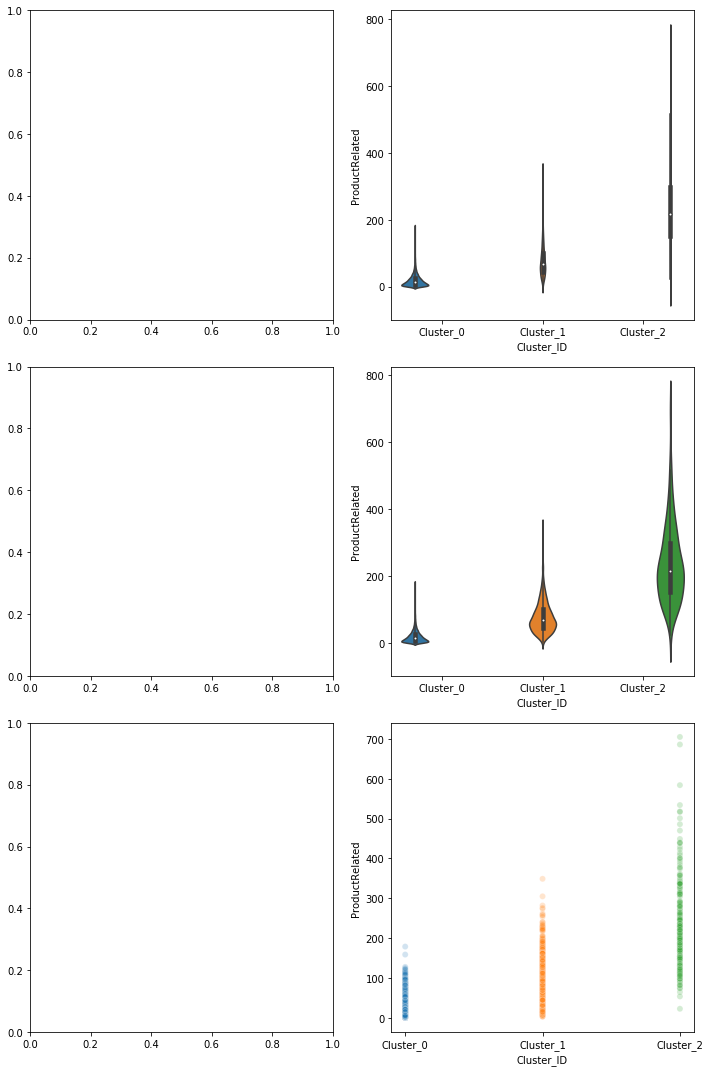

=========================== ProductRelated_Duration ( float64 ) ===========================


=========================== BounceRates ( float64 ) ===========================


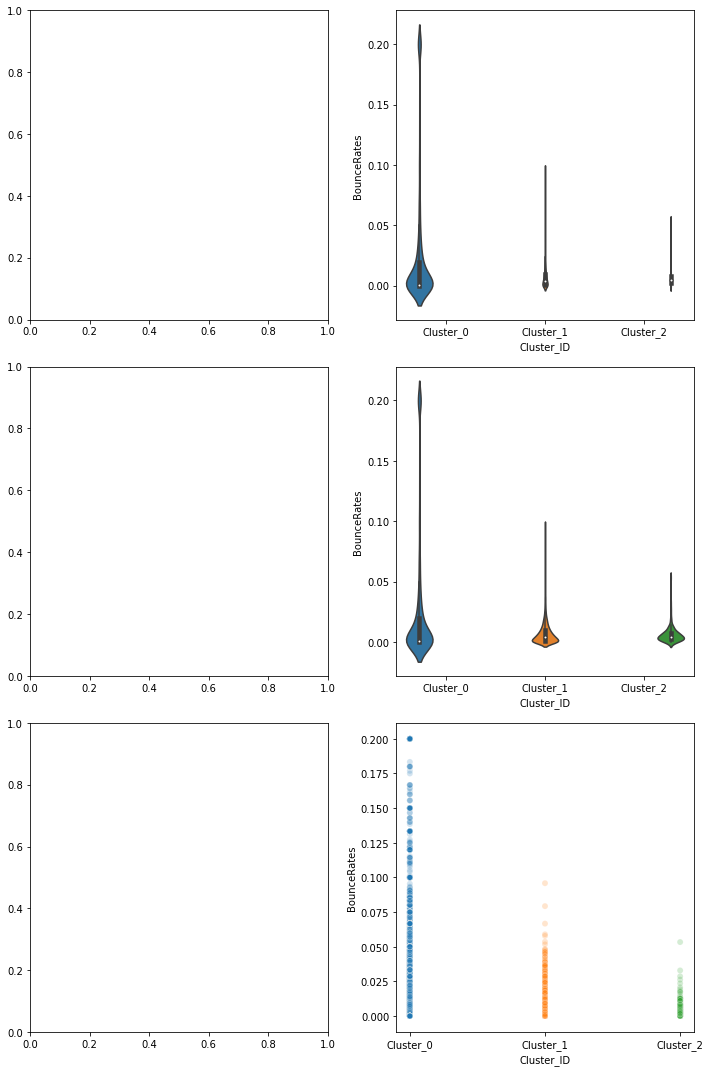

=========================== ExitRates ( float64 ) ===========================


=========================== PageValues ( float64 ) ===========================


=========================== SpecialDay ( float64 ) ===========================


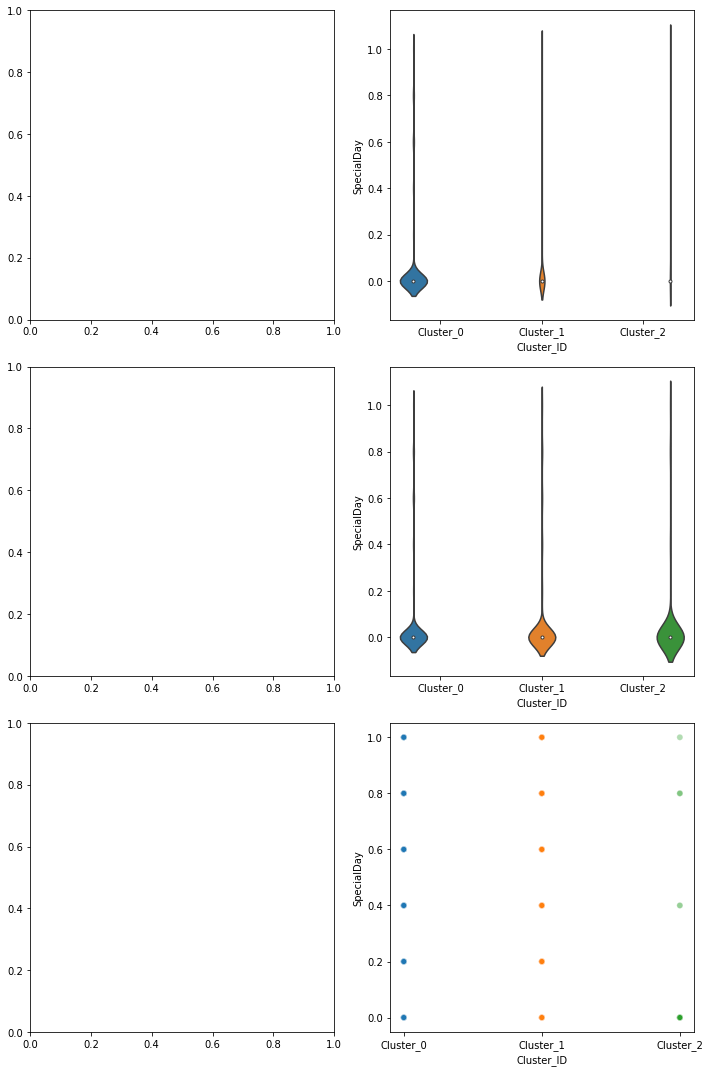

=========================== Month_Aug ( uint8 ) ===========================


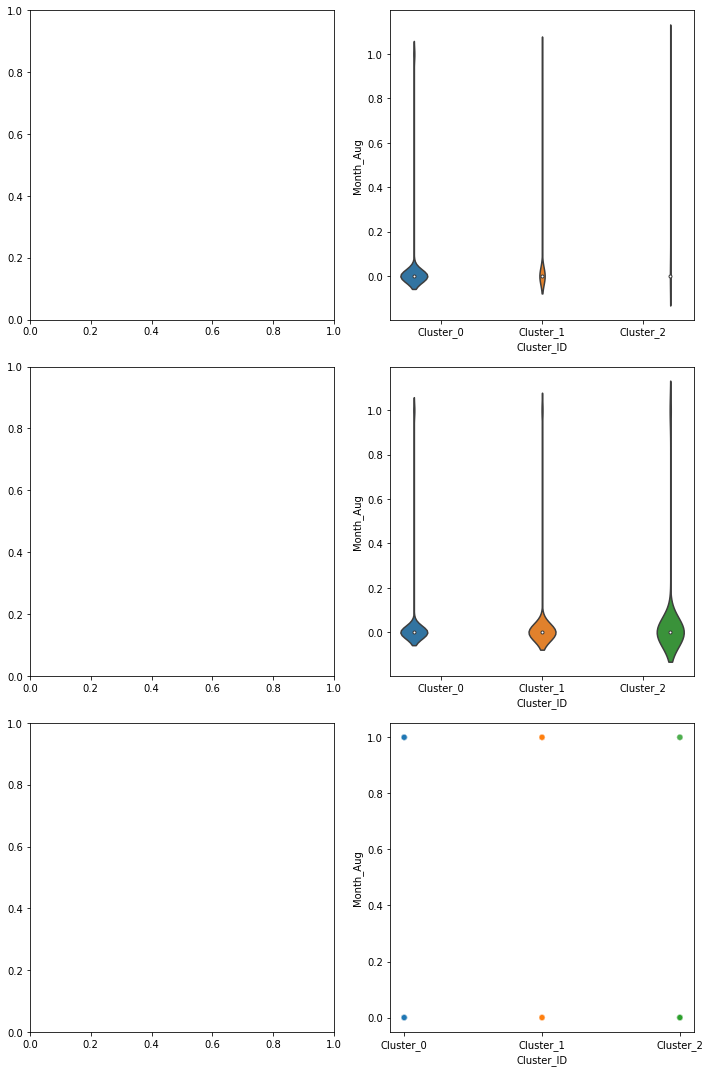

=========================== Month_Dec ( uint8 ) ===========================


=========================== Month_Feb ( uint8 ) ===========================


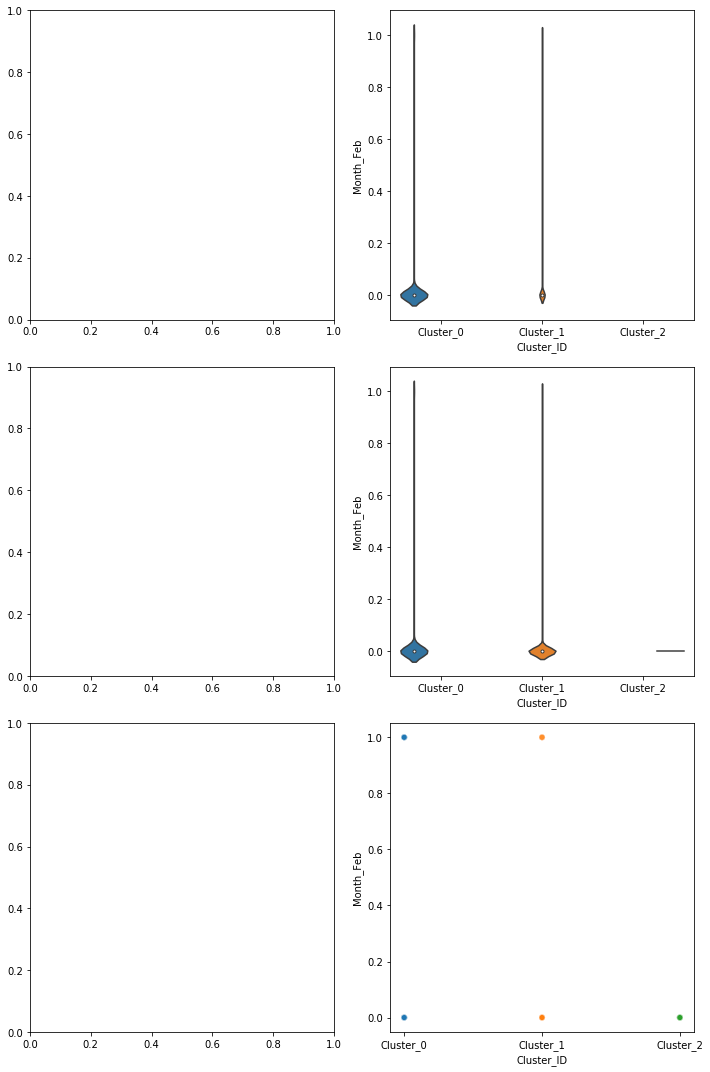

=========================== Month_Jul ( uint8 ) ===========================


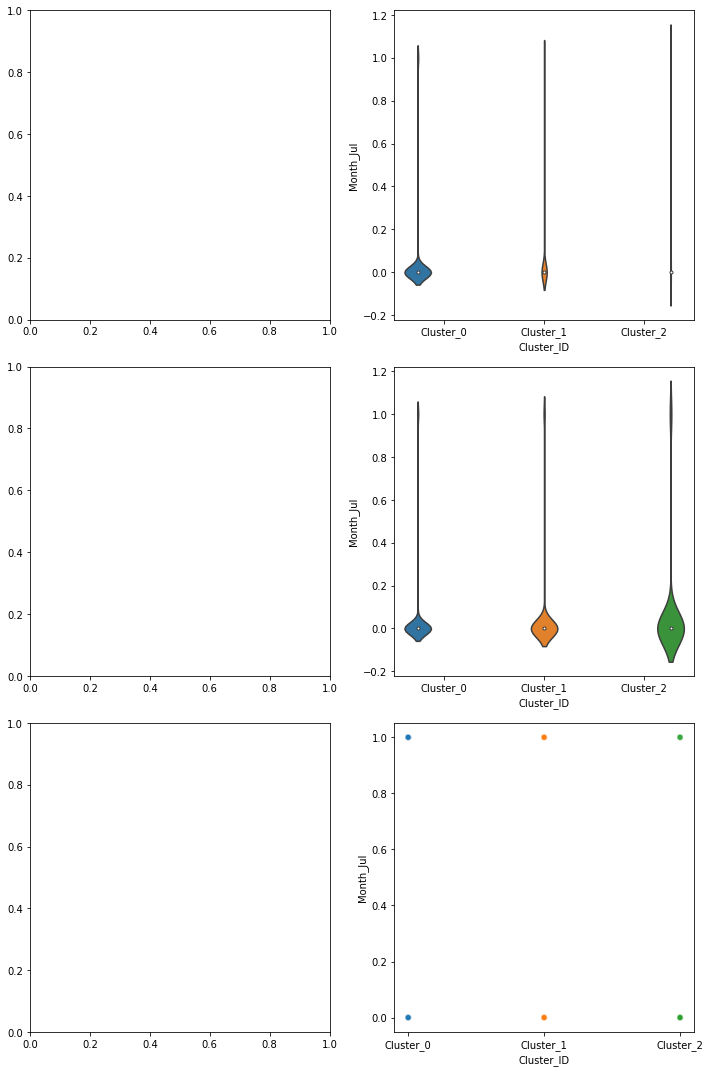

=========================== Month_June ( uint8 ) ===========================


=========================== Month_Mar ( uint8 ) ===========================


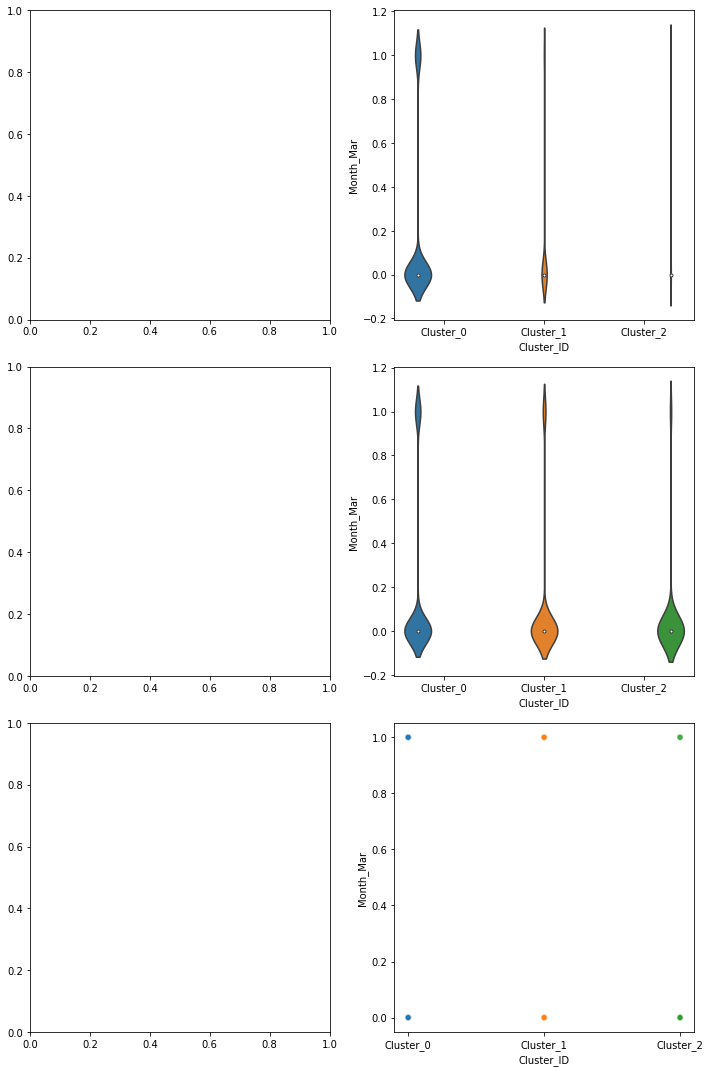

=========================== Month_May ( uint8 ) ===========================


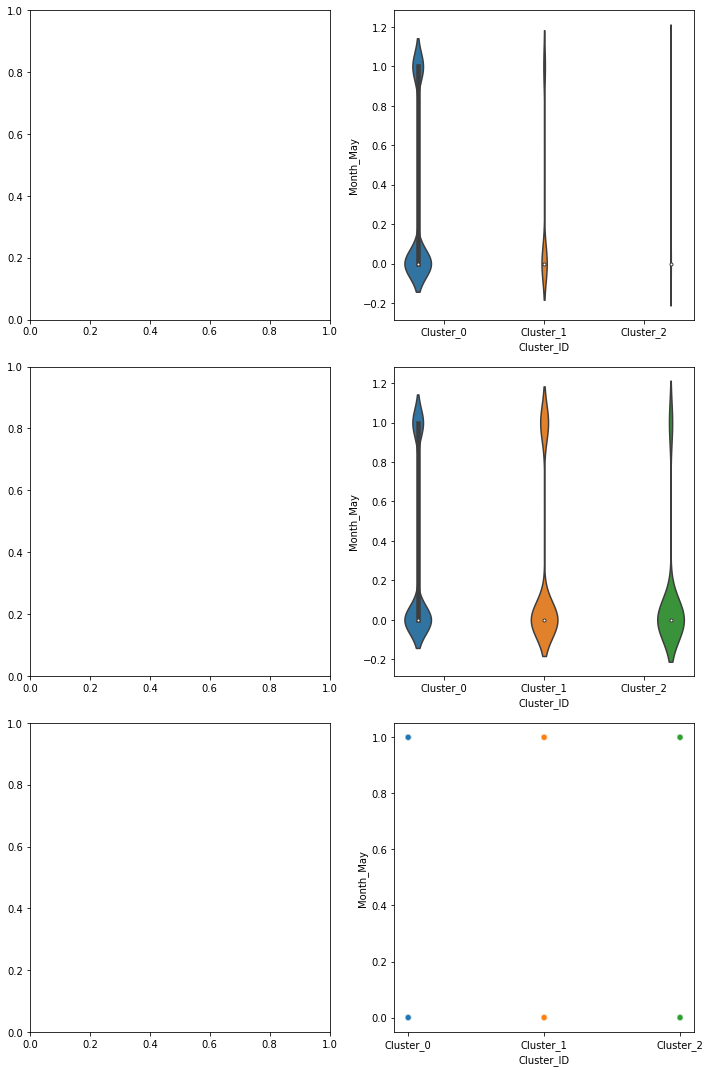

=========================== Month_Nov ( uint8 ) ===========================


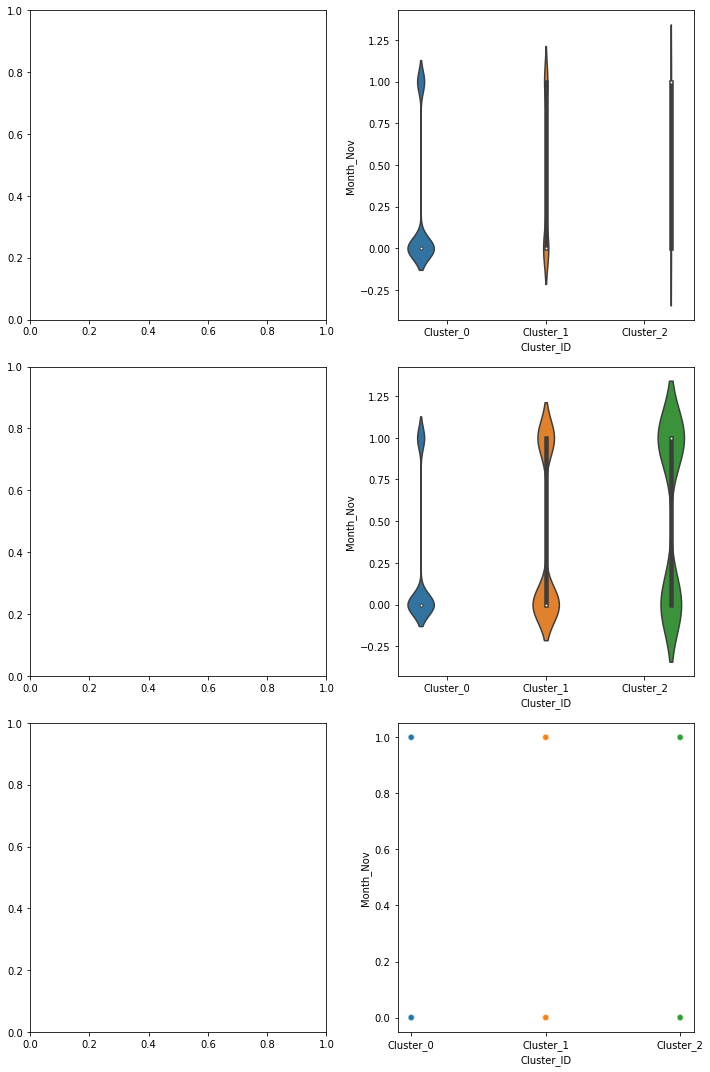

=========================== Month_Oct ( uint8 ) ===========================


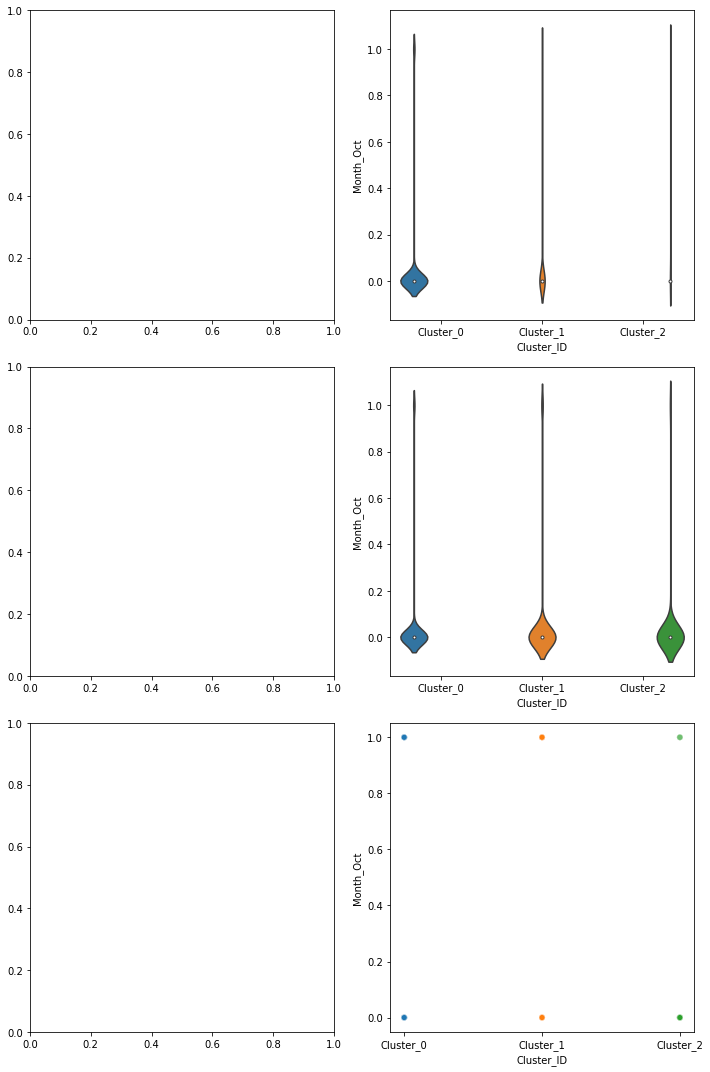

=========================== Month_Sep ( uint8 ) ===========================


=========================== OperatingSystems_1 ( uint8 ) ===========================


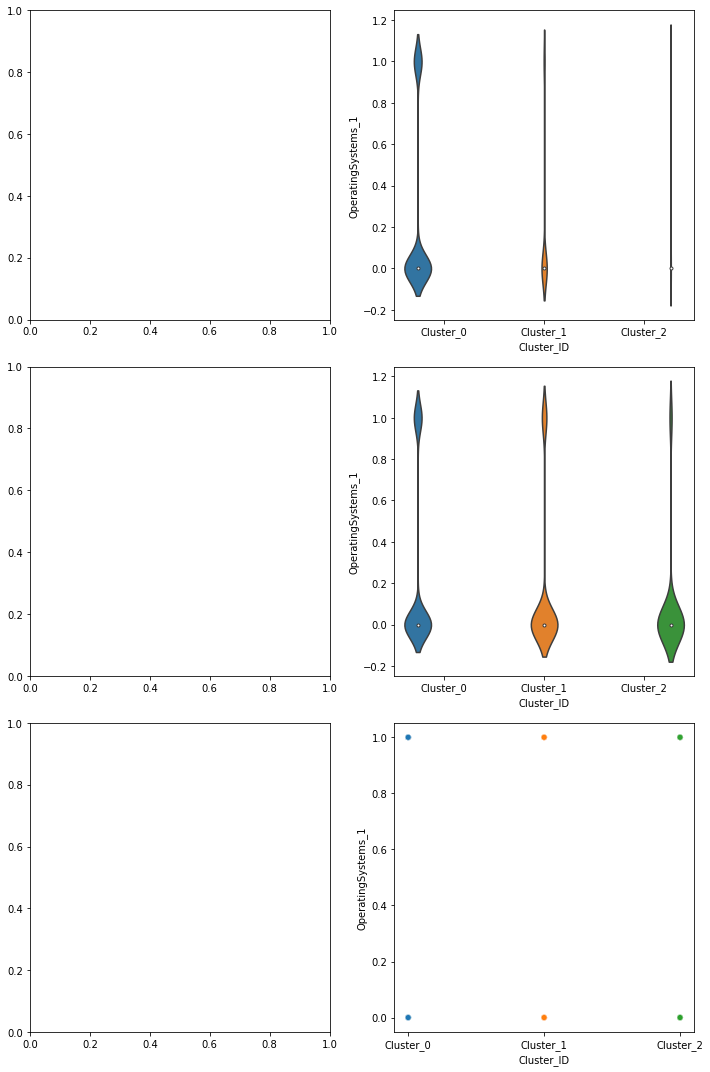

=========================== OperatingSystems_2 ( uint8 ) ===========================


=========================== OperatingSystems_3 ( uint8 ) ===========================


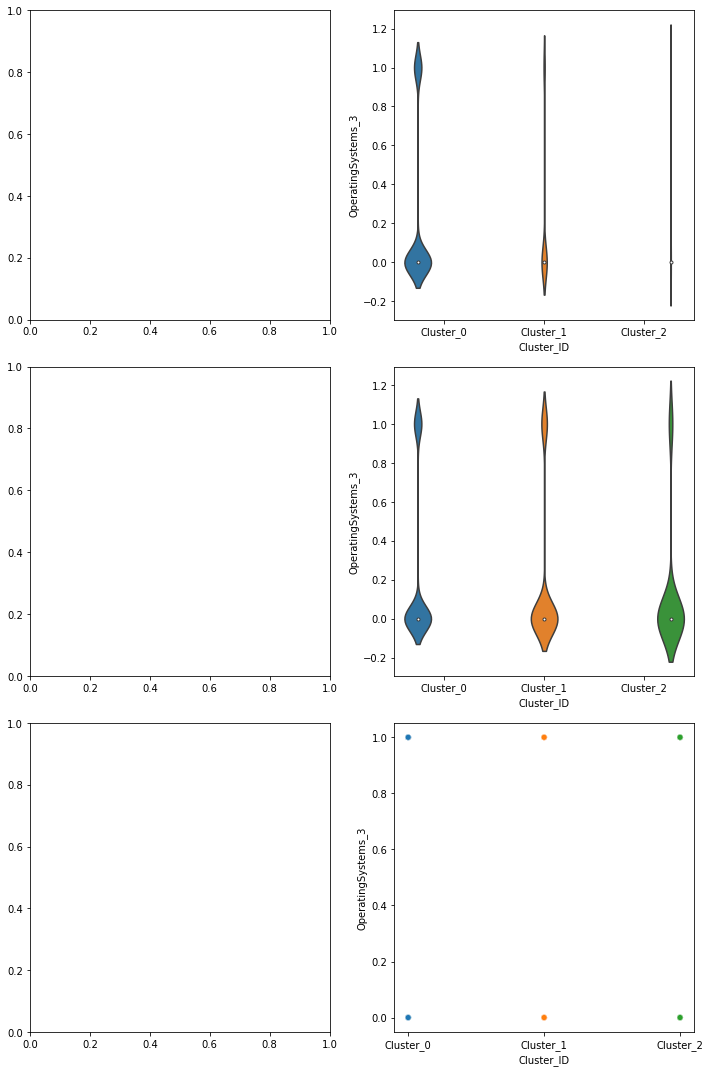

=========================== OperatingSystems_4 ( uint8 ) ===========================


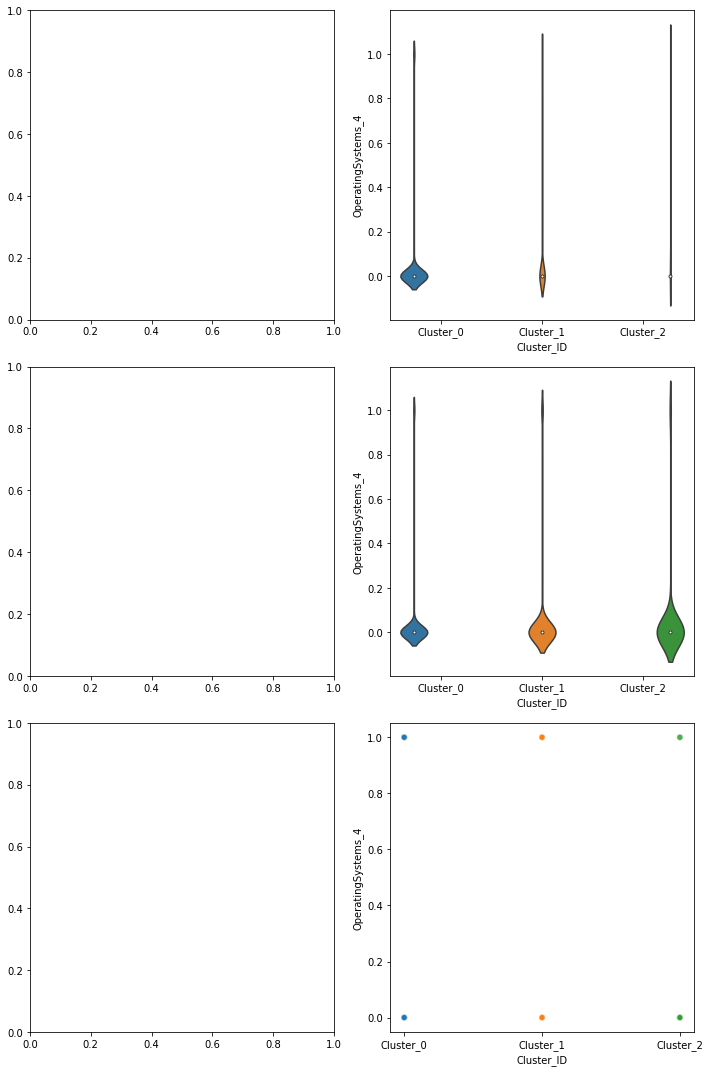

=========================== OperatingSystems_5 ( uint8 ) ===========================


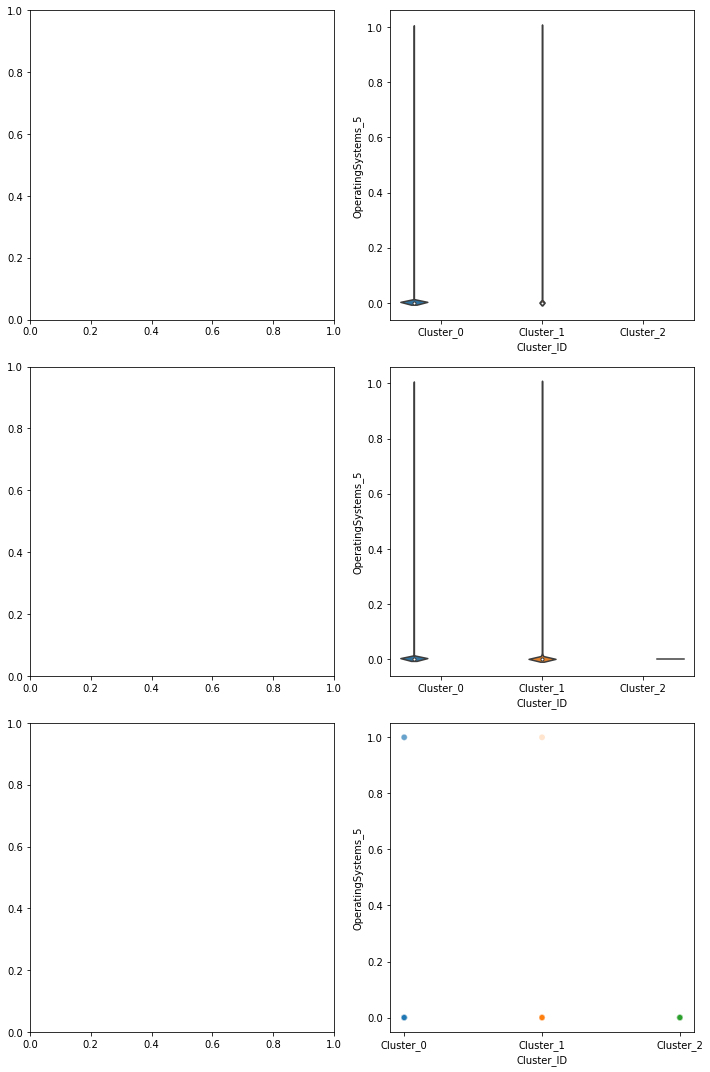

=========================== OperatingSystems_6 ( uint8 ) ===========================


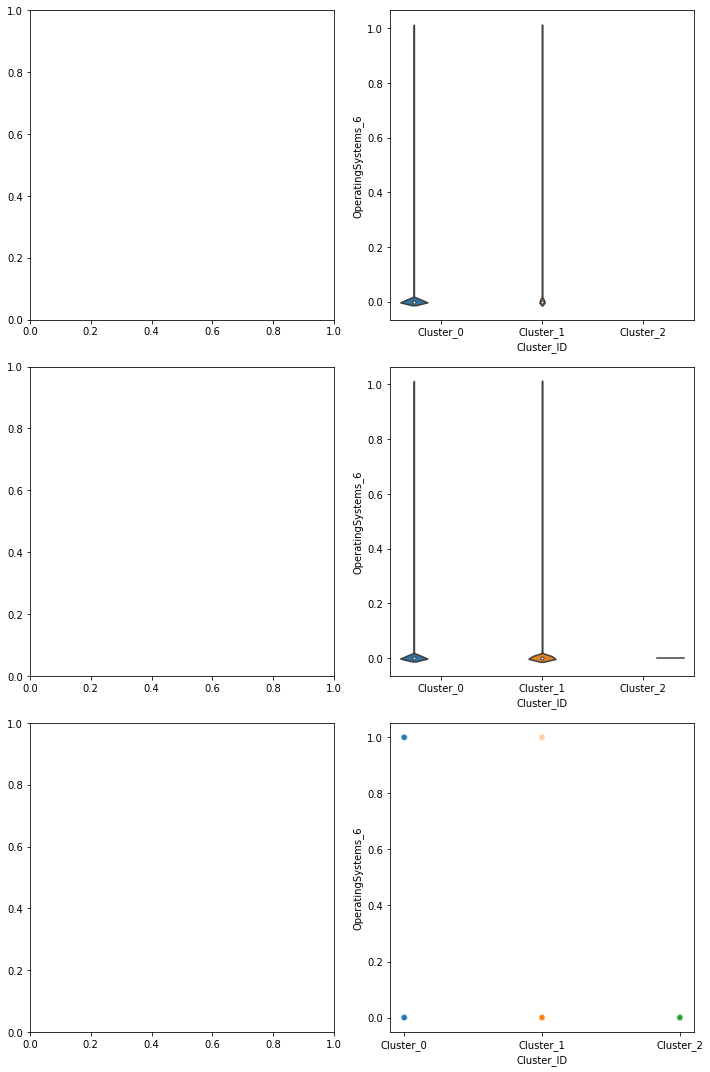

=========================== OperatingSystems_7 ( uint8 ) ===========================


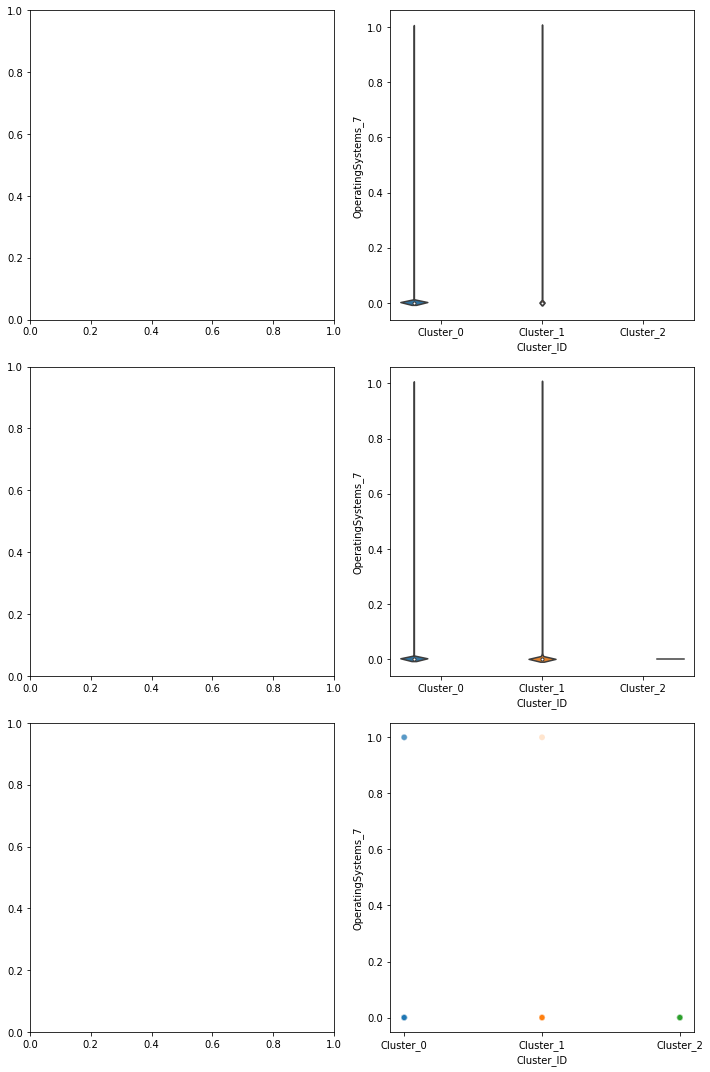

=========================== OperatingSystems_8 ( uint8 ) ===========================


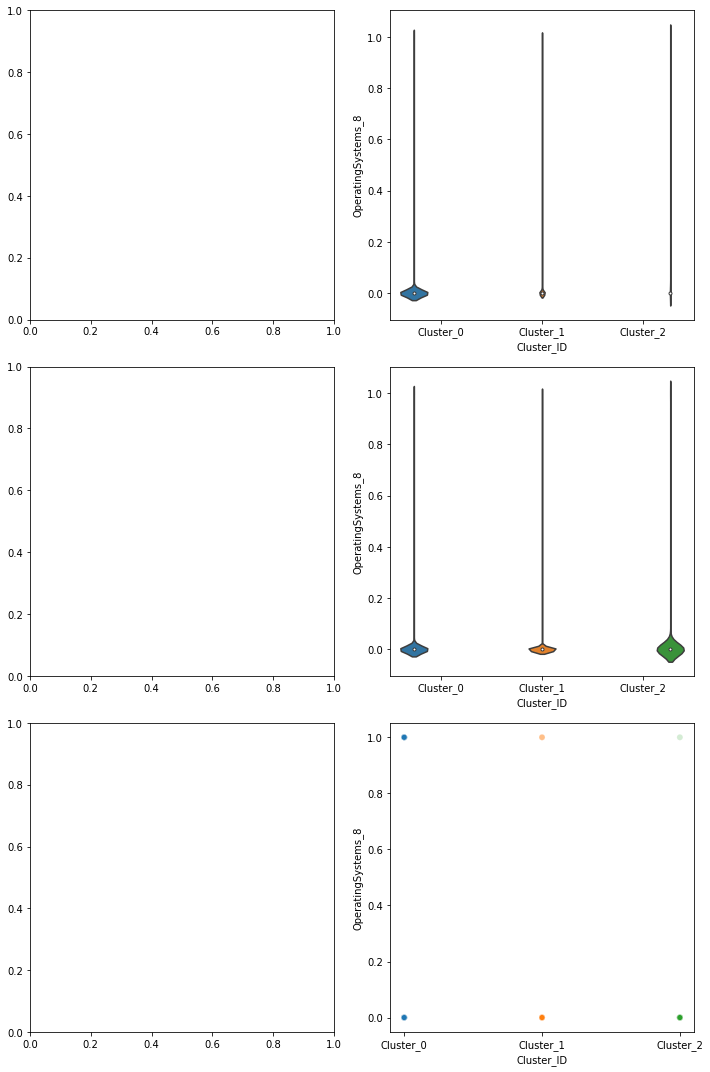

=========================== Browser_1 ( uint8 ) ===========================


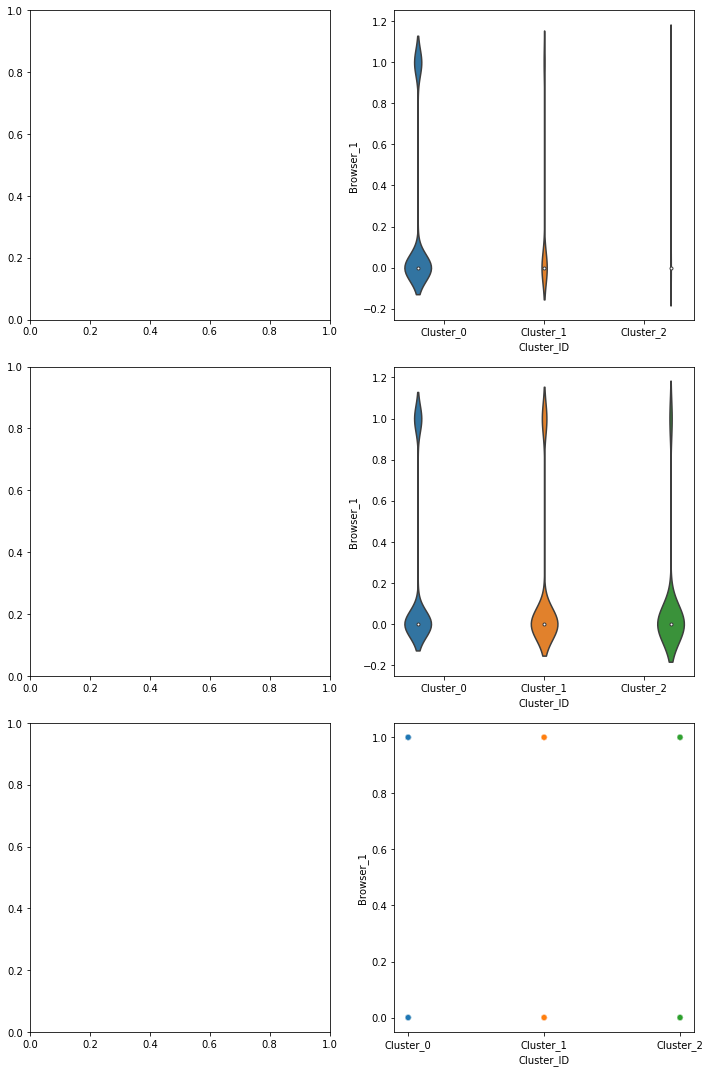

=========================== Browser_2 ( uint8 ) ===========================


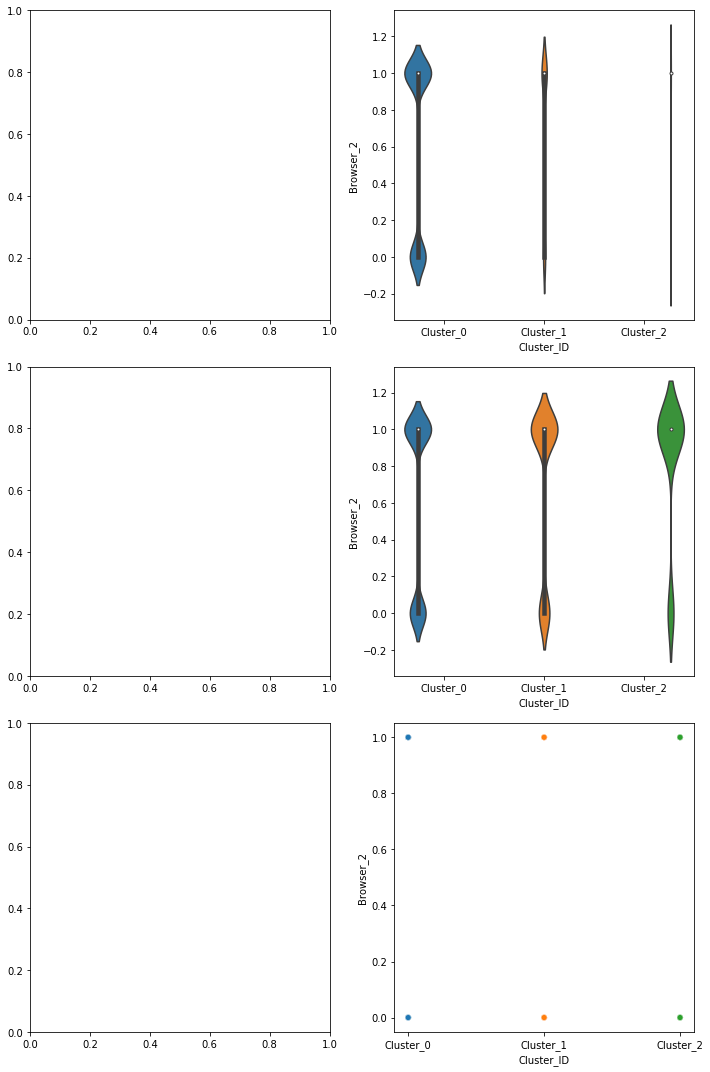

=========================== Browser_3 ( uint8 ) ===========================


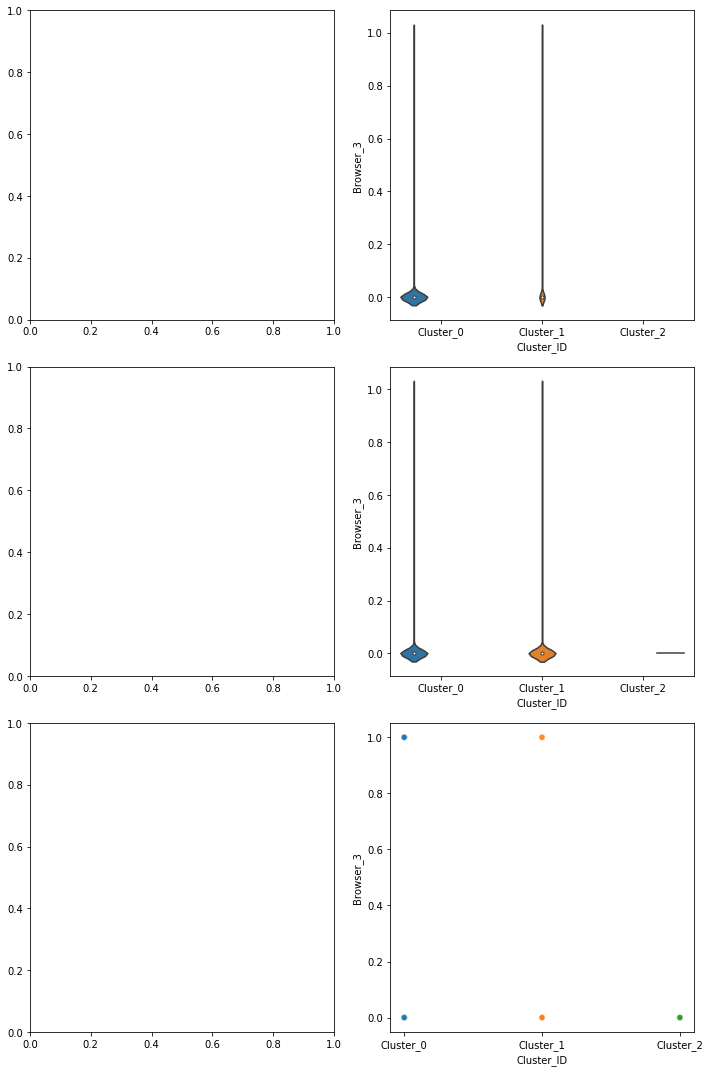

=========================== Browser_4 ( uint8 ) ===========================


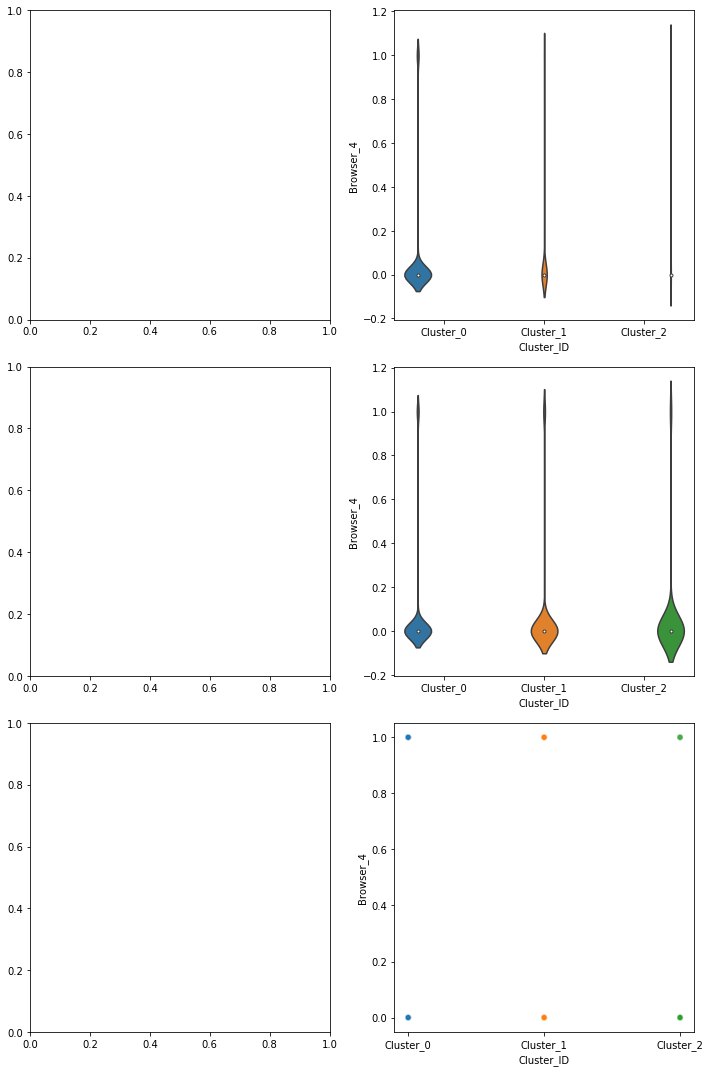

=========================== Browser_5 ( uint8 ) ===========================


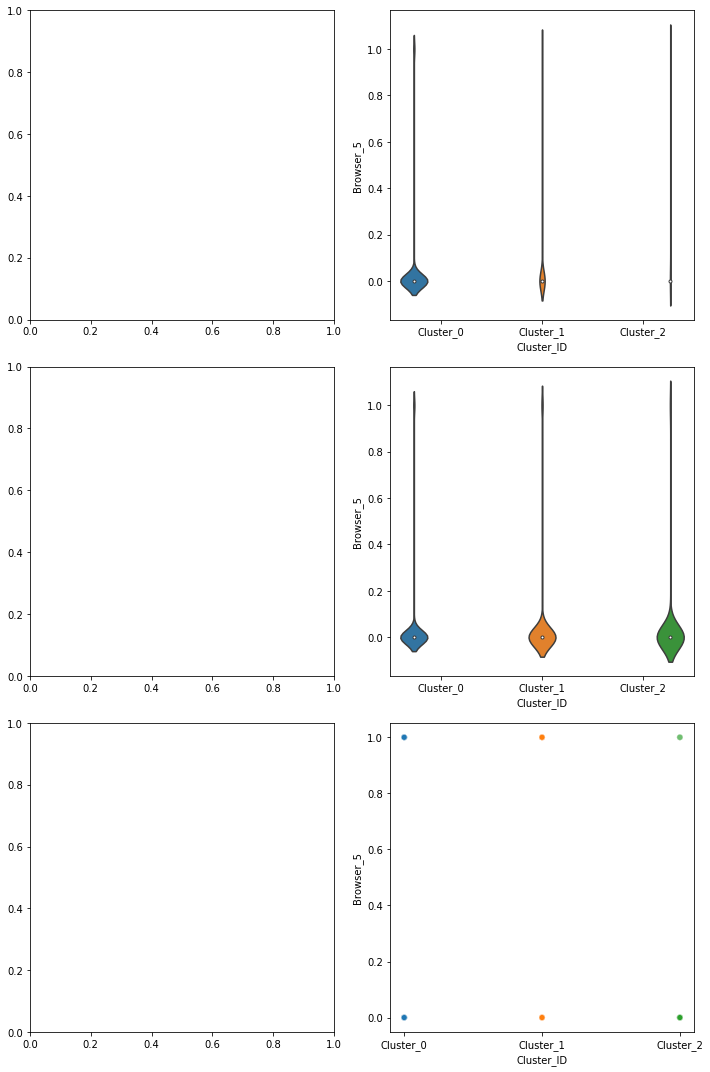

=========================== Browser_6 ( uint8 ) ===========================


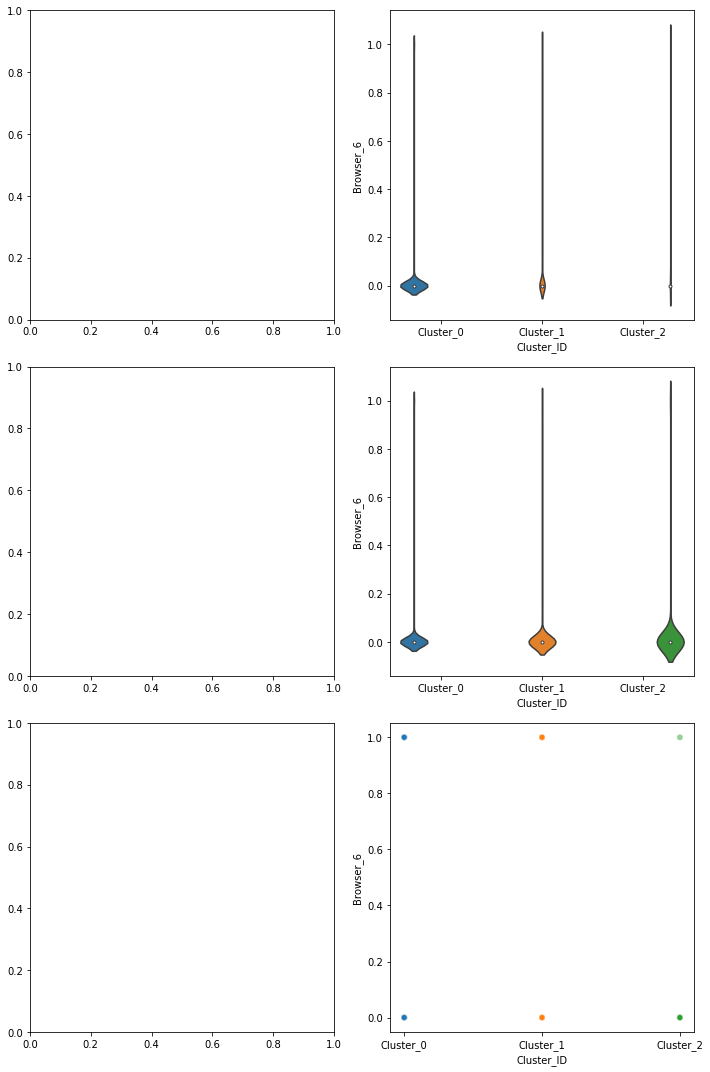

=========================== Browser_7 ( uint8 ) ===========================


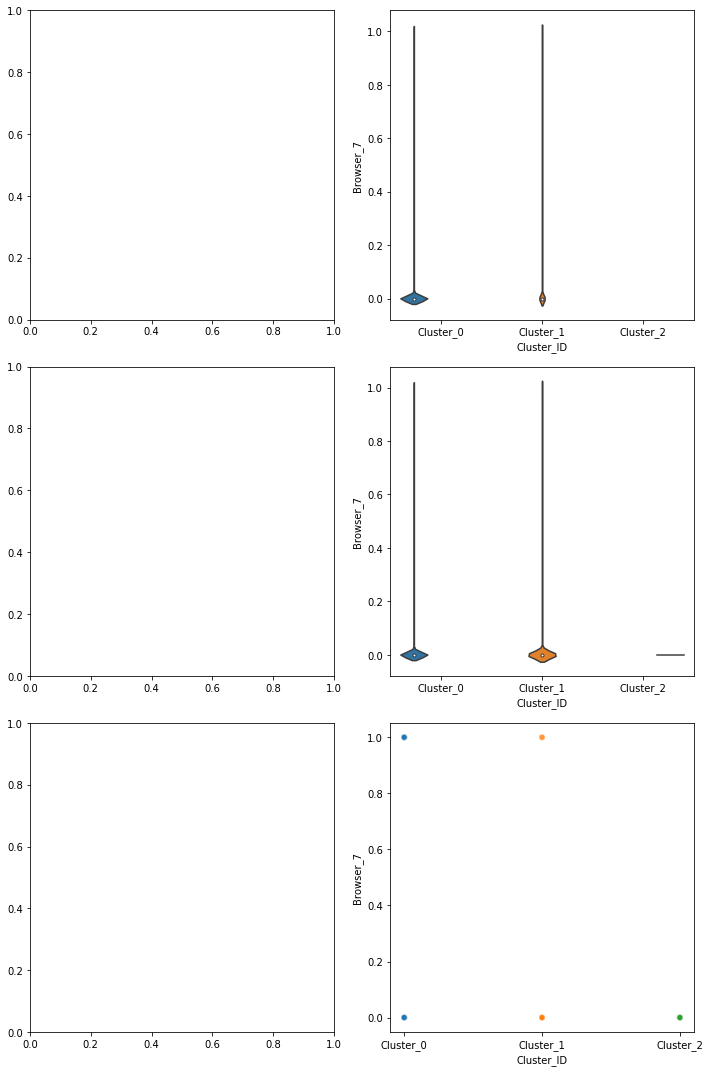

=========================== Browser_8 ( uint8 ) ===========================


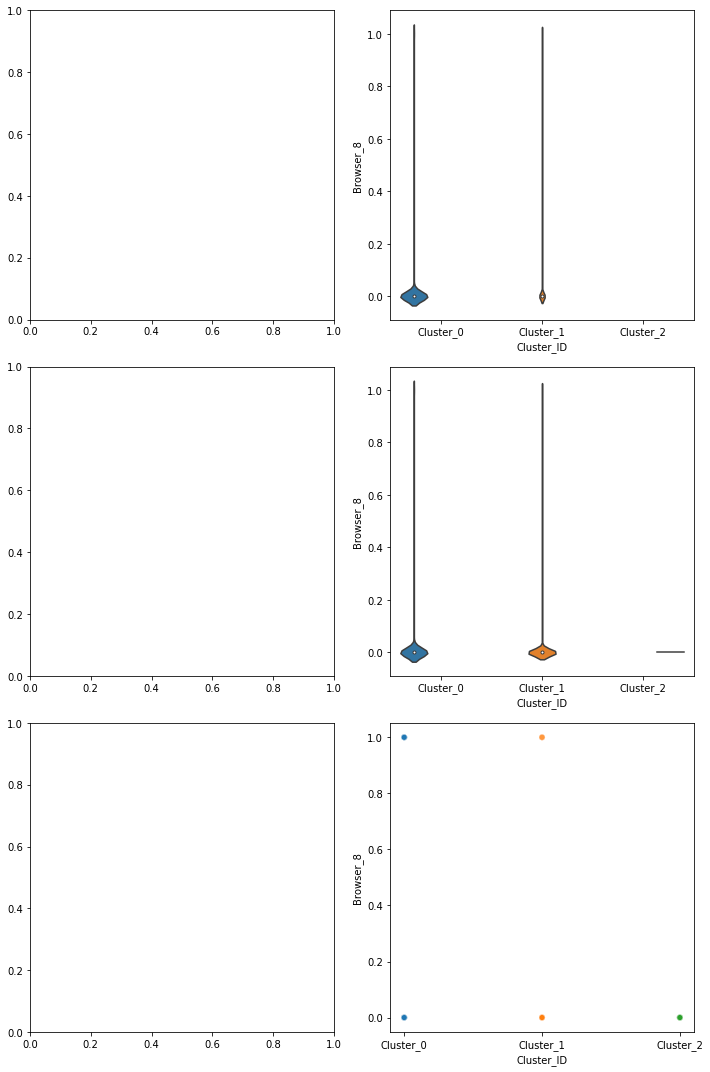

=========================== Browser_9 ( uint8 ) ===========================


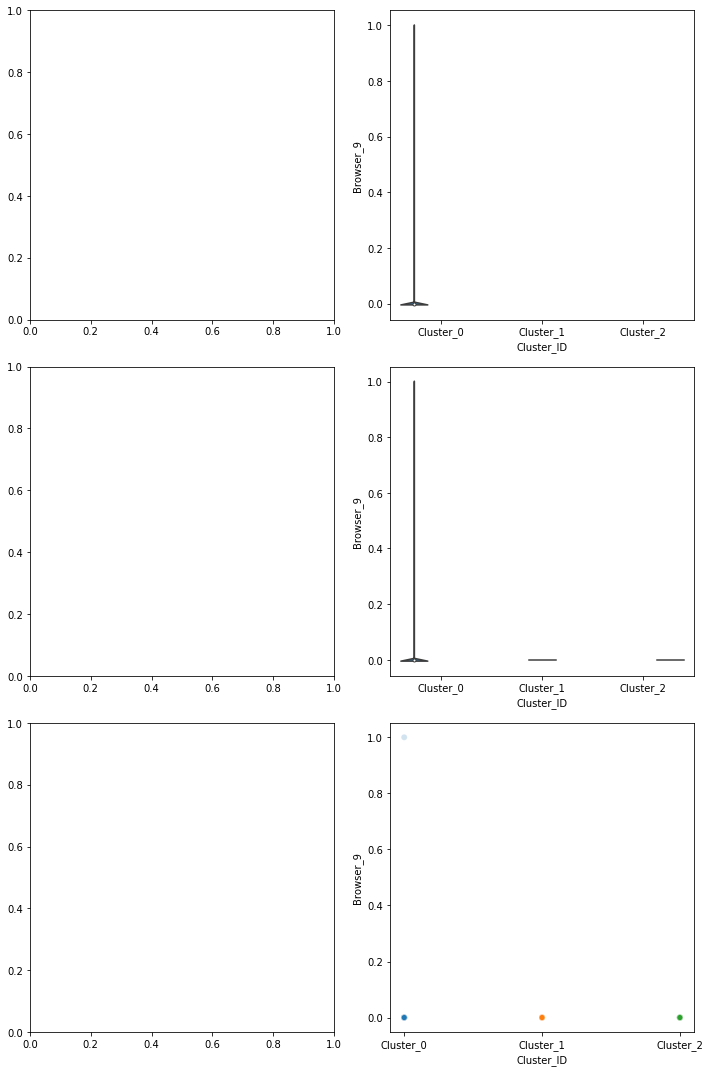

=========================== Browser_10 ( uint8 ) ===========================


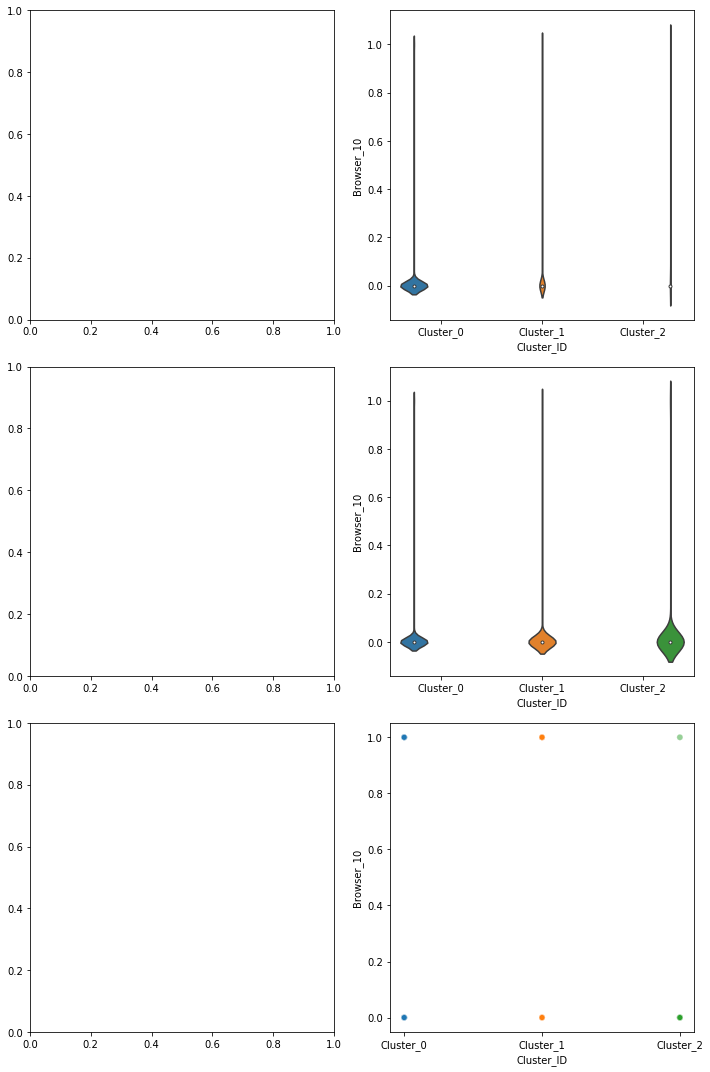

=========================== Browser_11 ( uint8 ) ===========================


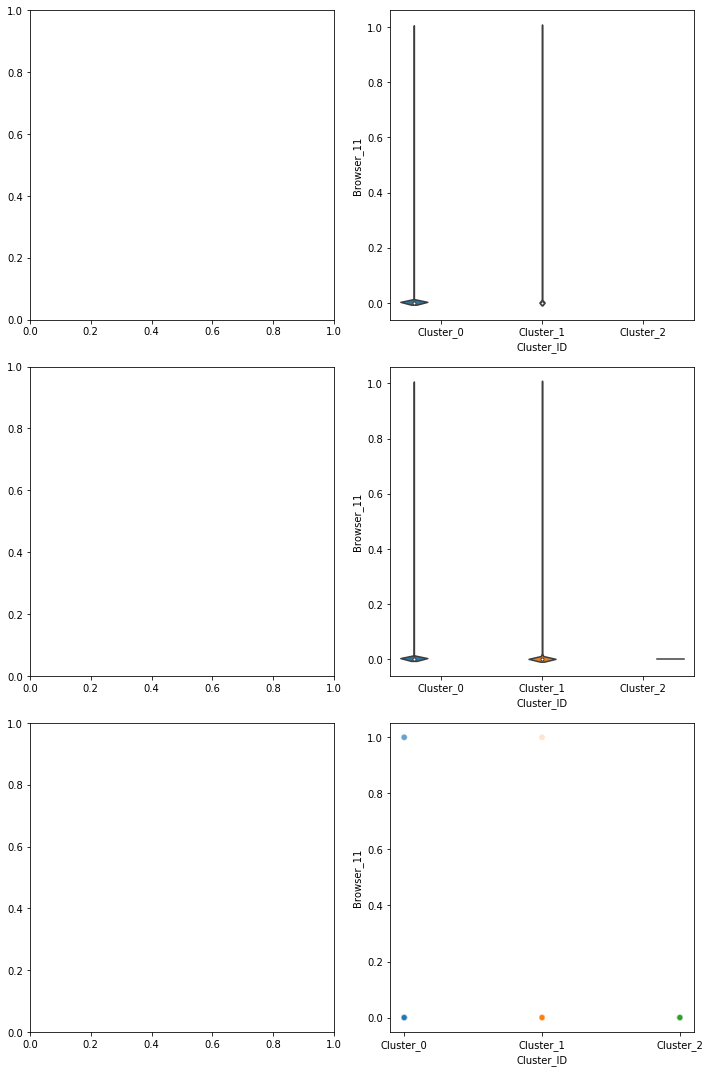

=========================== Browser_12 ( uint8 ) ===========================


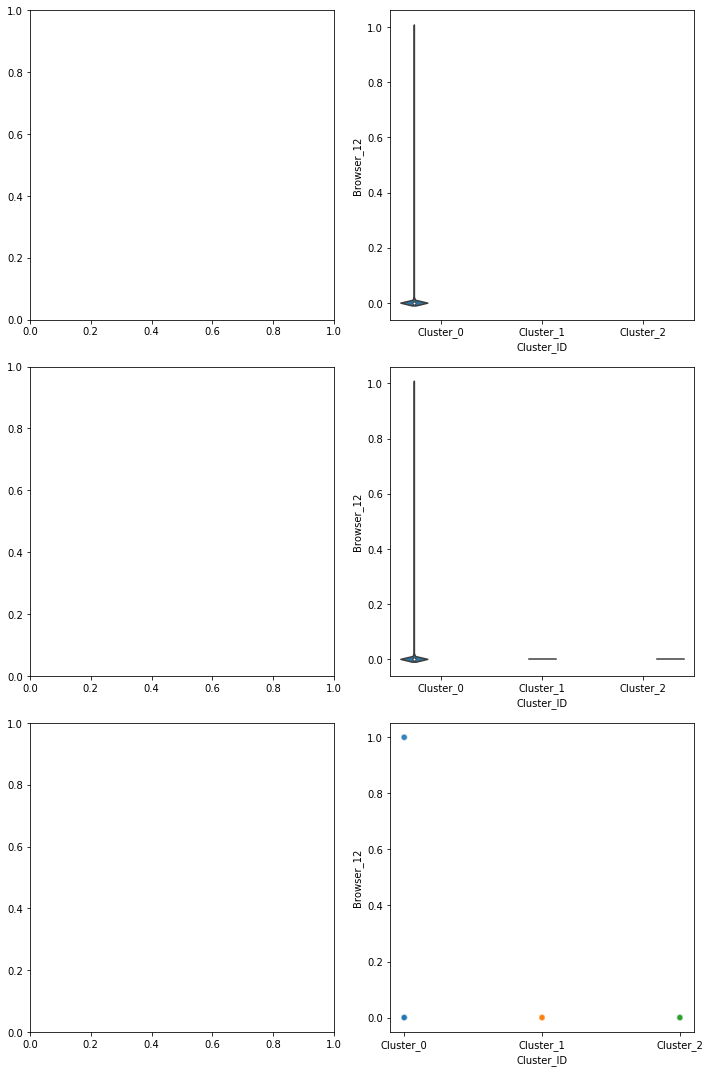

=========================== Browser_13 ( uint8 ) ===========================


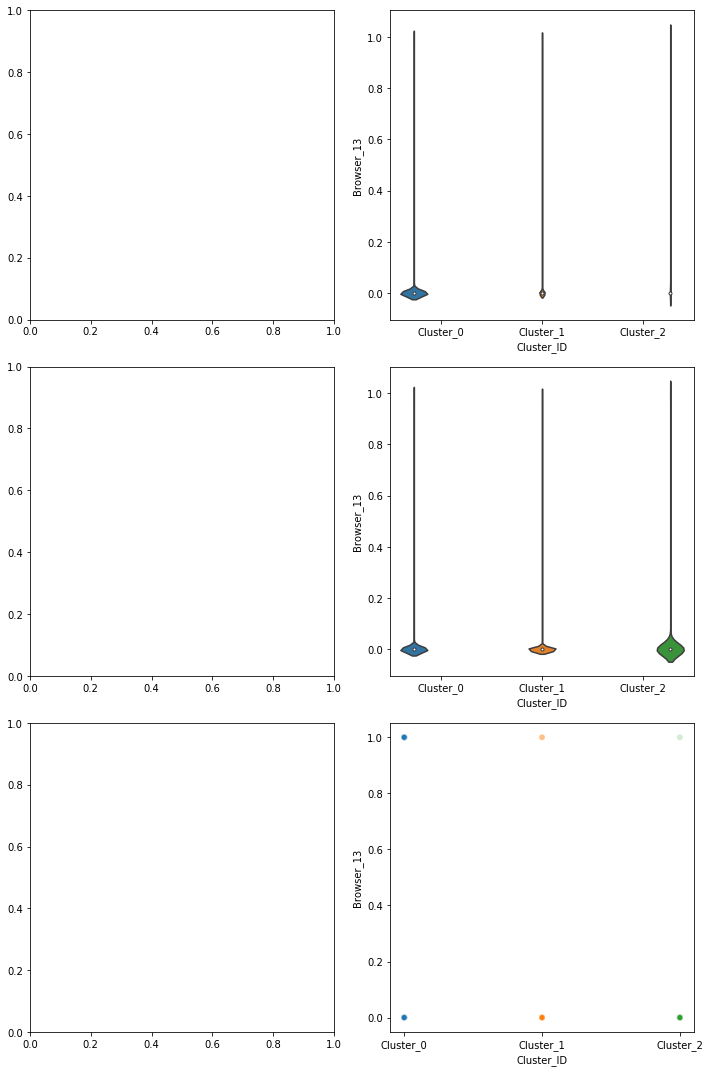

=========================== Region_1 ( uint8 ) ===========================


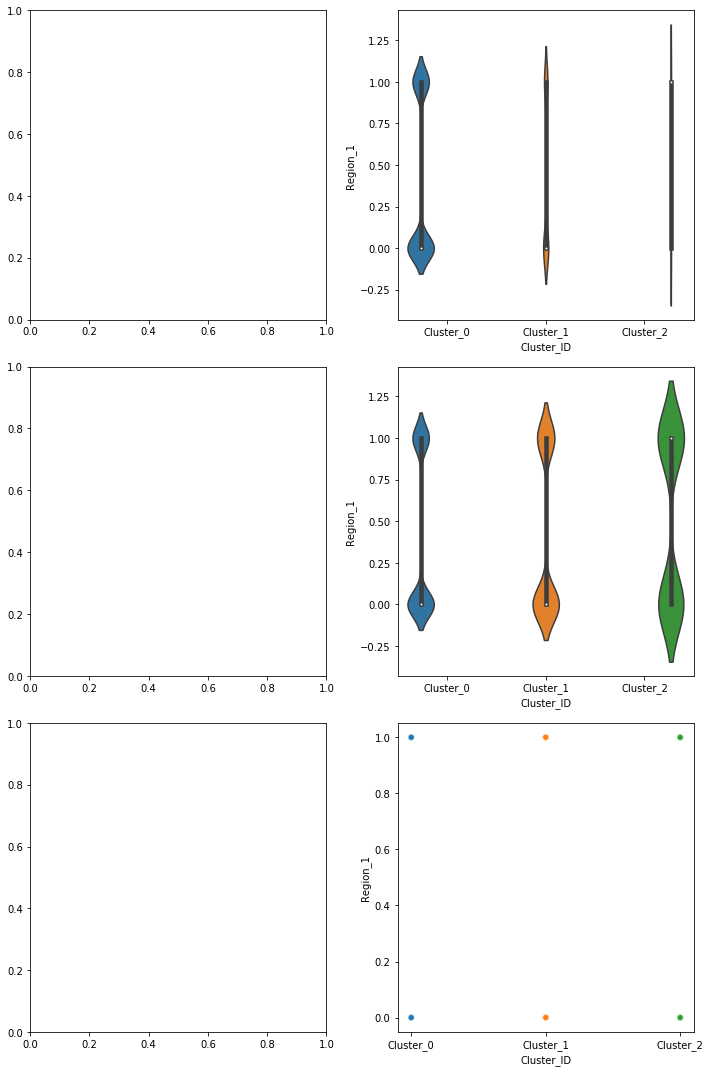

=========================== Region_2 ( uint8 ) ===========================


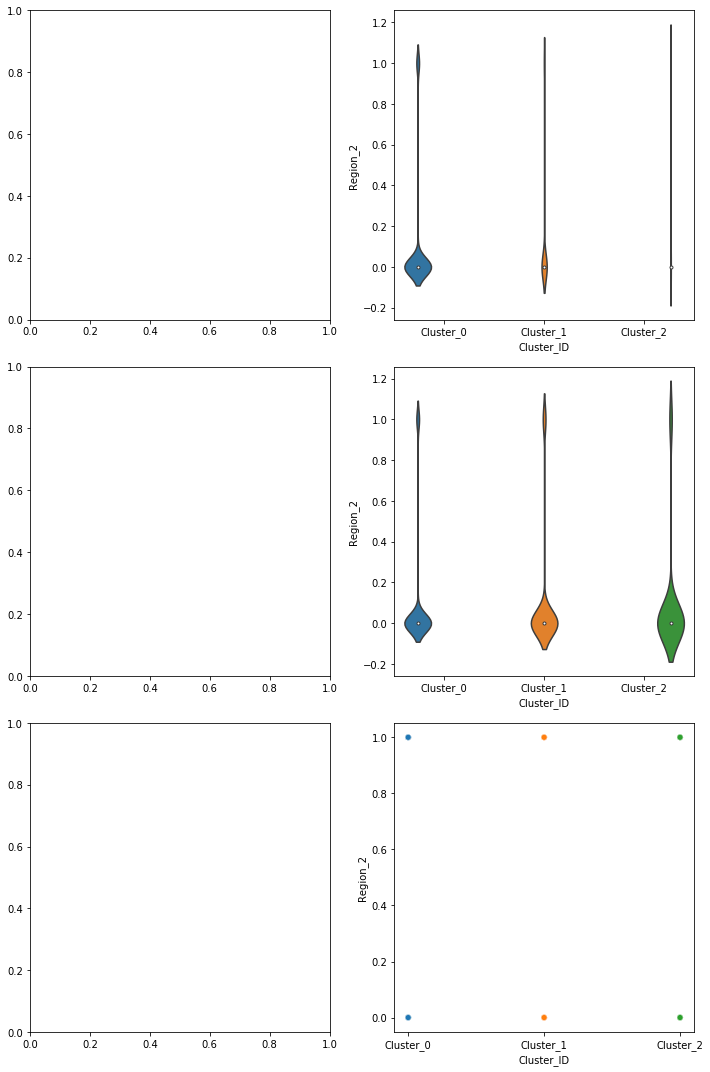

=========================== Region_3 ( uint8 ) ===========================


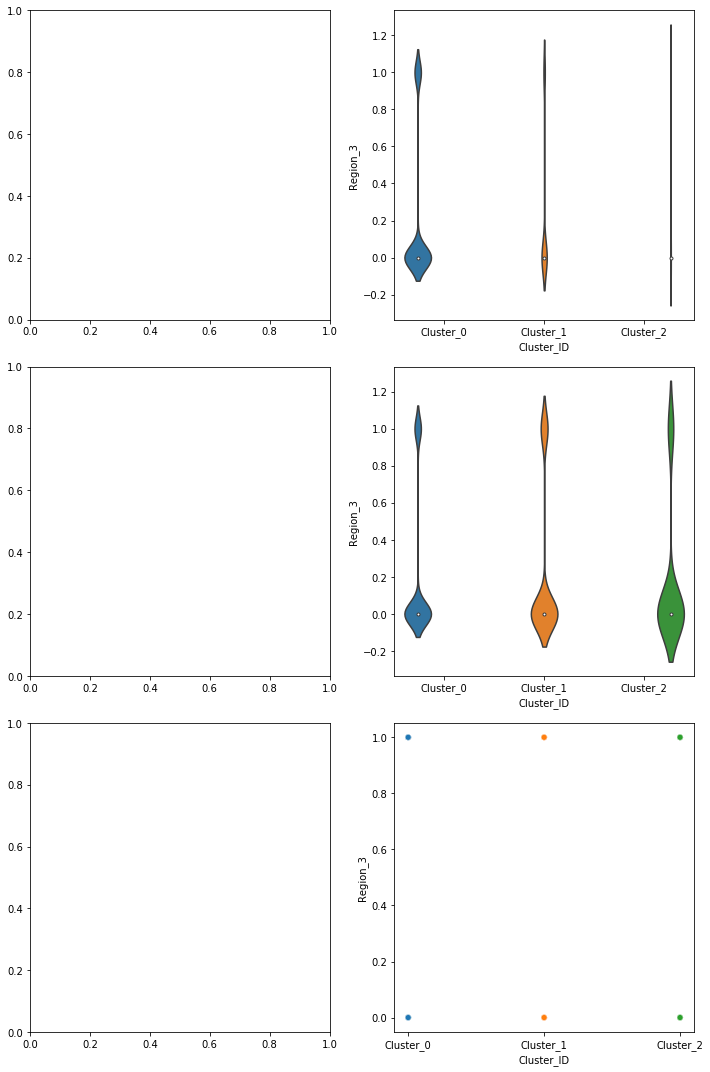

=========================== Region_4 ( uint8 ) ===========================


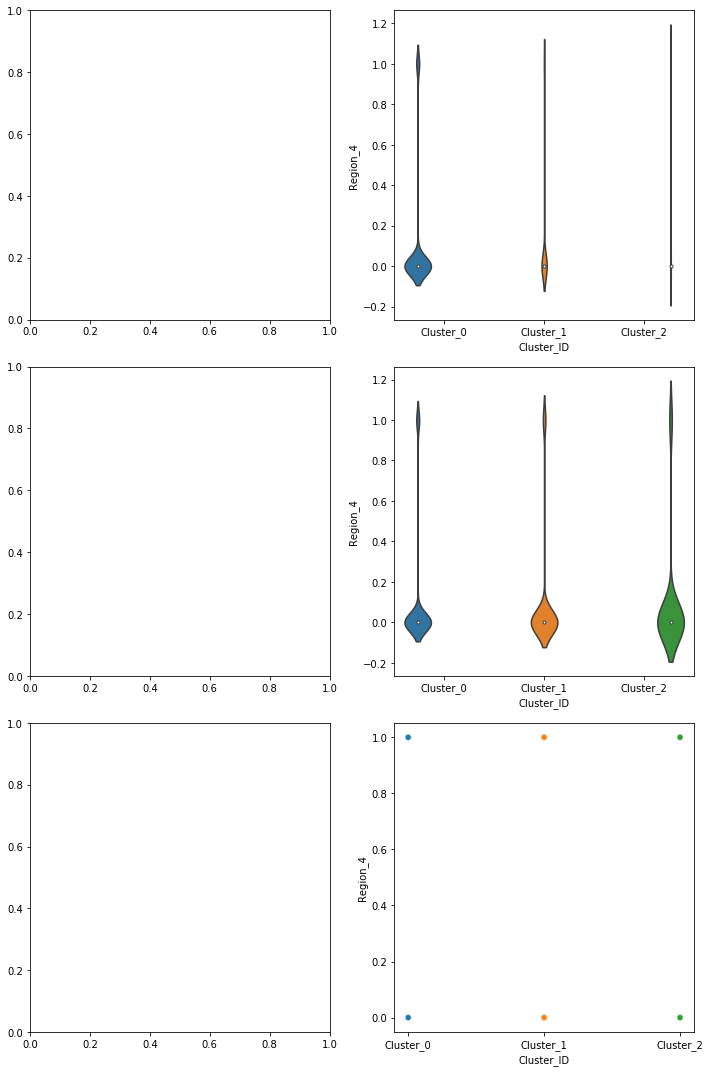

=========================== Region_5 ( uint8 ) ===========================


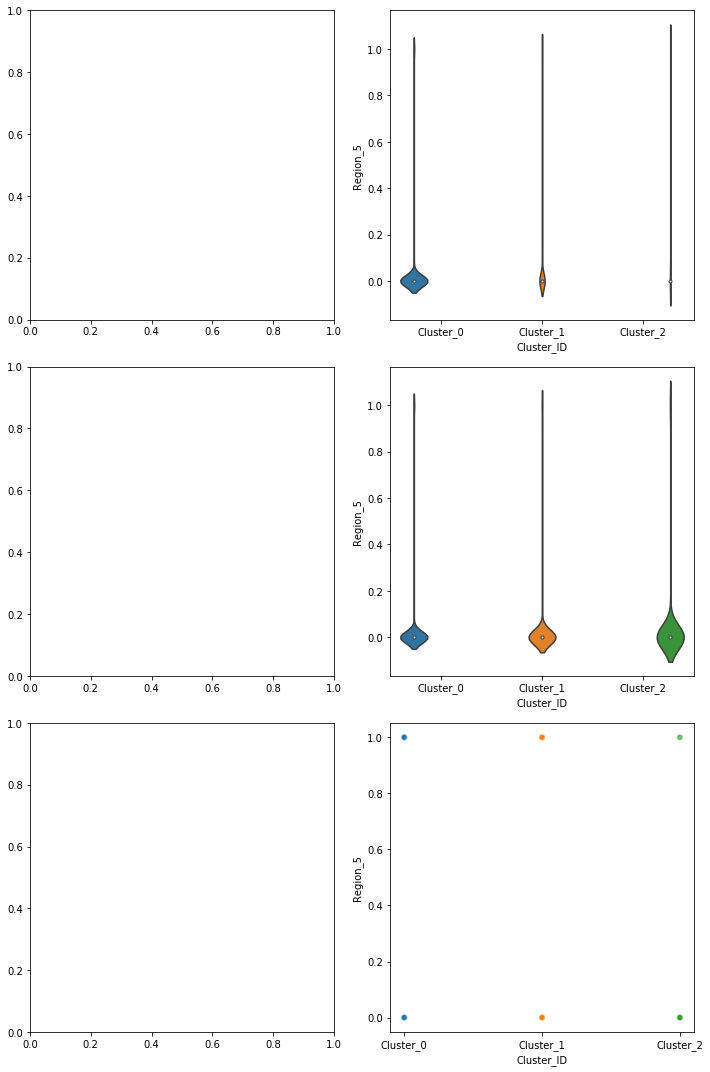

=========================== Region_6 ( uint8 ) ===========================


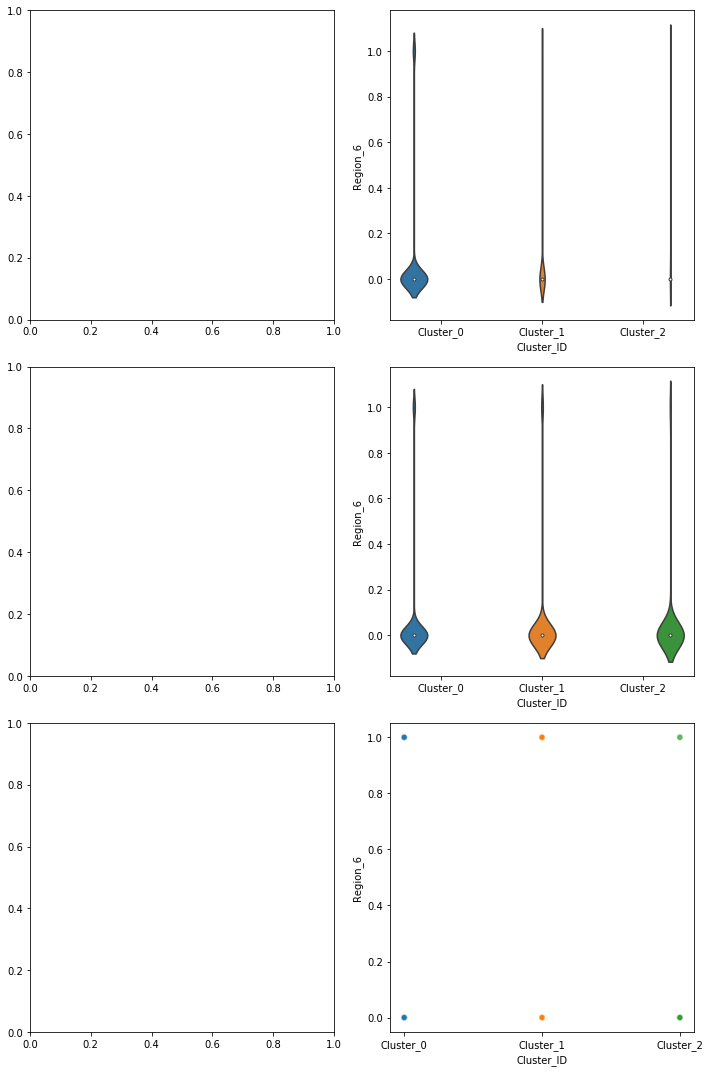

=========================== Region_7 ( uint8 ) ===========================


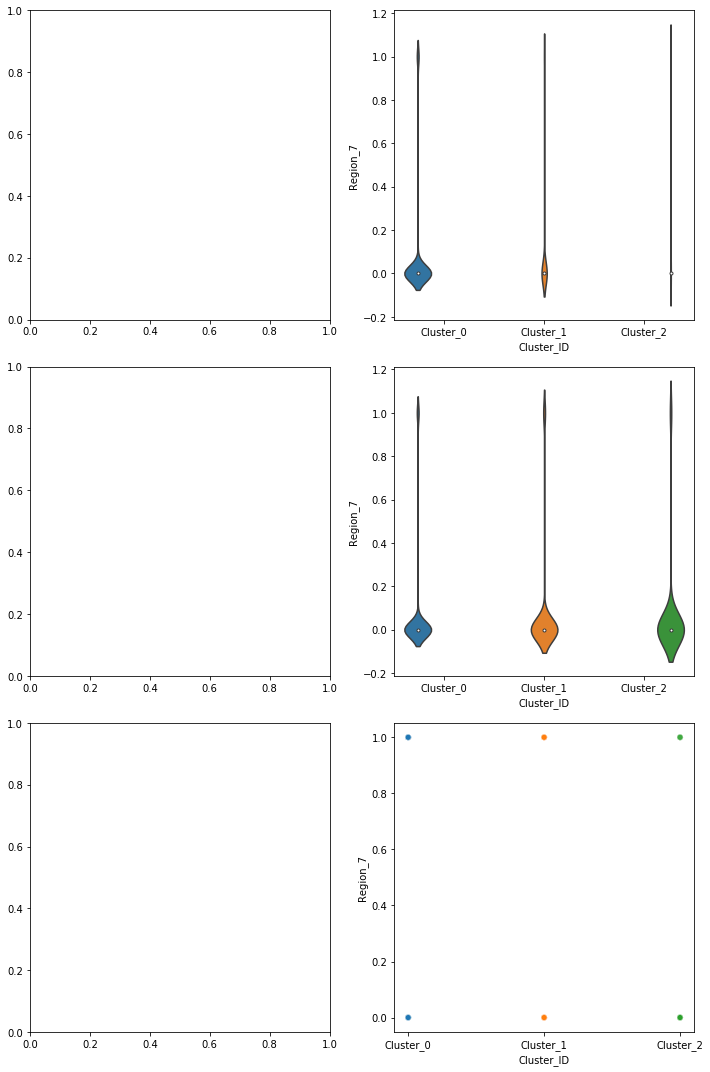

=========================== Region_8 ( uint8 ) ===========================


=========================== Region_9 ( uint8 ) ===========================


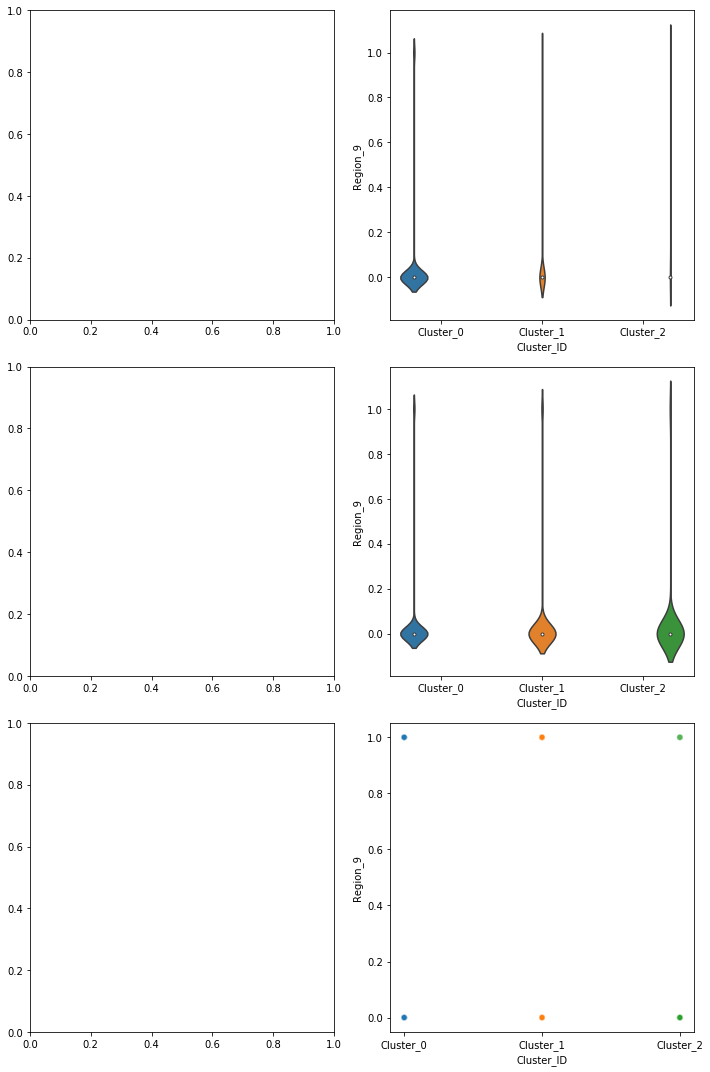

=========================== TrafficType_1 ( uint8 ) ===========================


=========================== TrafficType_2 ( uint8 ) ===========================


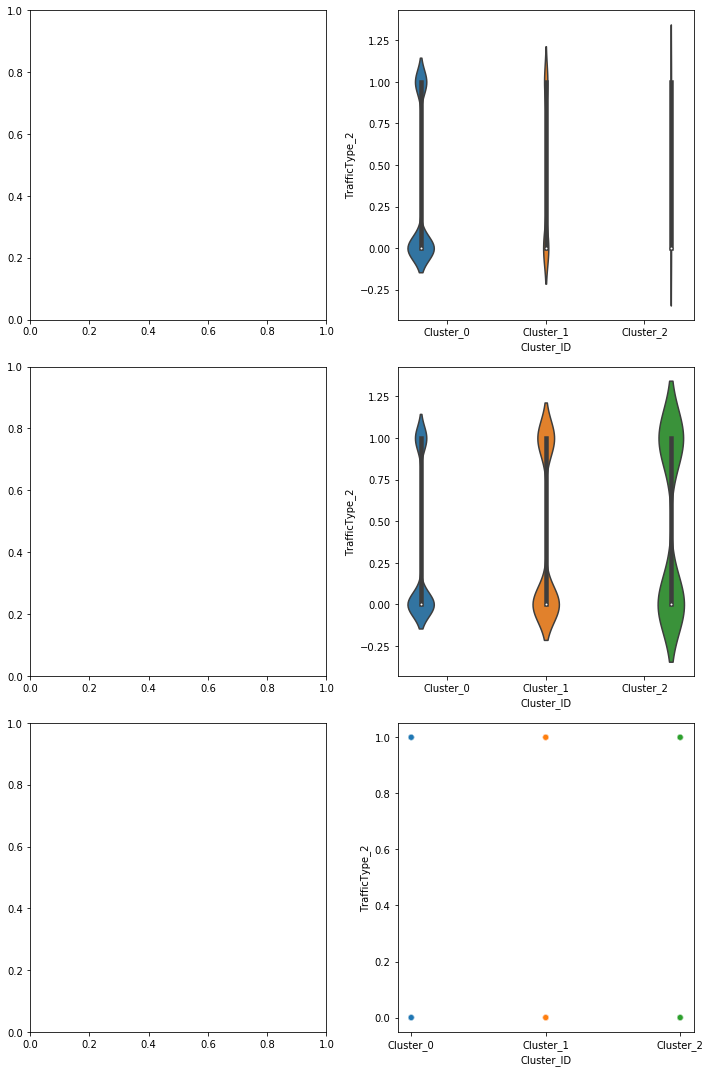

=========================== TrafficType_3 ( uint8 ) ===========================


=========================== TrafficType_4 ( uint8 ) ===========================


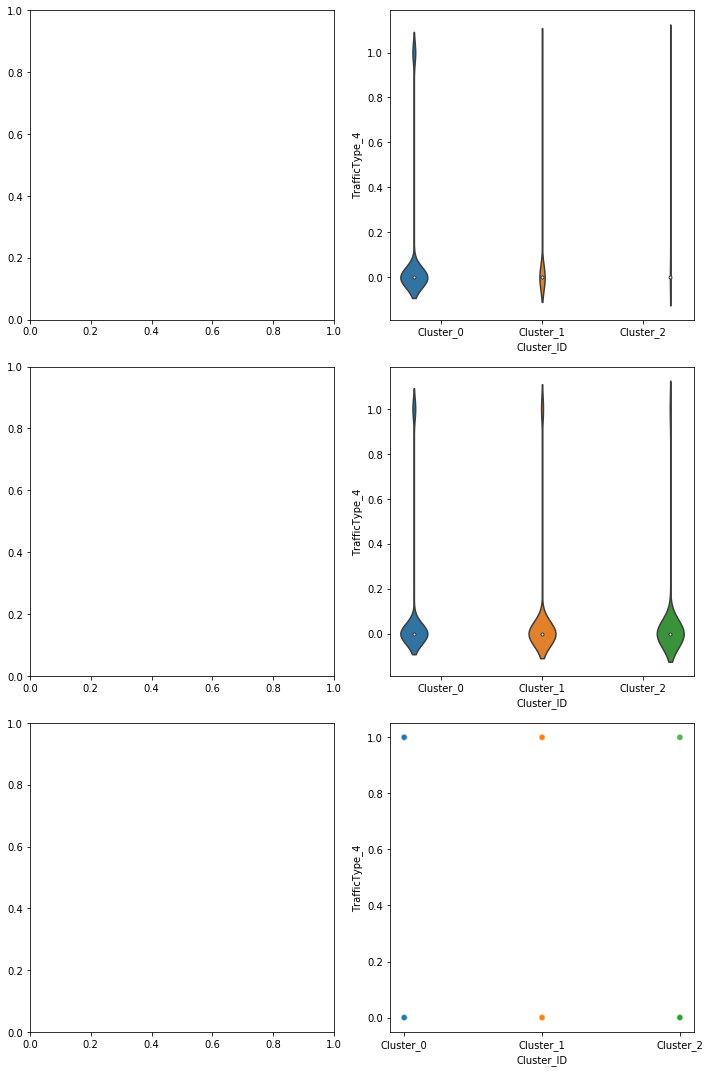

=========================== TrafficType_5 ( uint8 ) ===========================


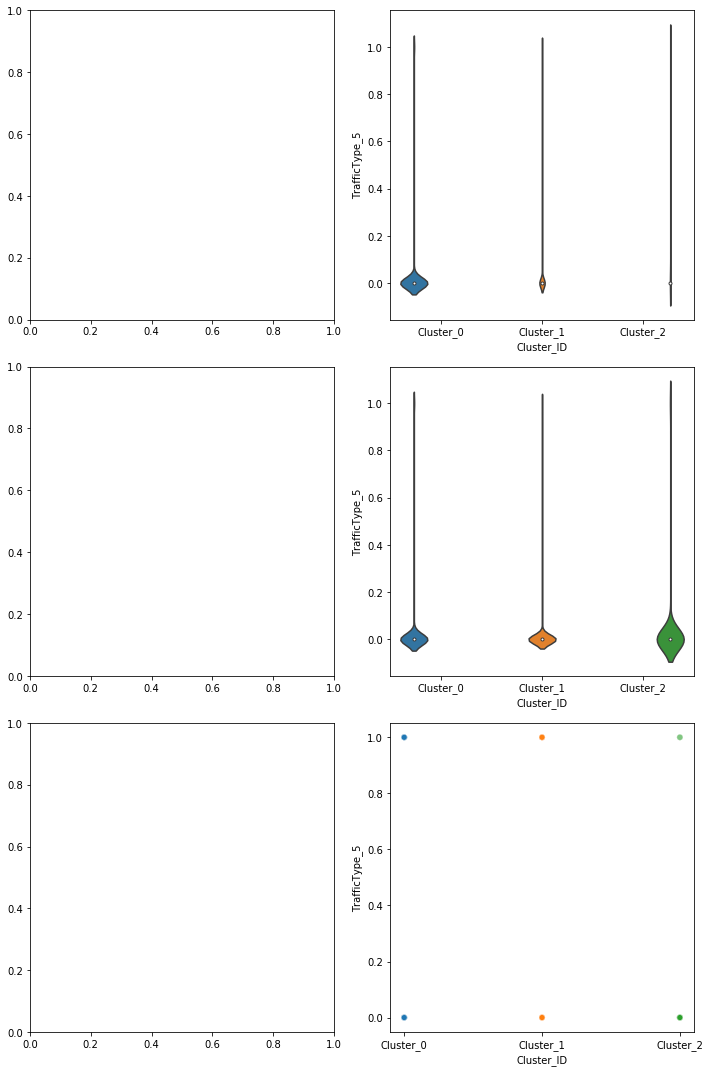

=========================== TrafficType_6 ( uint8 ) ===========================


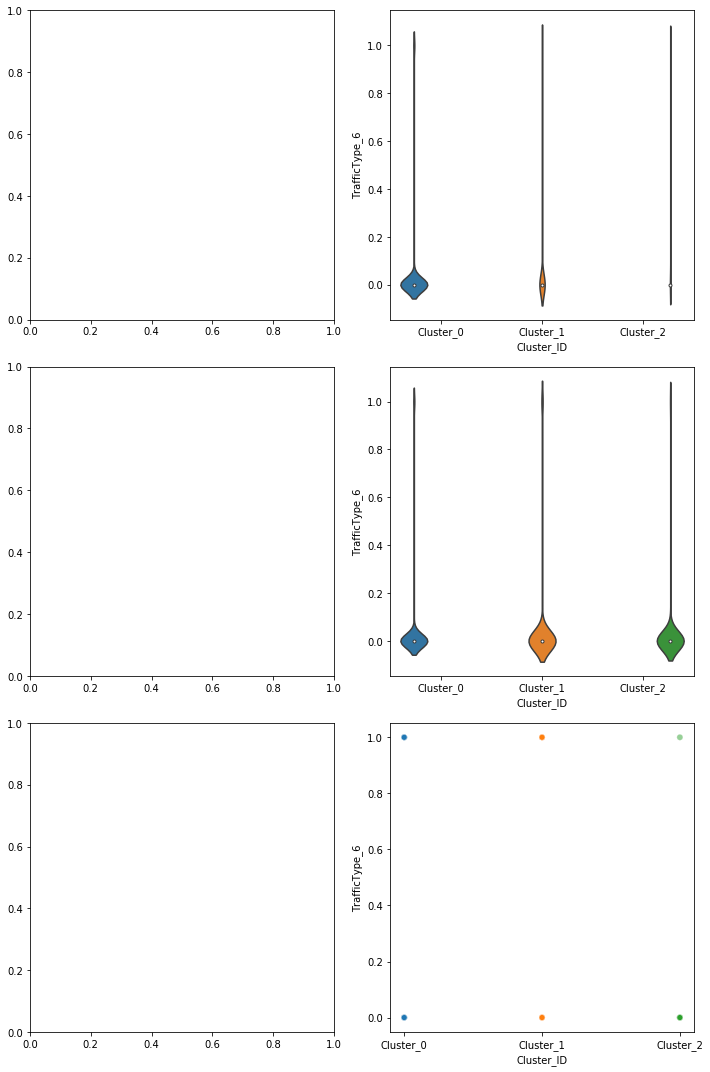

=========================== TrafficType_7 ( uint8 ) ===========================


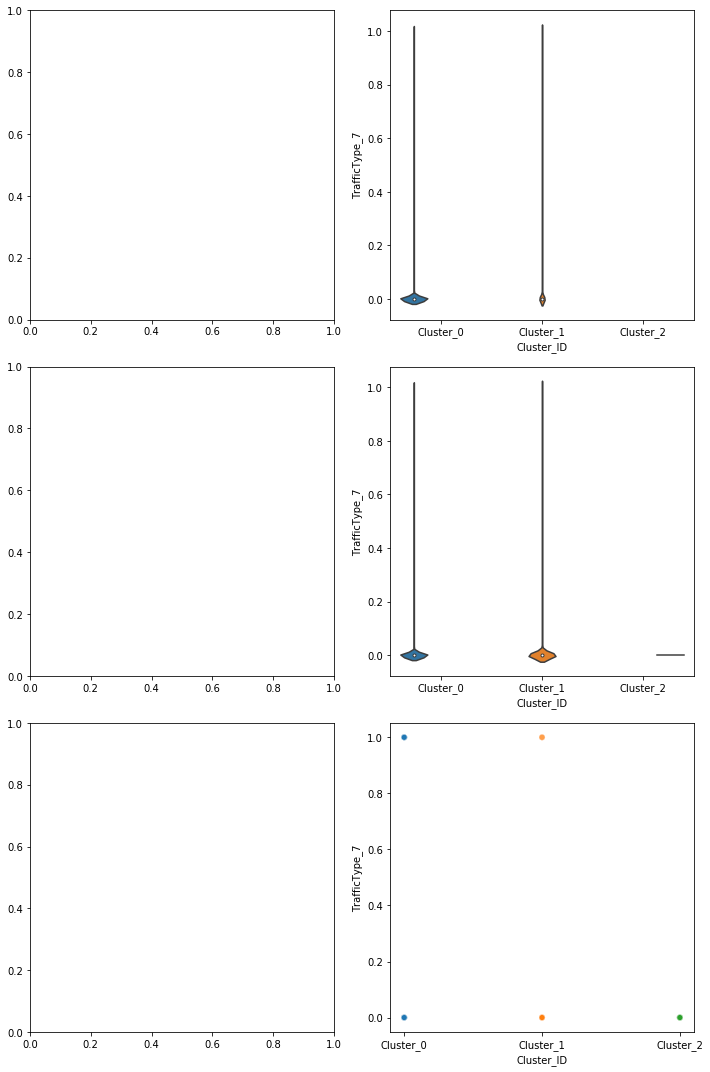

=========================== TrafficType_8 ( uint8 ) ===========================


=========================== TrafficType_9 ( uint8 ) ===========================


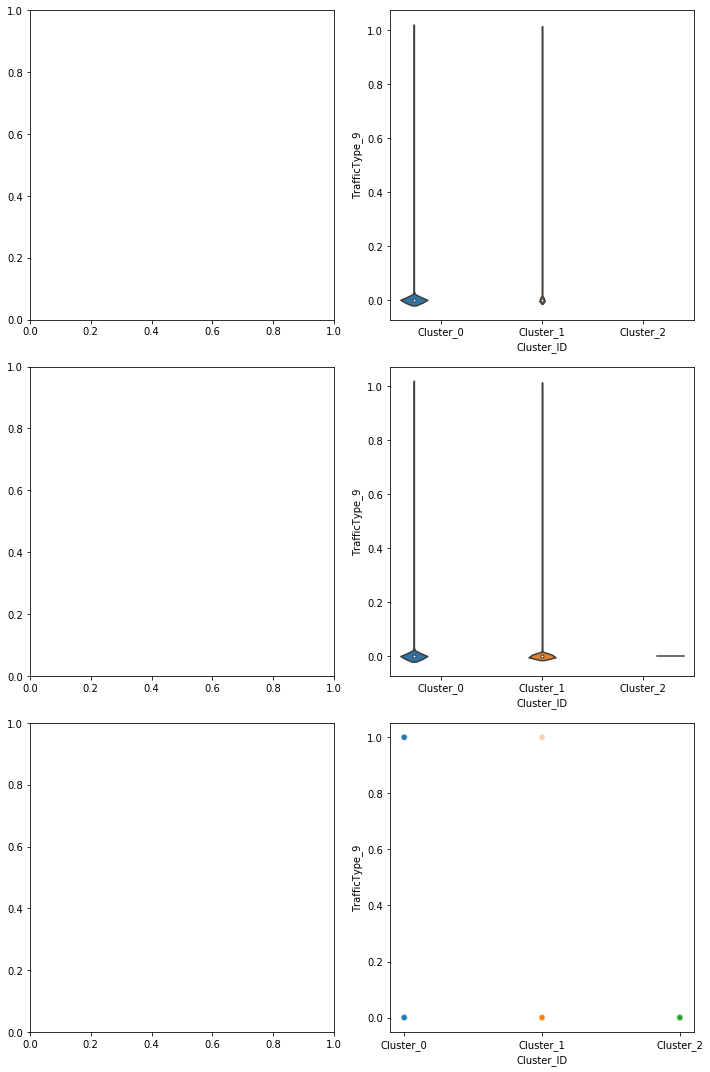

=========================== TrafficType_10 ( uint8 ) ===========================


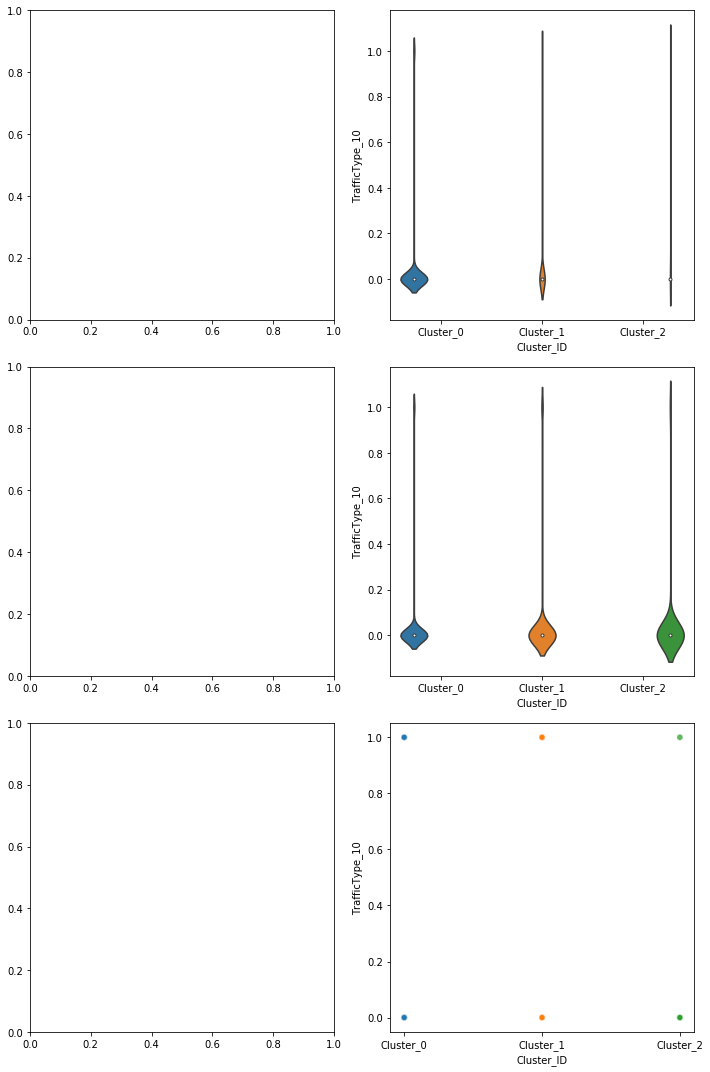

=========================== TrafficType_11 ( uint8 ) ===========================


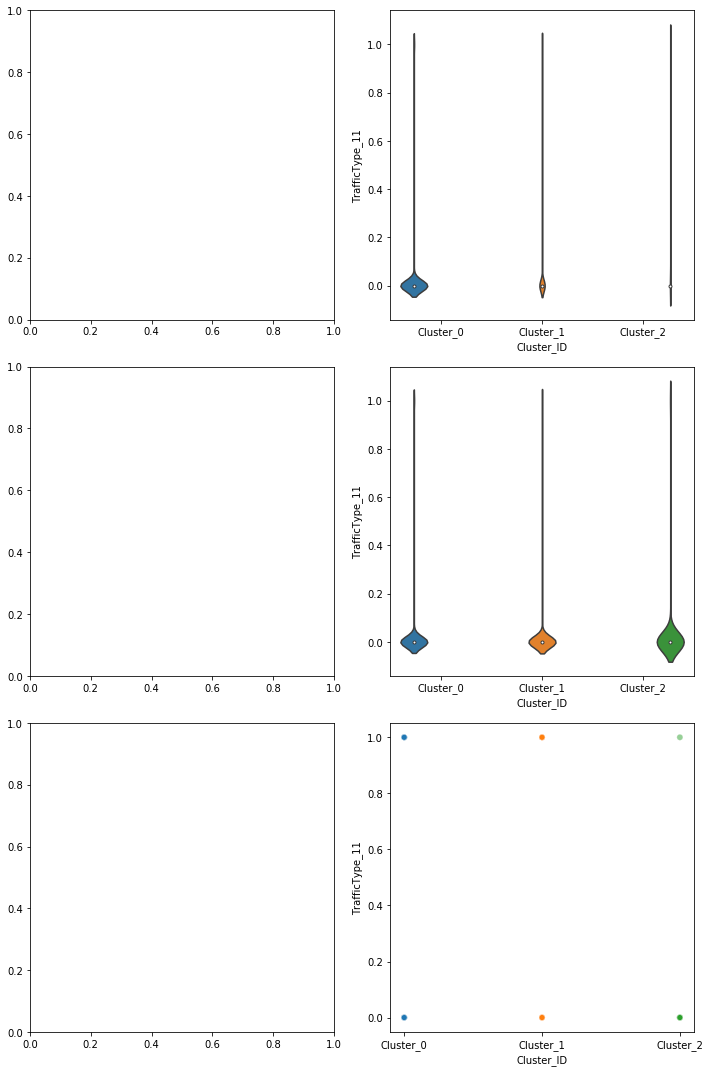

=========================== TrafficType_12 ( uint8 ) ===========================


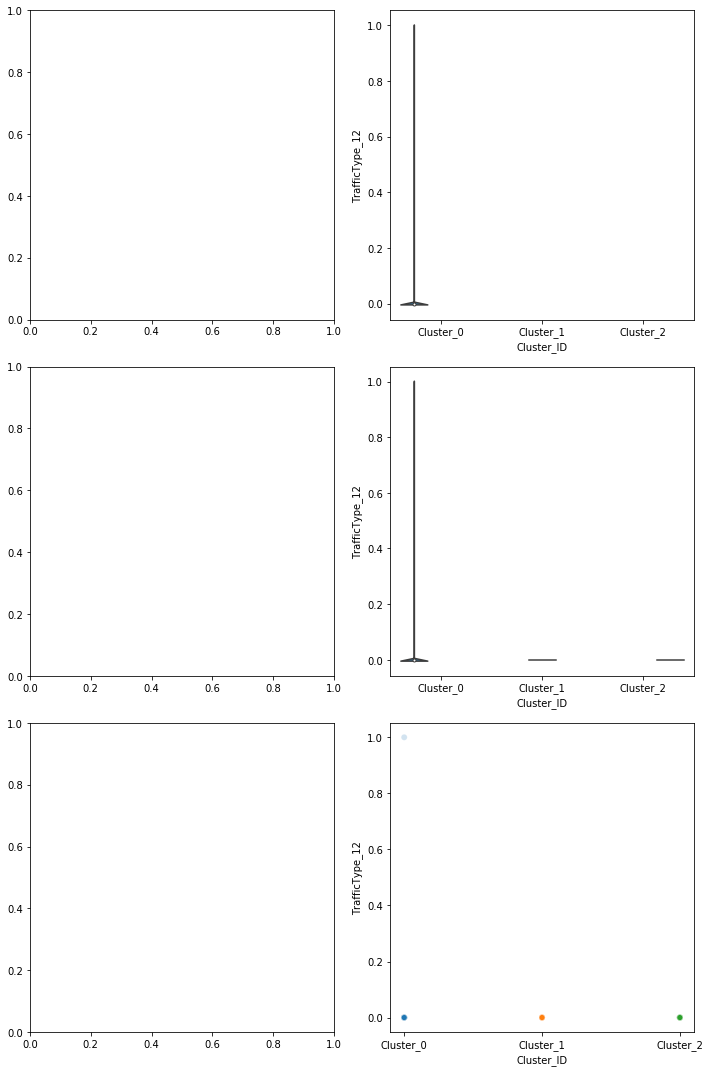

=========================== TrafficType_13 ( uint8 ) ===========================


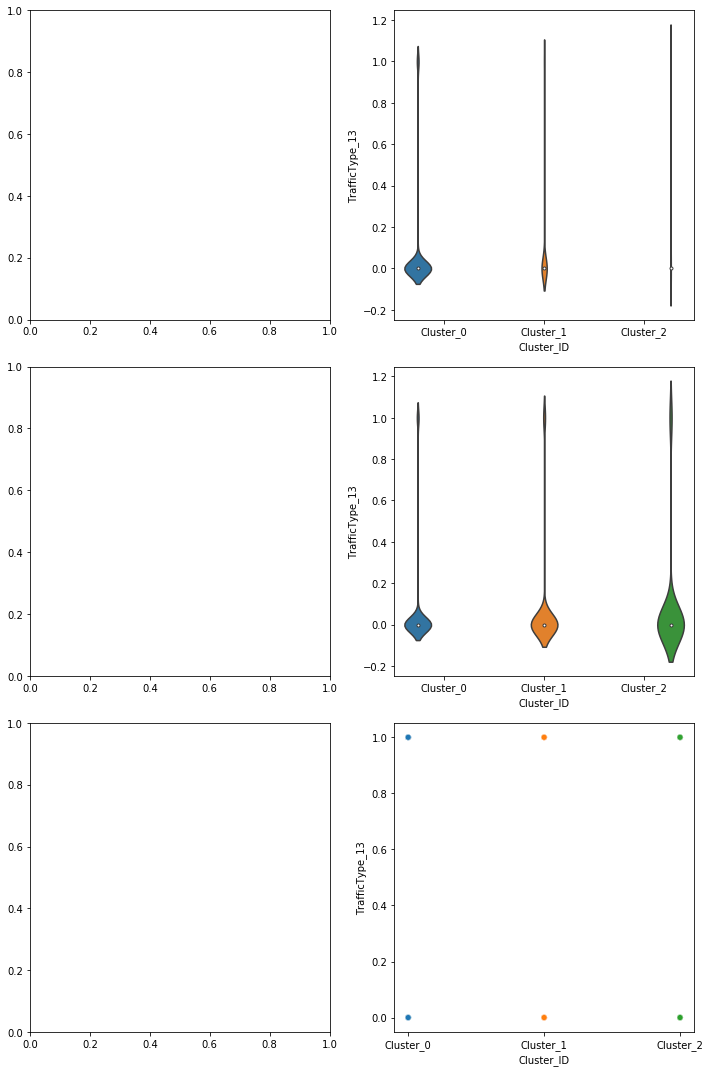

=========================== TrafficType_14 ( uint8 ) ===========================


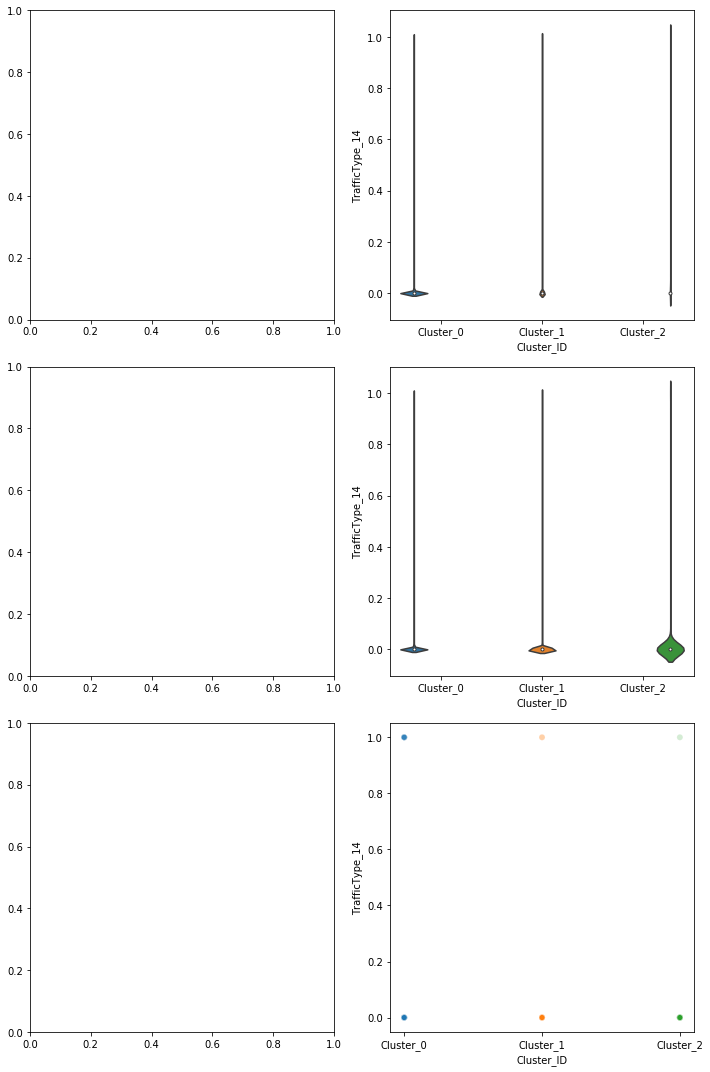

=========================== TrafficType_15 ( uint8 ) ===========================


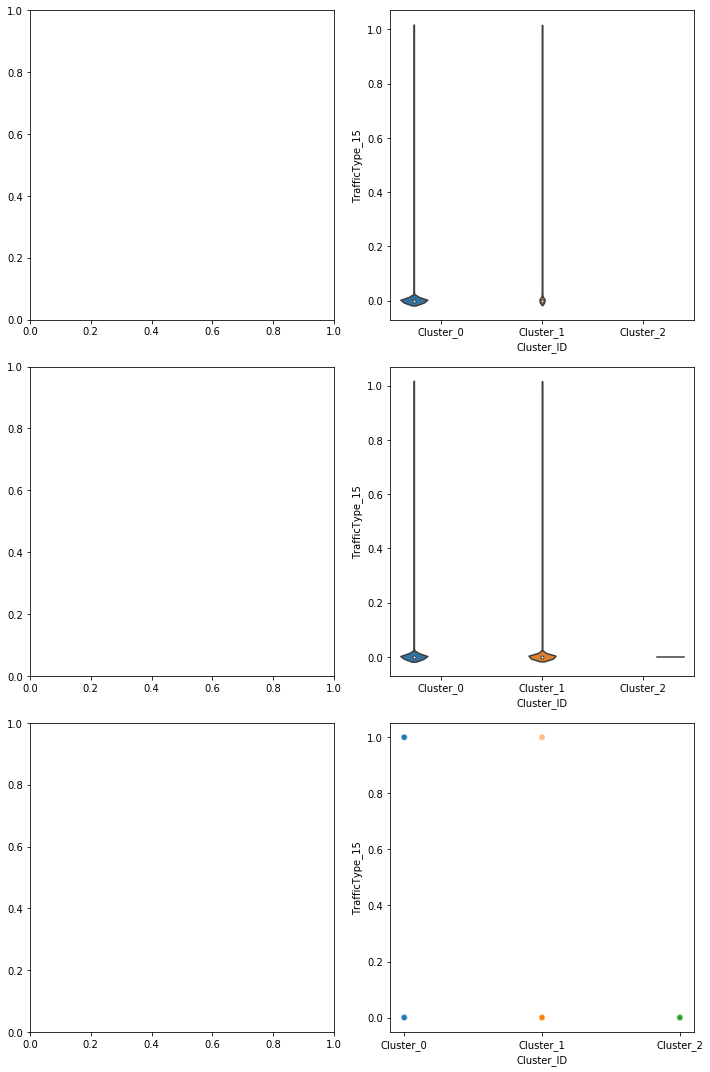

=========================== TrafficType_16 ( uint8 ) ===========================


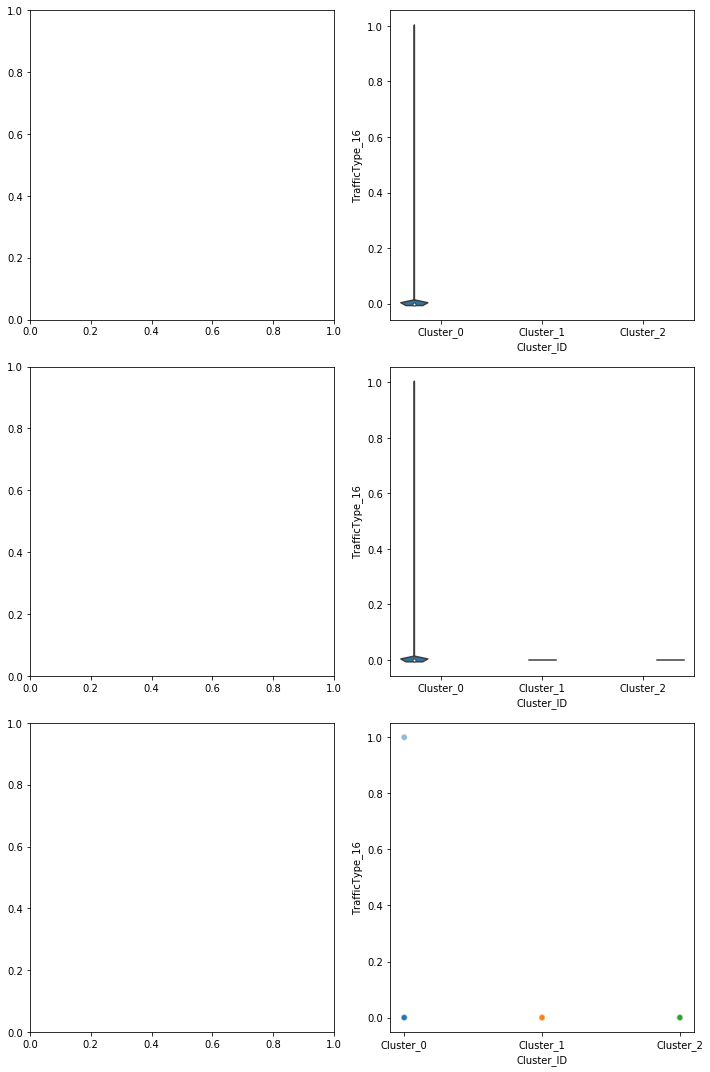

=========================== TrafficType_17 ( uint8 ) ===========================


=========================== TrafficType_18 ( uint8 ) ===========================


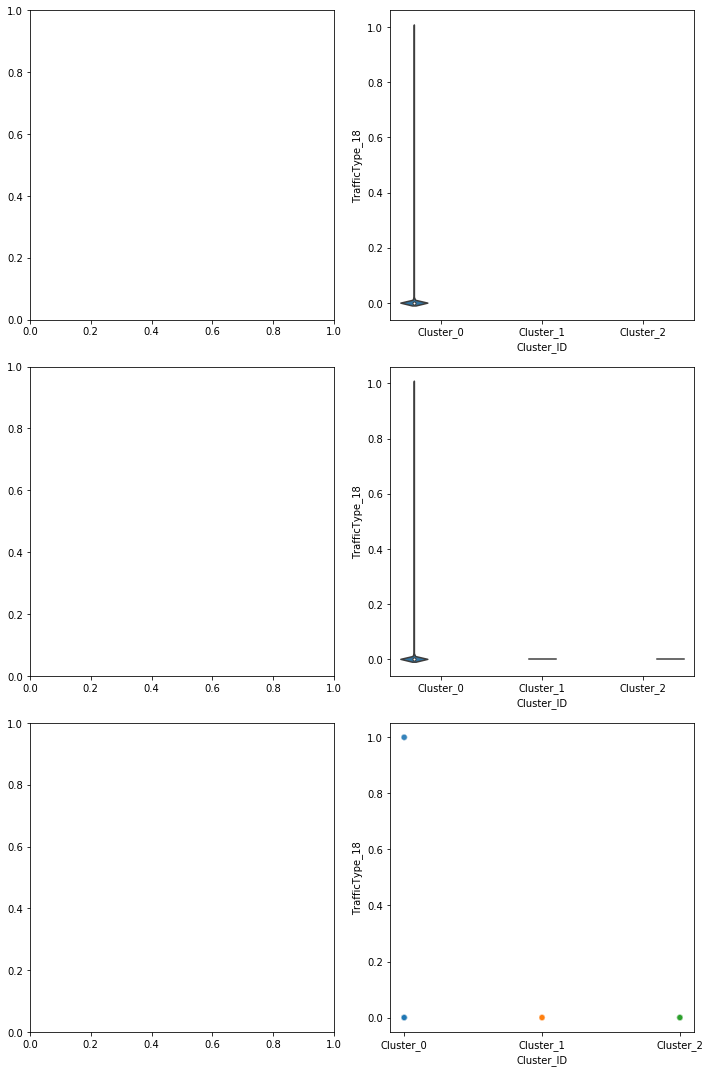

=========================== TrafficType_19 ( uint8 ) ===========================


=========================== TrafficType_20 ( uint8 ) ===========================


=========================== VisitorType_New_Visitor ( uint8 ) ===========================


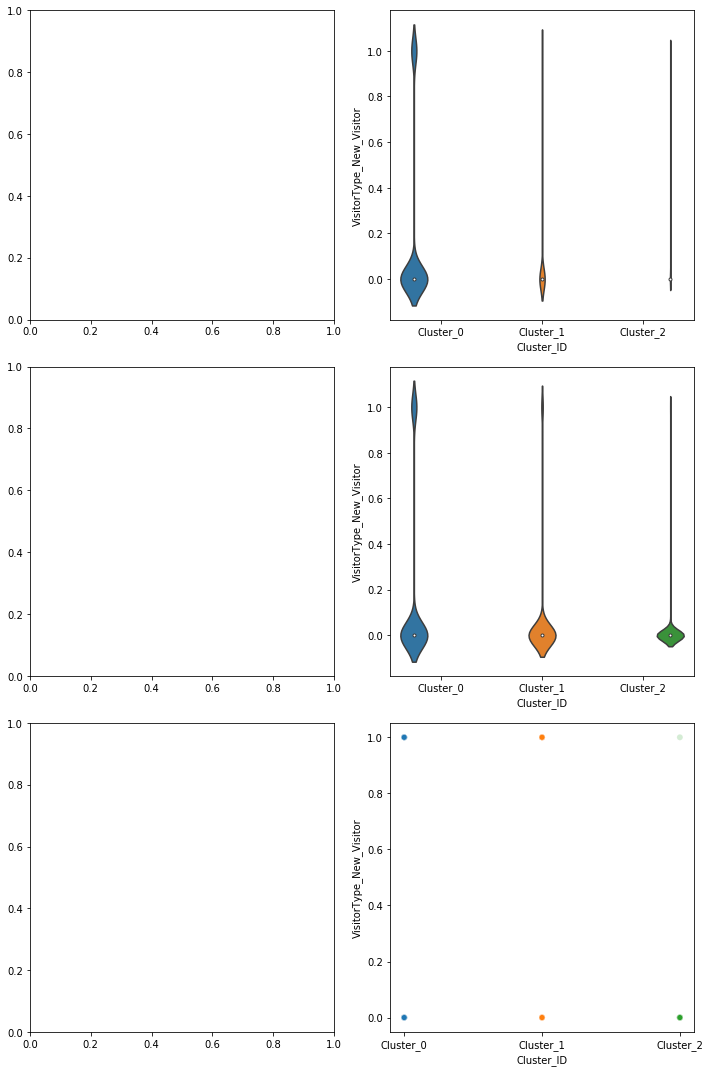

=========================== VisitorType_Other ( uint8 ) ===========================


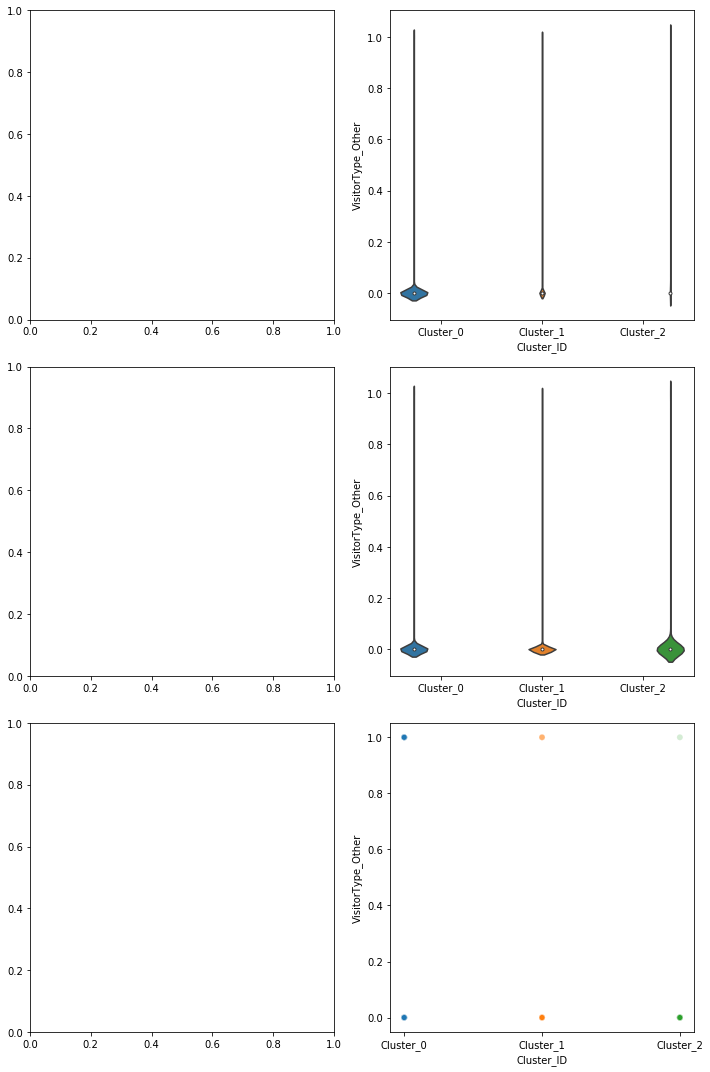

=========================== VisitorType_Returning_Visitor ( uint8 ) ===========================


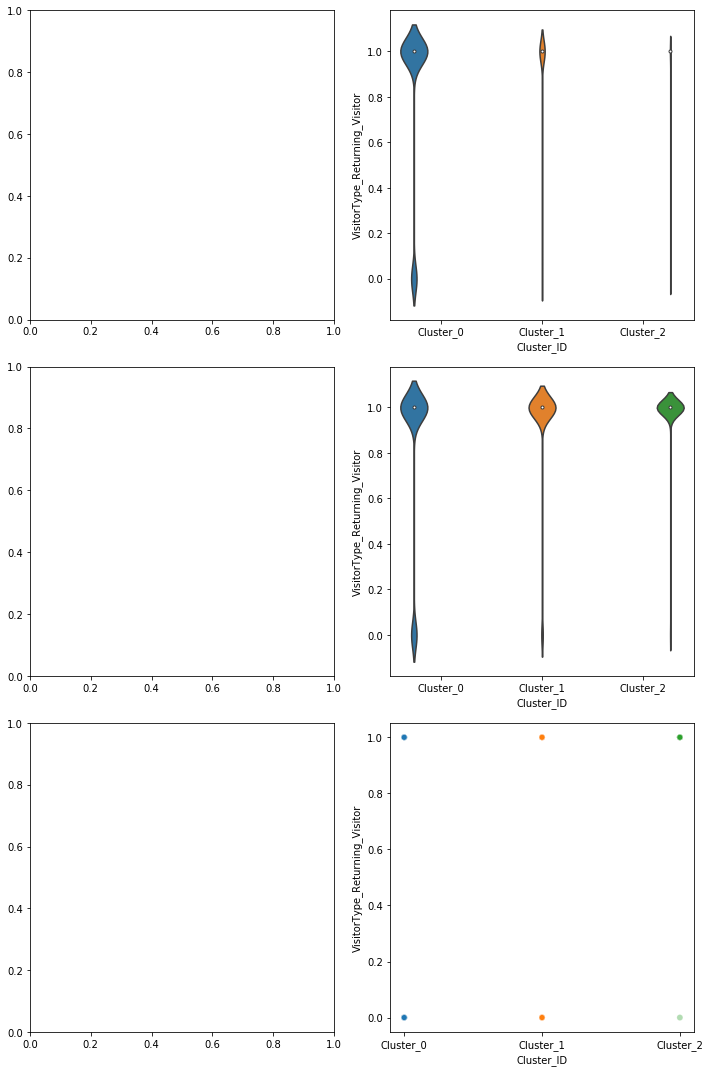

=========================== Weekend_False ( uint8 ) ===========================


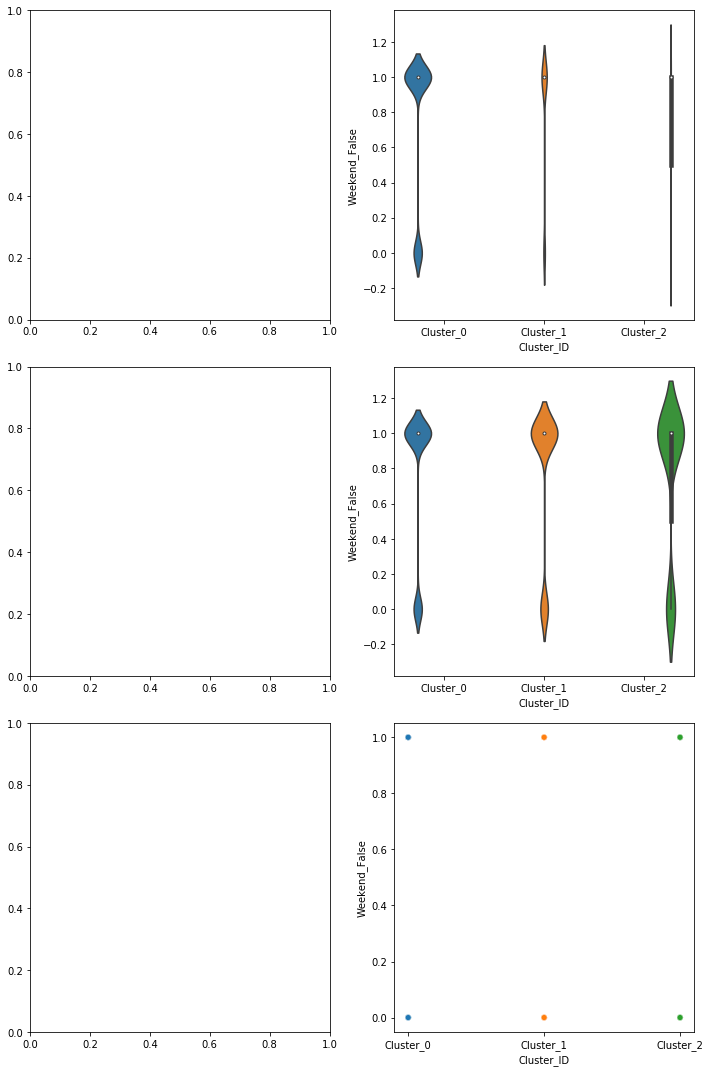

=========================== Weekend_True ( uint8 ) ===========================


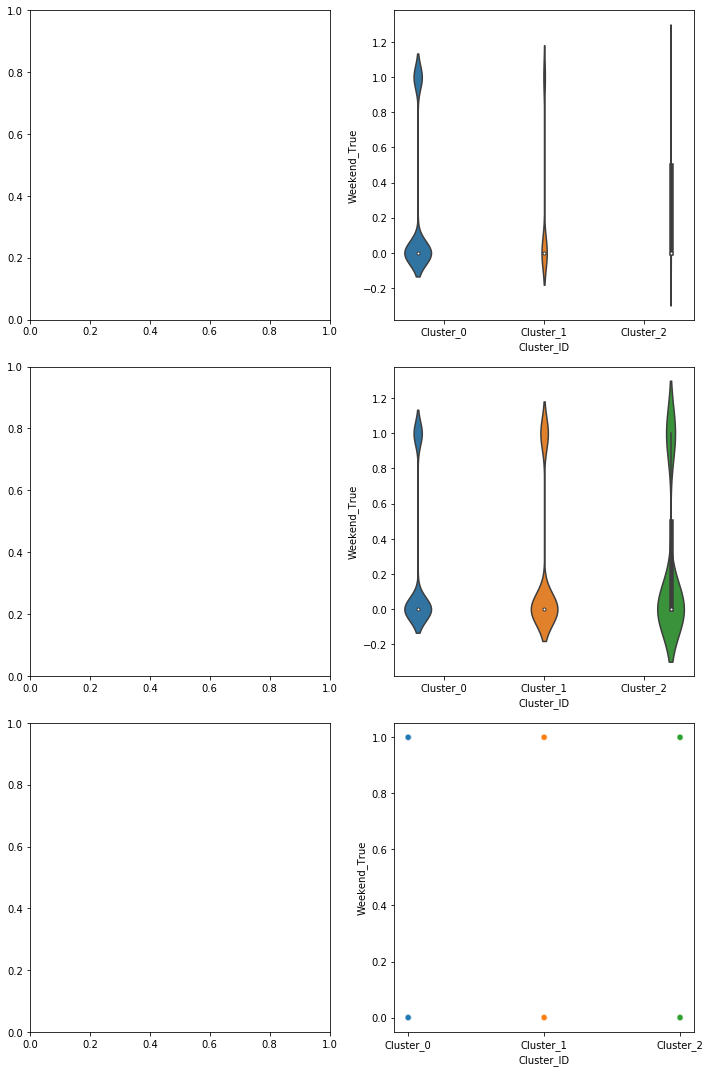

=========================== Revenue_False ( uint8 ) ===========================


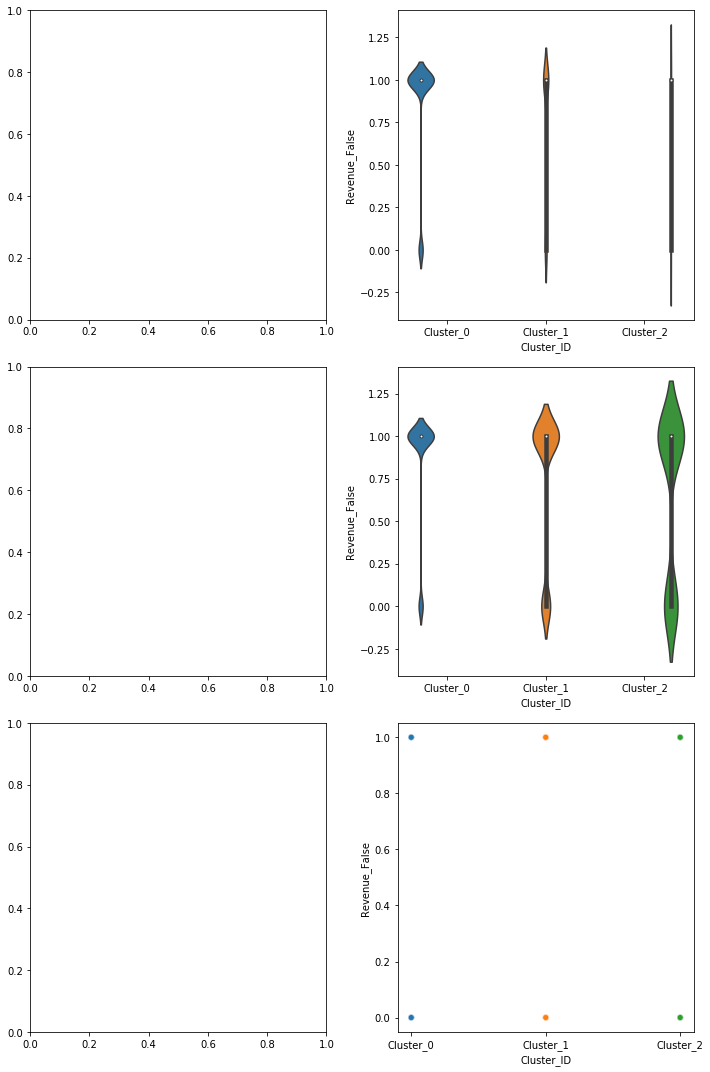

=========================== Revenue_True ( uint8 ) ===========================


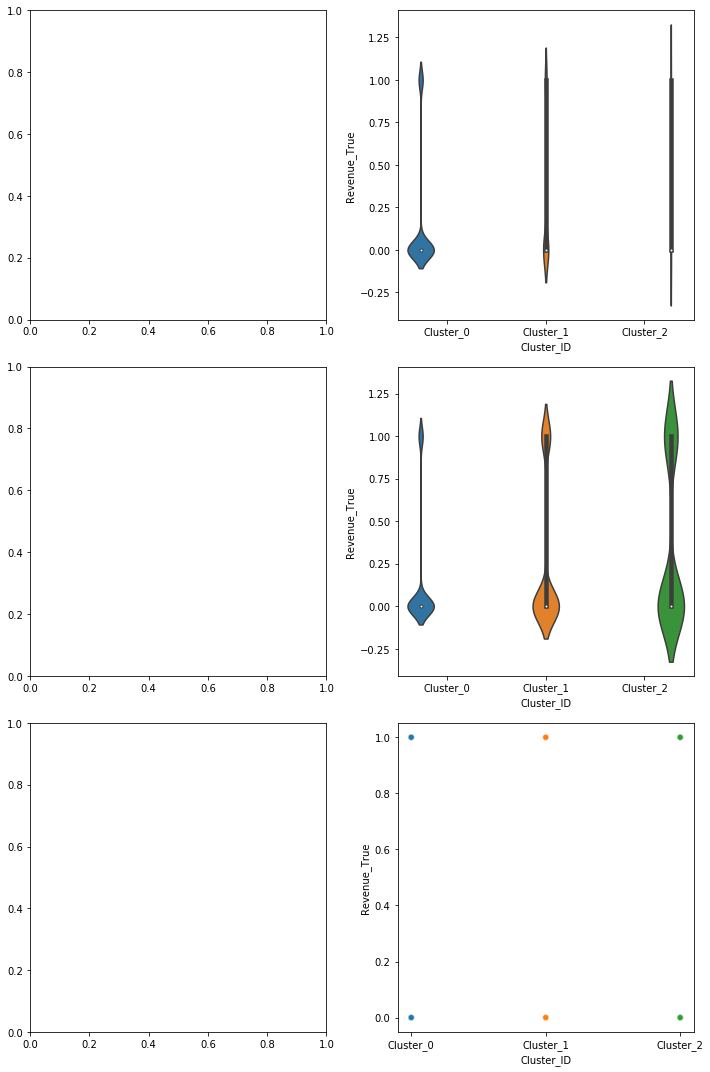

In [60]:
# In the first row the width of the voilin represent the count.
# And, in the second row, the width is the density.
df_1_WithID, df_2_WithID = CompareVisualization(taskTwoDf, clusters[1], taskThreeDf, refinedClusters[1], taskThreeDf.columns )

In [61]:
sum(df_1_WithID['Cluster_ID'] != df_2_WithID['Cluster_ID'])
# The cluster 1 is the same as cluster 2 

0

### b. Whether this model has different variable importance than the previous model (Task 2.1)? 



From the above volin plot and the Cluster_ID, we found that the cluster result didn't change at all. However, some other features are introduced into the model, which can help the model to seperate the instances. Administrative, Informational, ProductRelated, BounceRates, ExitRates, PageValues, Month_Feb, Month_May Month_Nov and VisitorType are important variables that can help the clustering model to seperate the instances to three different groups. However, some features do not provide meaningful information, such as SpecialDay, OperatingSystems, Browser, Region, TrafficType, Weekend, Revenue. This kind of feature has similar violin shapes across the clusters. And the difference among three clusters in these features is only the size. Since the cluster_2 has a larger cluster size, it usually has a larger violin shape. 



### c. Explain the cluster results

In [62]:
displayClusterResult(refinedClusters[1])

The k = 3 clustering model seperate all the observations to 3 clusters. Cluster 1 is the largest cluster, which consists of  10101 objects. And the the Cluster 2 is the samllest cluster, which only own  207 objects. The Sum of squared distance of objects to their closest centroids is  13224220606.163054 . Moreover, to get this result, the model runs 20 iteration.
Centriods:
 [[4.32506329e+00 1.54877478e+02 1.17417722e+00 8.46726198e+01
  7.77296203e+01 3.35510746e+03 7.12823371e-03 2.16705571e-02
  8.01363406e+00 5.07341772e-02]
 [1.82773983e+00 6.23156040e+01 3.28581329e-01 2.00548027e+01
  1.86893377e+01 5.79214935e+02 2.49006960e-02 4.71746460e-02
  5.52932368e+00 6.42708643e-02]
 [7.43961353e+00 2.95364891e+02 2.74879227e+00 2.66723094e+02
  2.36106280e+02 1.08861744e+04 5.93975560e-03 1.96883098e-02
  4.52137028e+00 3.09178744e-02]]


## 2. What is the effect of using the standardization method on the model above? Does the variable normalization process enable a better clustering solution?

/home/chihcheng/python3env/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/chihcheng/python3env/lib/python3.6/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


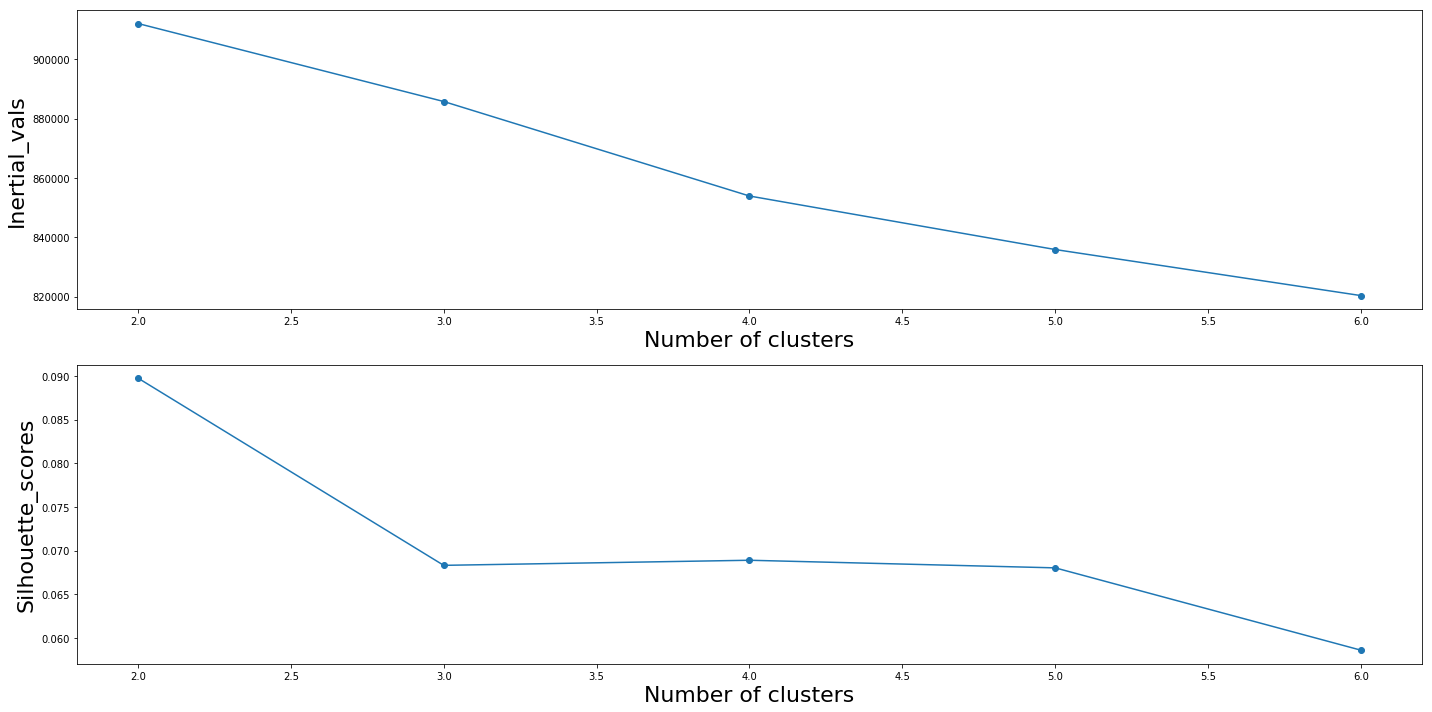

In [70]:
scaler = StandardScaler()

# TODO: should we standardise the categorial data?

taskThreeDf_Standardised = scaler.fit_transform(taskThreeDf)
taskThreeDf_Standardised = pd.DataFrame(taskThreeDf_Standardised, columns= taskThreeDf.columns)


refinedClusters_Standardised = ElbowEffectAndSilhouetteScore(taskThreeDf_Standardised, range(2,7), )

From the above Elbow effect plot, we can see that the elbow become more unclear. It become very hard to point out the Elbow. However, from the Slihouette scores, the score drop dramatically at the k = 5. Therefore, this may affect the decsion of k. The k = 4 may be a better choice in this stadardised case. However, in order to compare the results, we will stil using k = 3.

(1) Value counts: 
 Cluster_0    10101
Cluster_1     1975
Cluster_2      207
Name: Cluster_ID, dtype: int64
(2) Value counts: 
 Cluster_0    7880
Cluster_1    2373
Cluster_2    2030
Name: Cluster_ID, dtype: int64
=========================== Administrative ( float64 ) ===========================


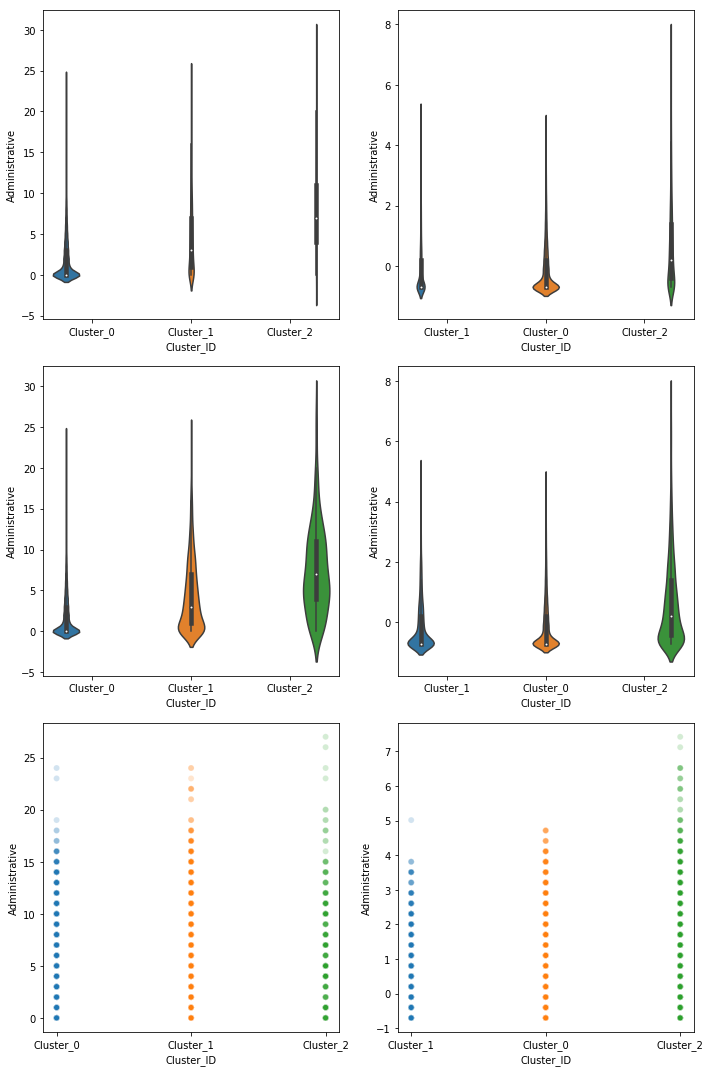

=========================== Administrative_Duration ( float64 ) ===========================


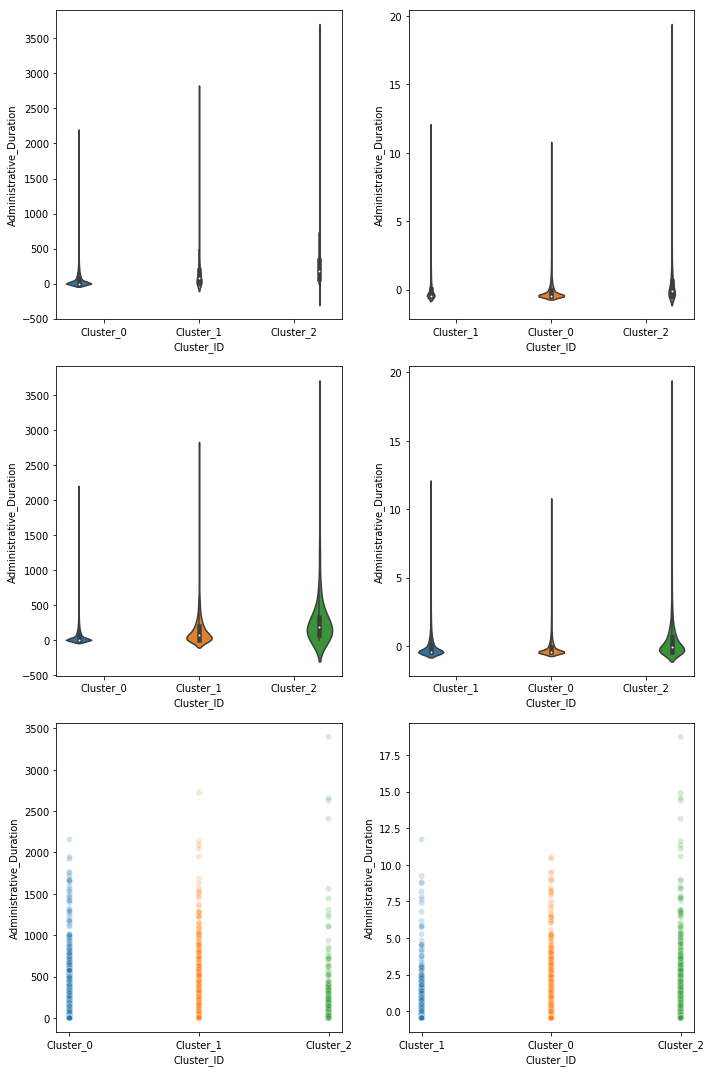

=========================== Informational ( float64 ) ===========================


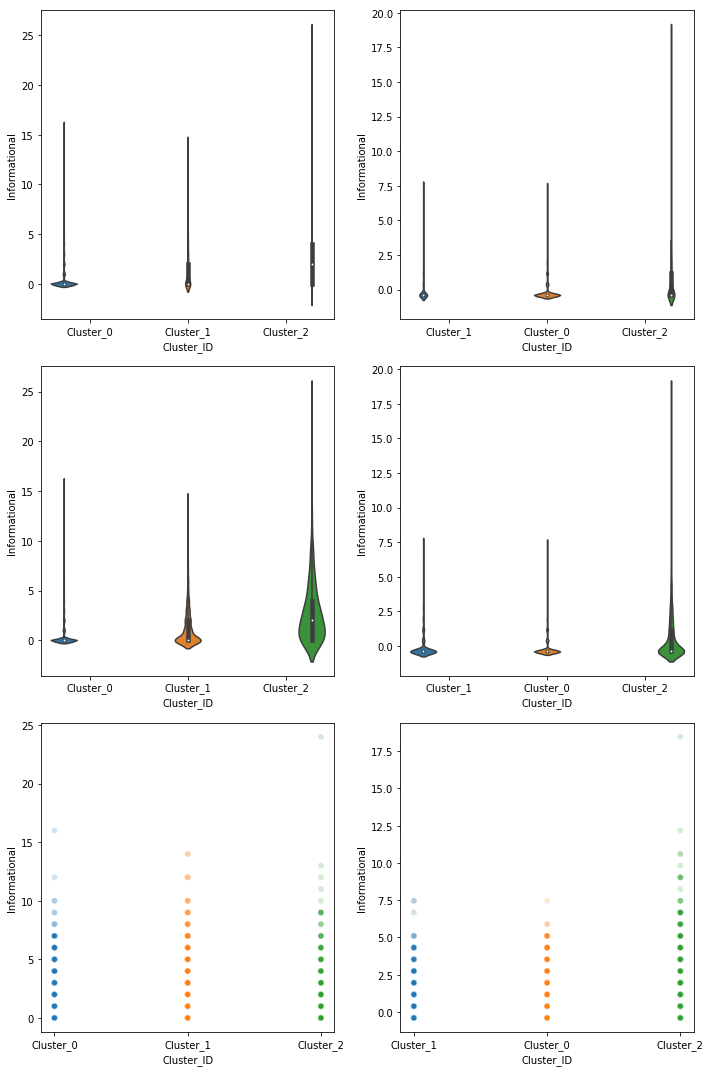

=========================== Informational_Duration ( float64 ) ===========================


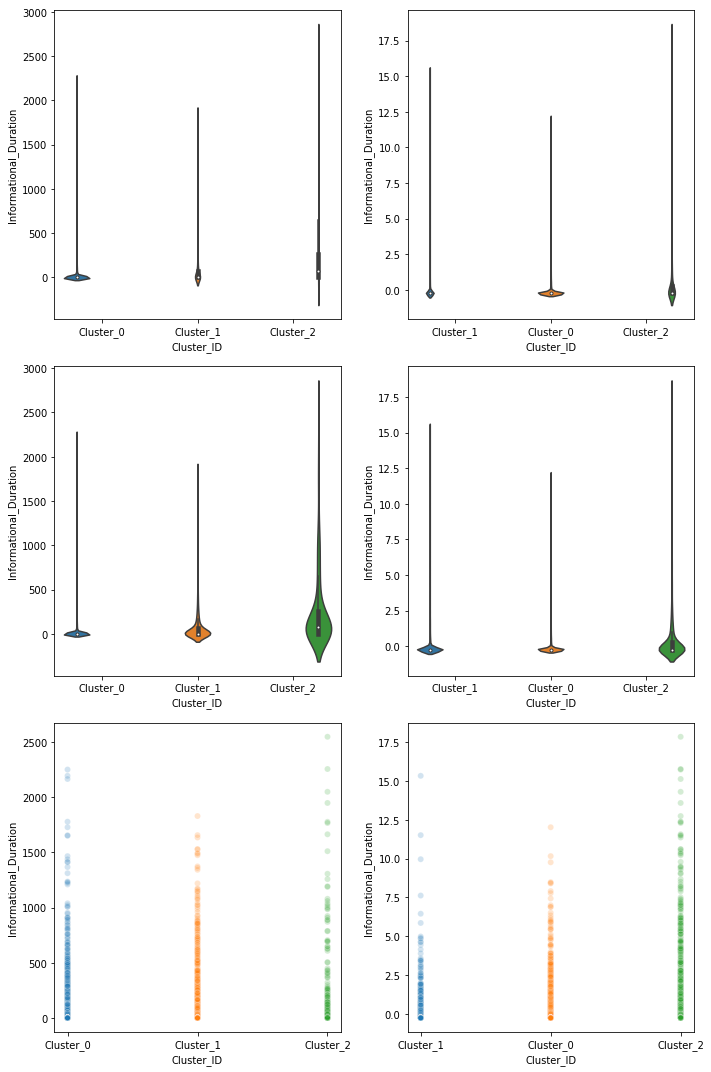

=========================== ProductRelated ( float64 ) ===========================


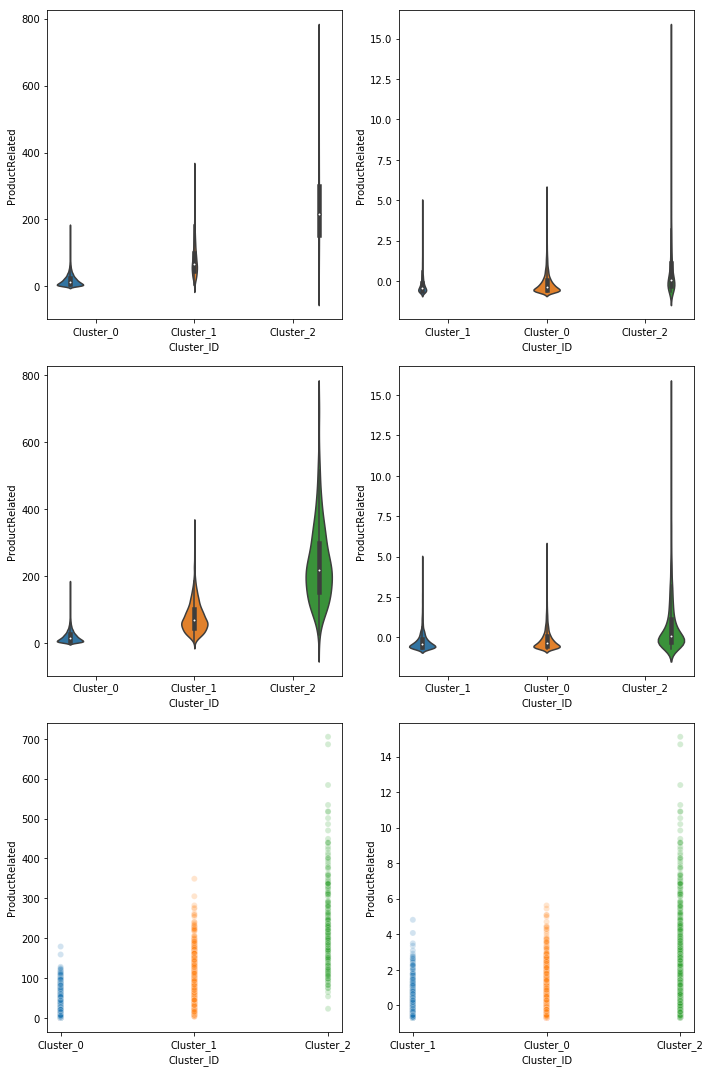

=========================== ProductRelated_Duration ( float64 ) ===========================


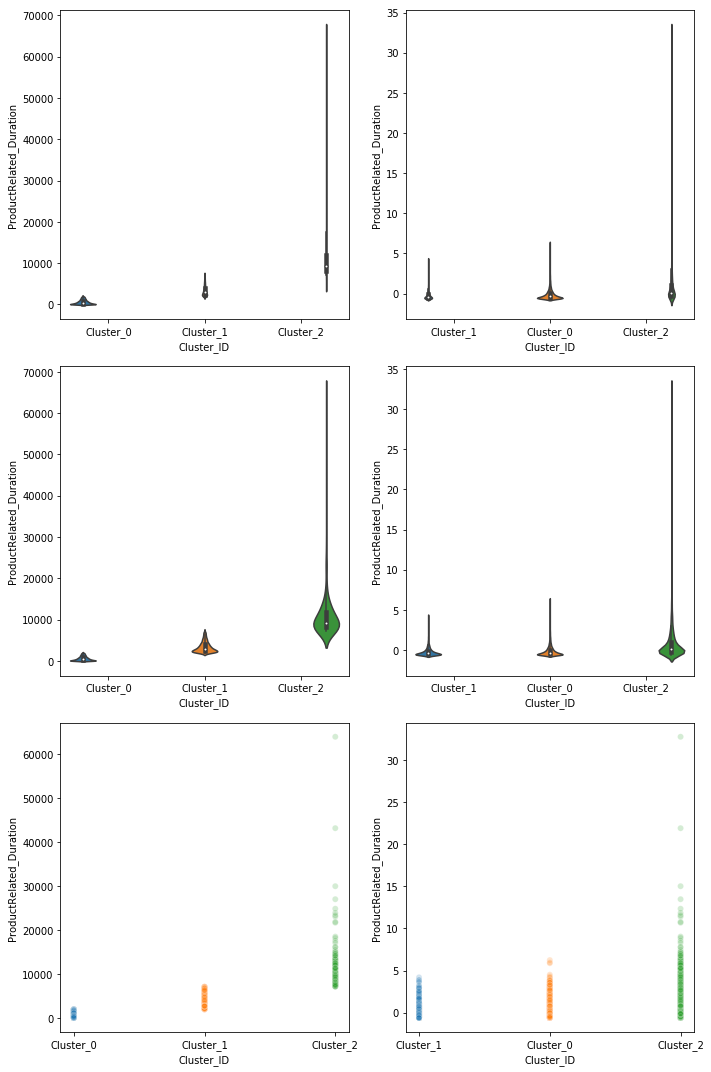

=========================== BounceRates ( float64 ) ===========================


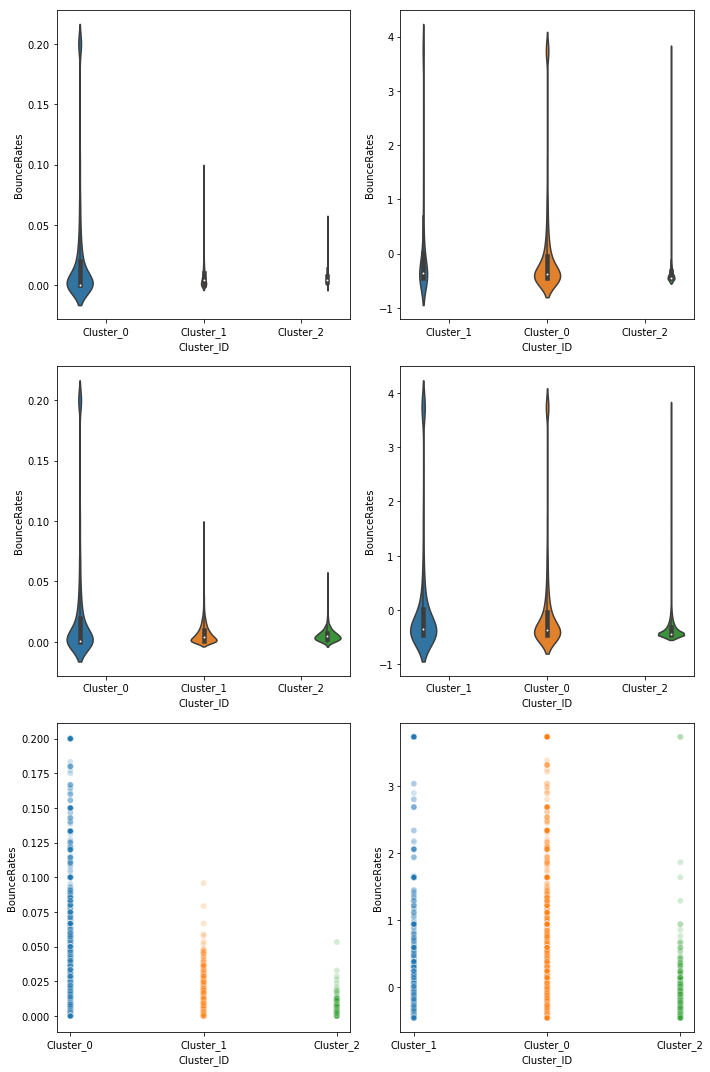

=========================== ExitRates ( float64 ) ===========================


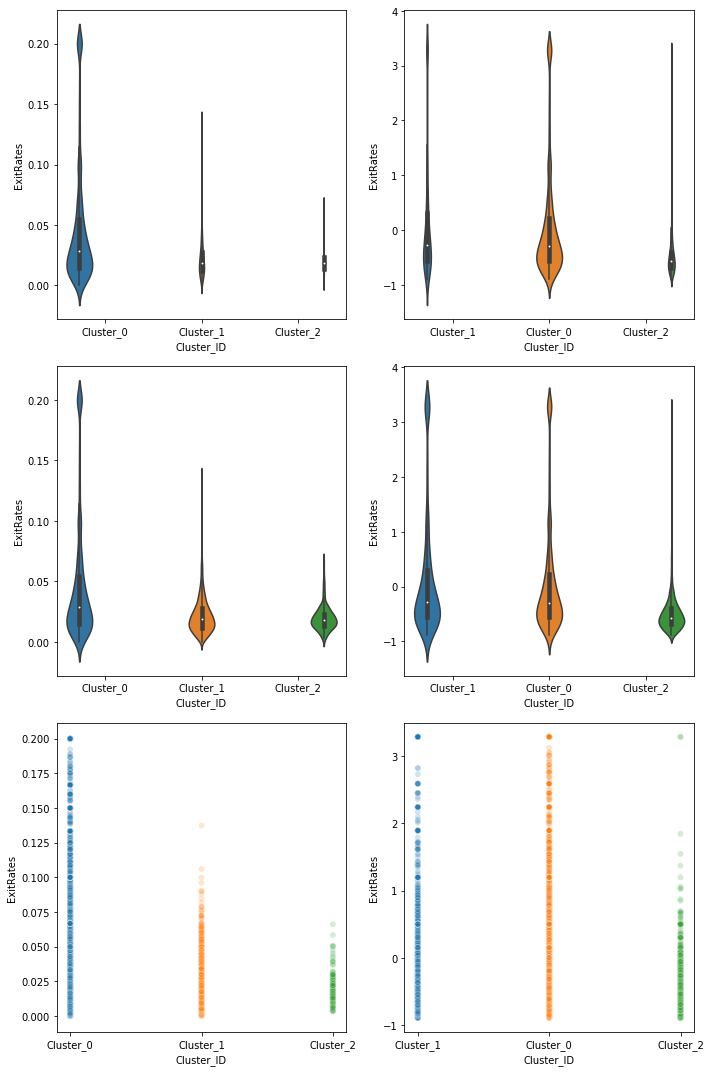

=========================== PageValues ( float64 ) ===========================


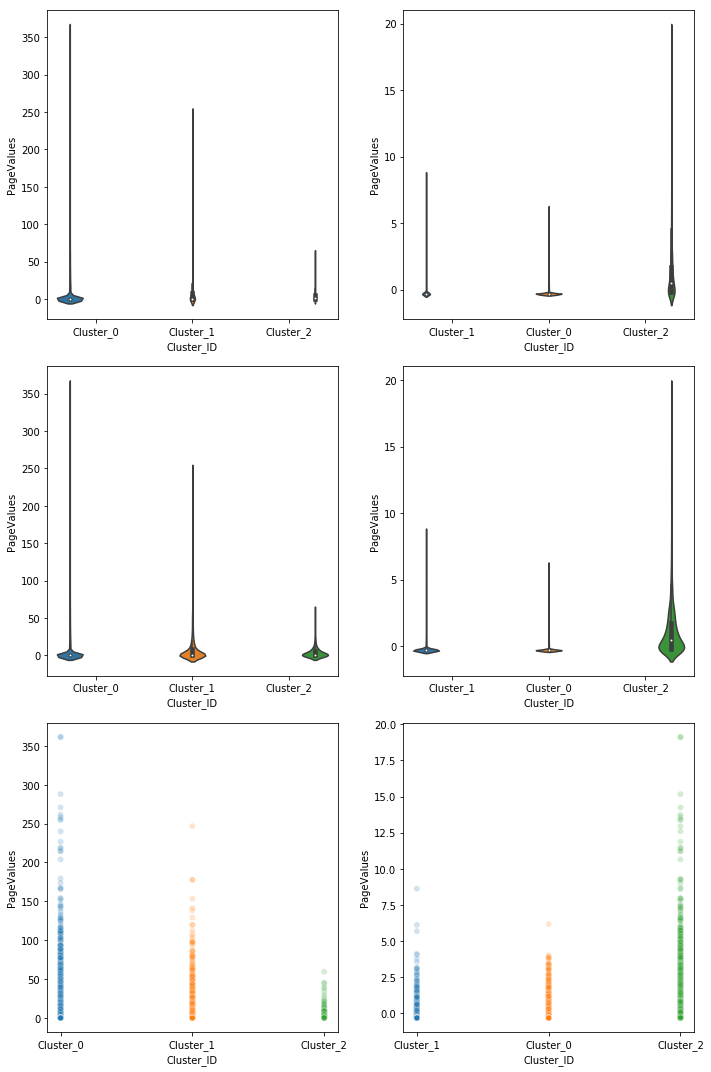

=========================== SpecialDay ( float64 ) ===========================


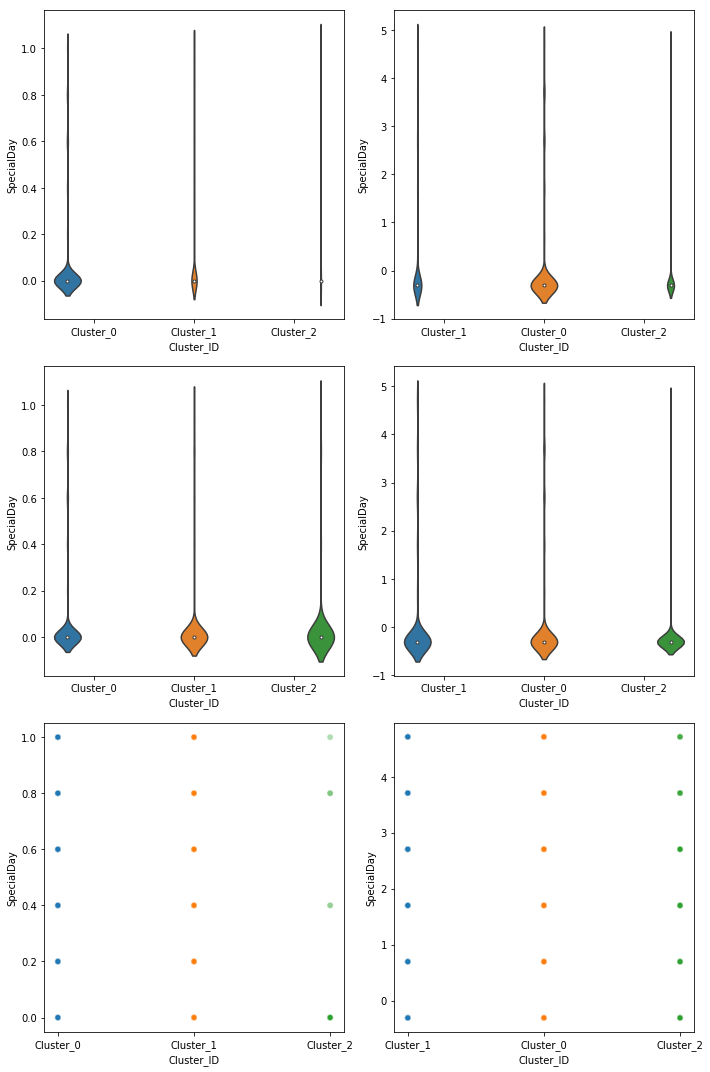

=========================== Month_Aug ( uint8 ) ===========================


=========================== Month_Dec ( uint8 ) ===========================


=========================== Month_Feb ( uint8 ) ===========================


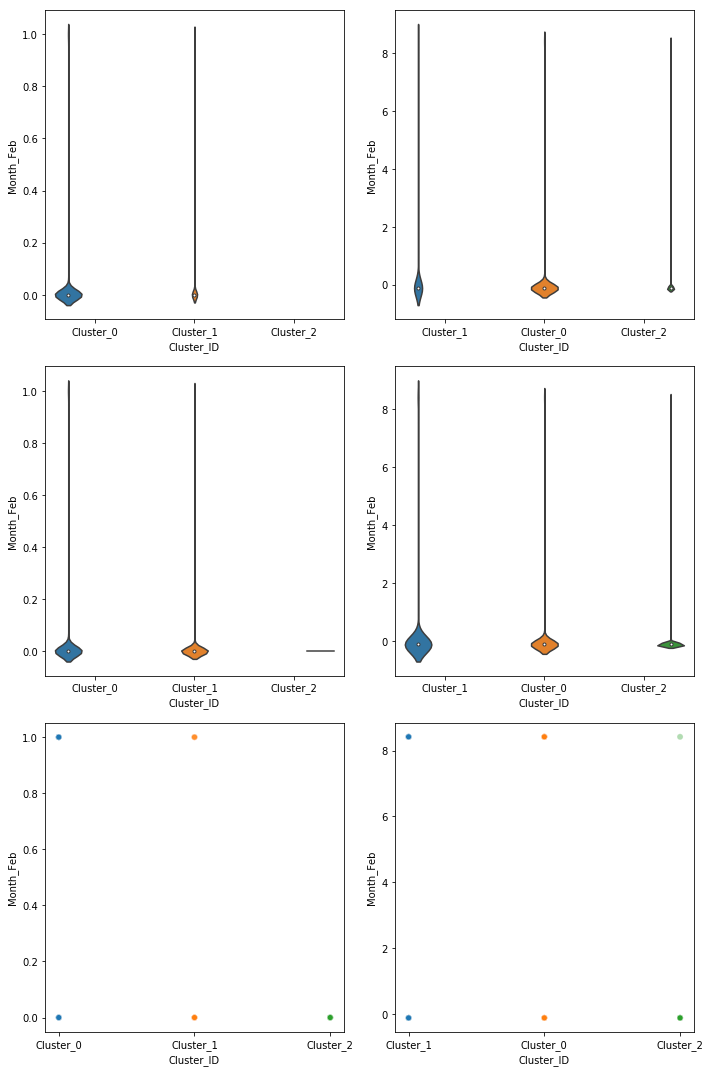

=========================== Month_Jul ( uint8 ) ===========================


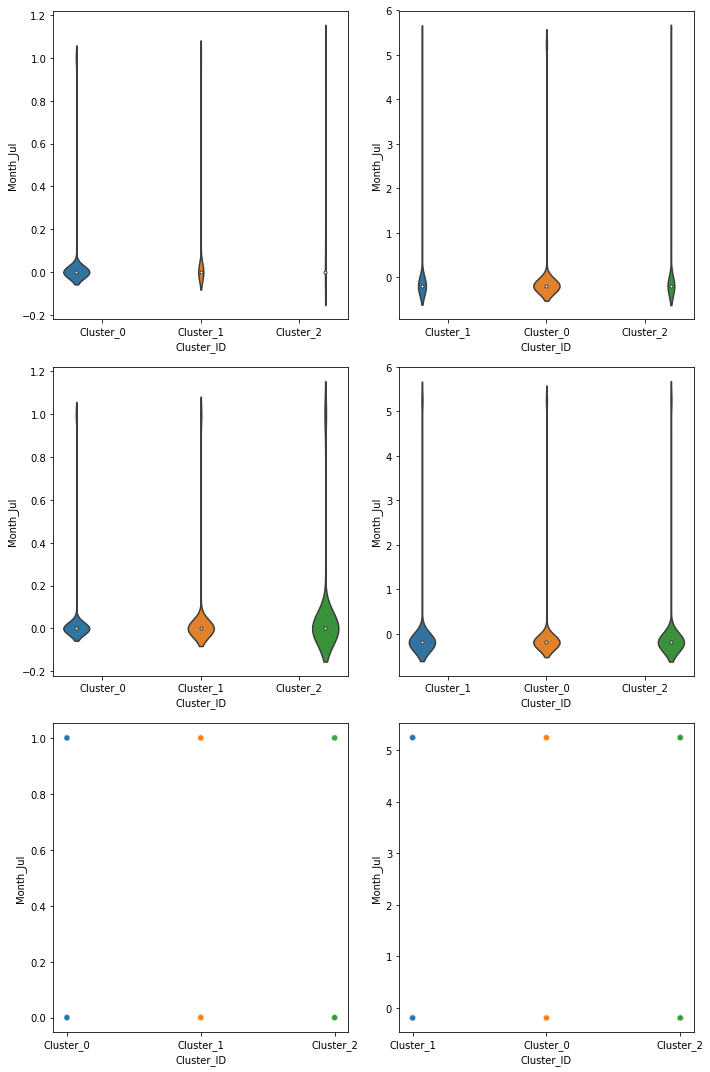

=========================== Month_June ( uint8 ) ===========================


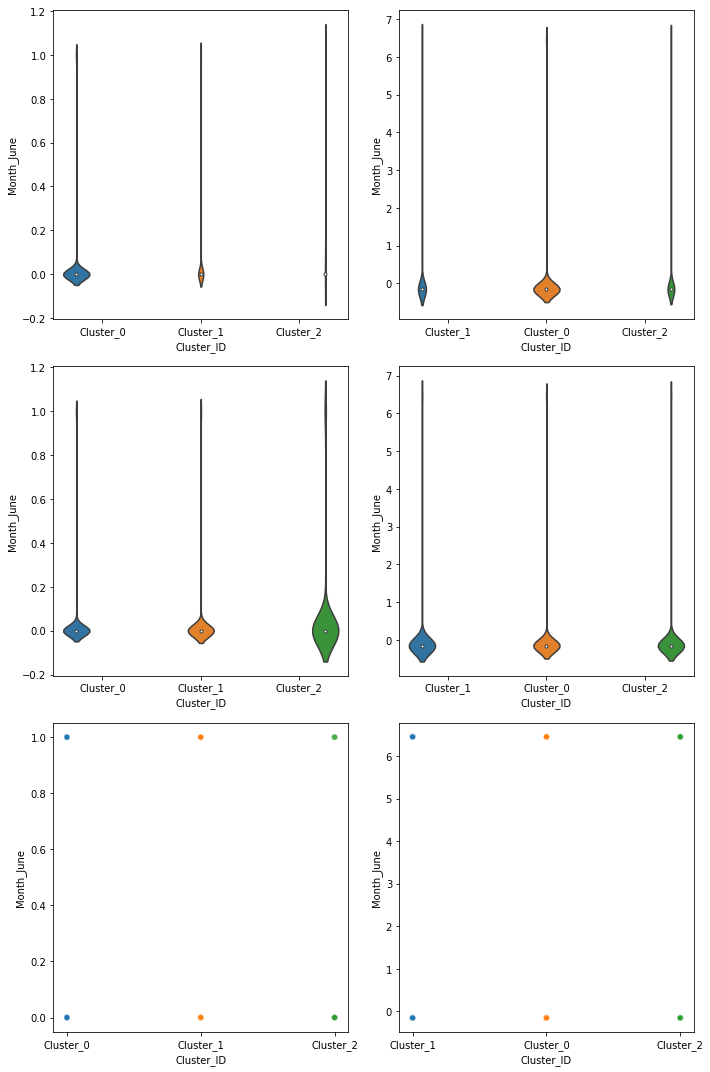

=========================== Month_Mar ( uint8 ) ===========================


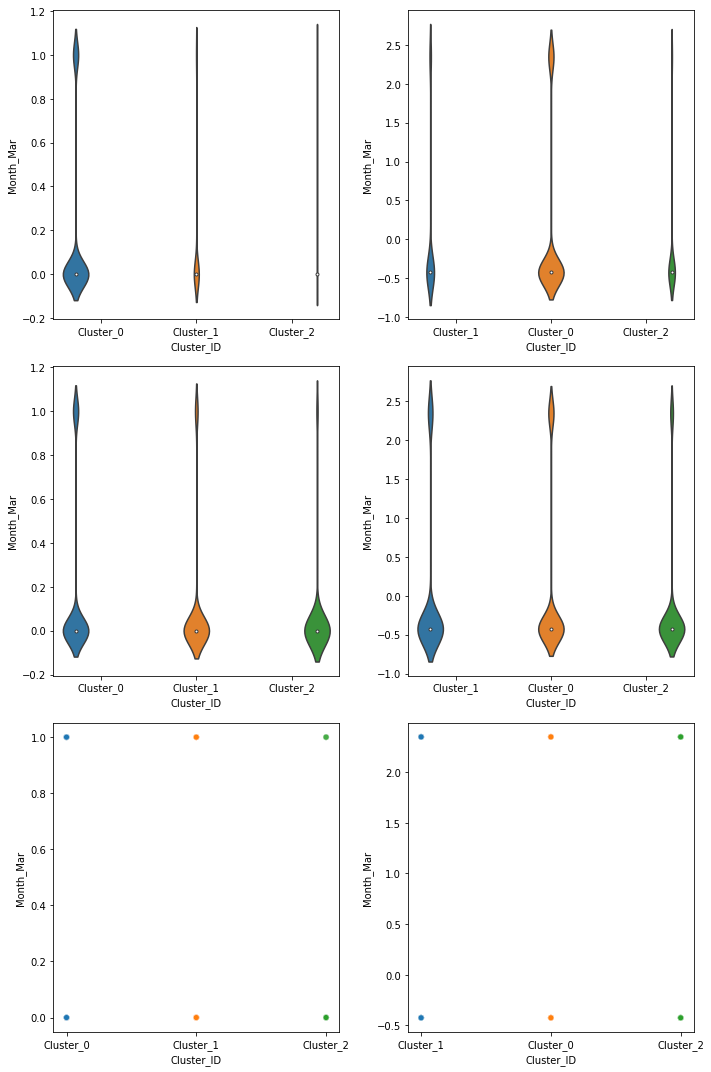

=========================== Month_May ( uint8 ) ===========================


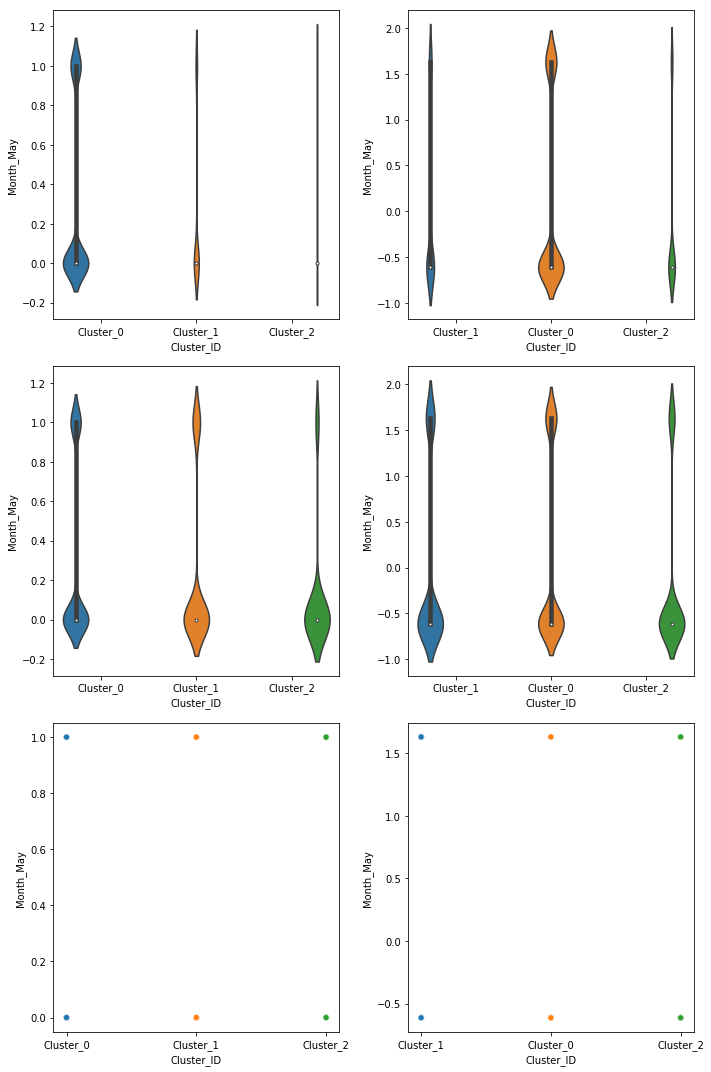

=========================== Month_Nov ( uint8 ) ===========================


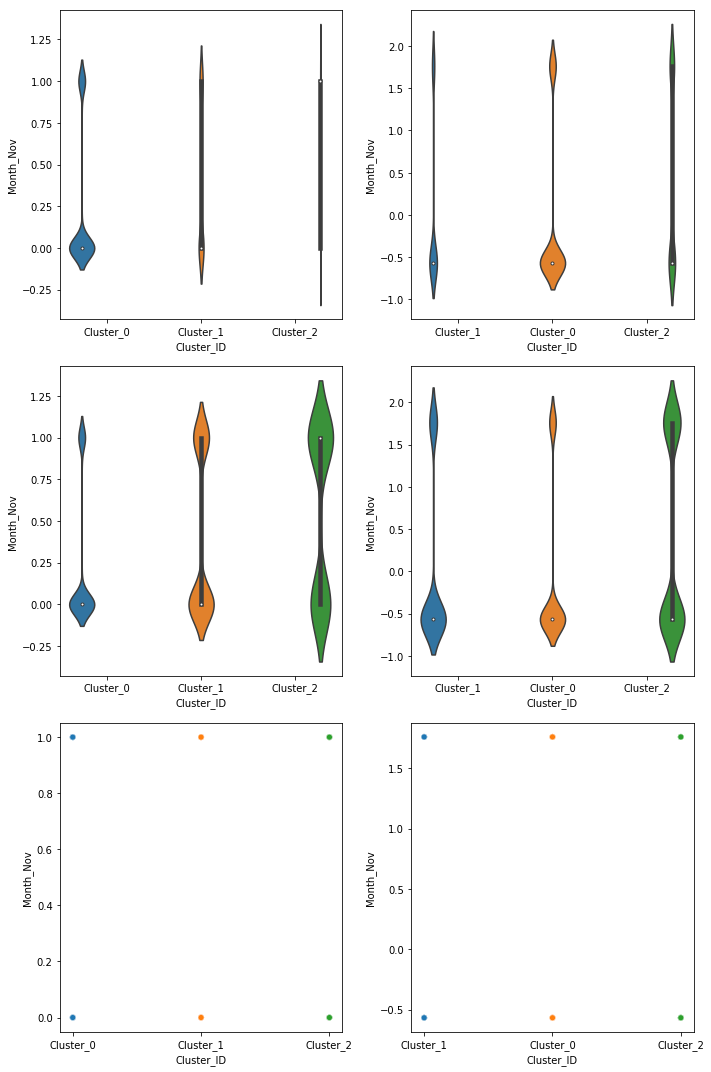

=========================== Month_Oct ( uint8 ) ===========================


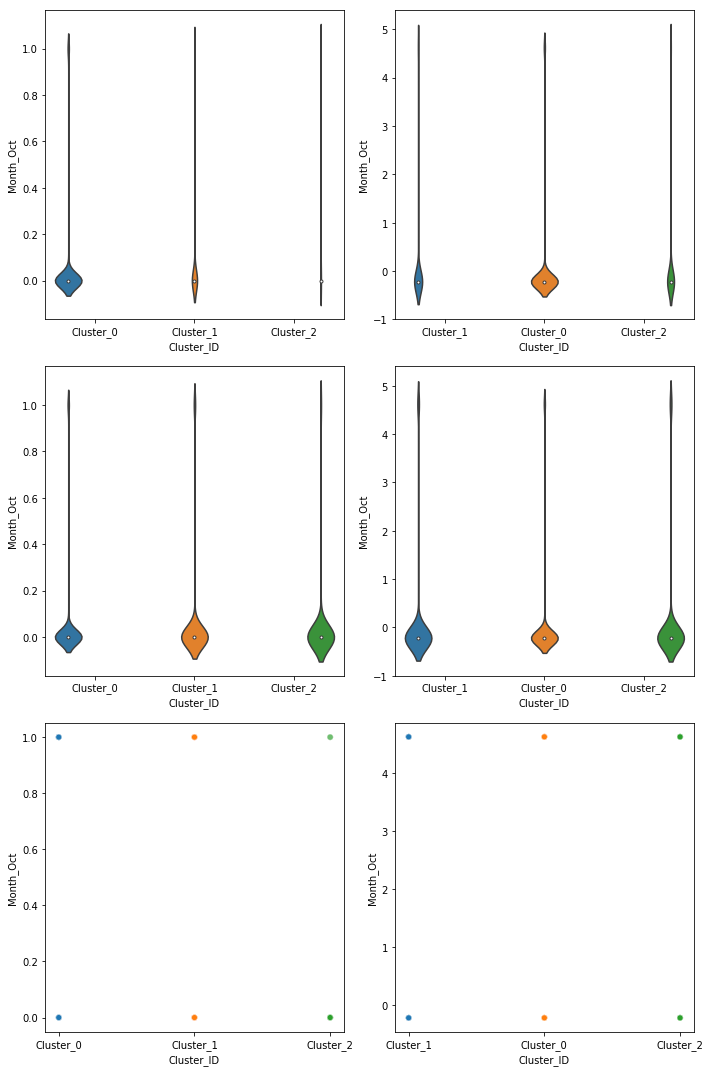

=========================== Month_Sep ( uint8 ) ===========================


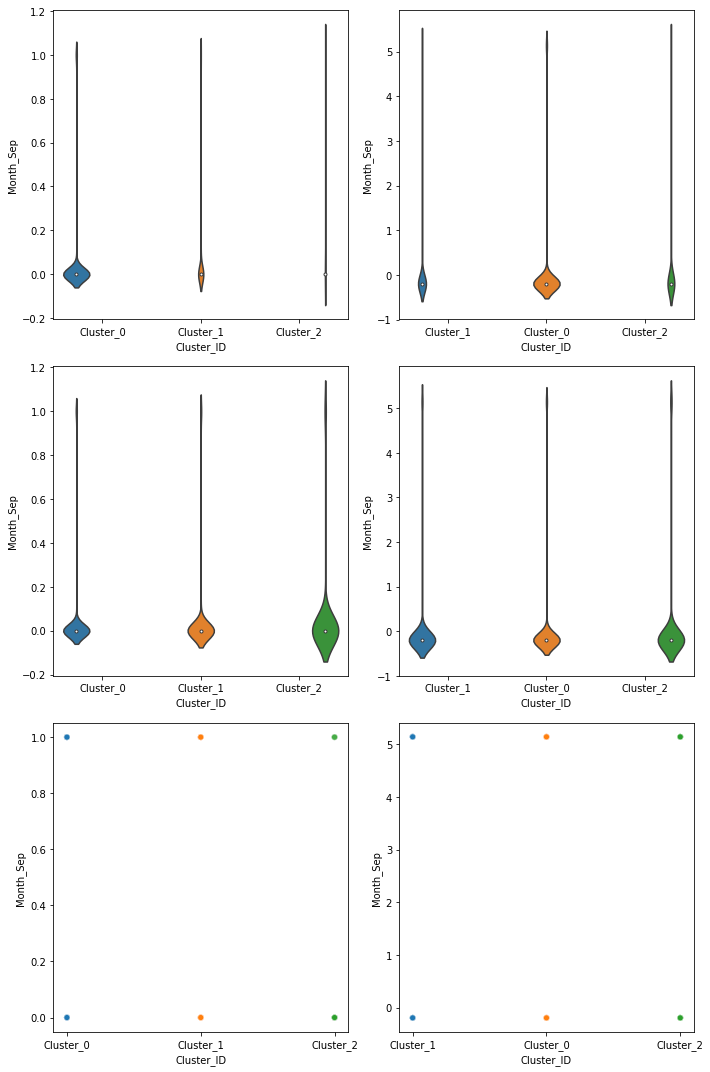

=========================== OperatingSystems_1 ( uint8 ) ===========================


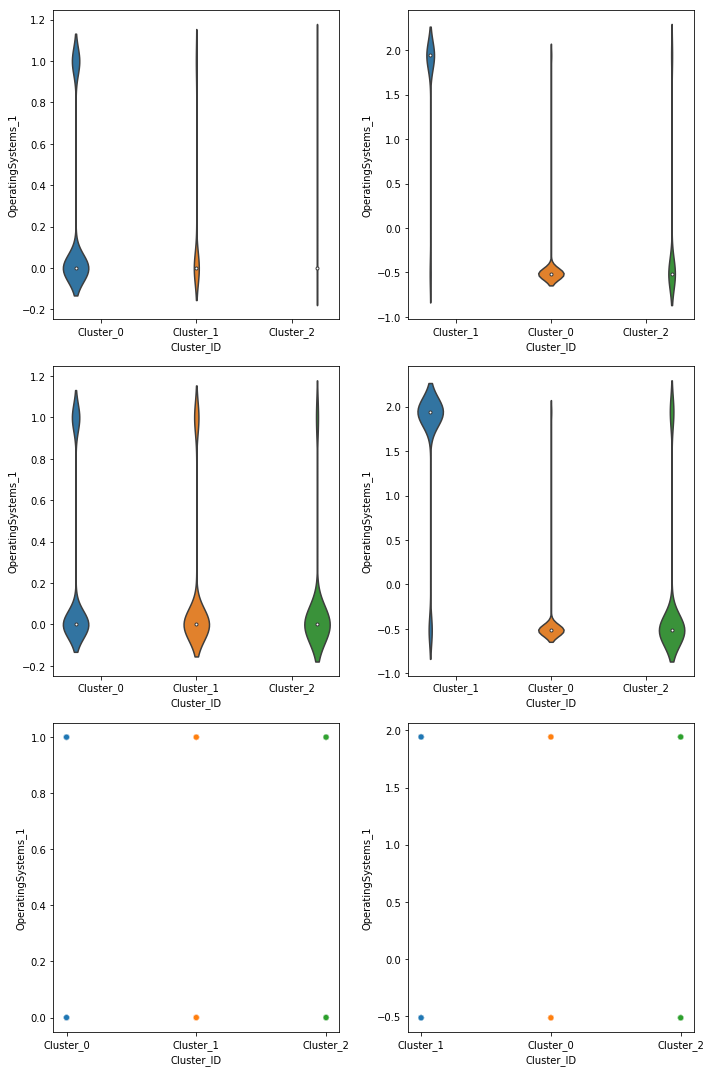

=========================== OperatingSystems_2 ( uint8 ) ===========================


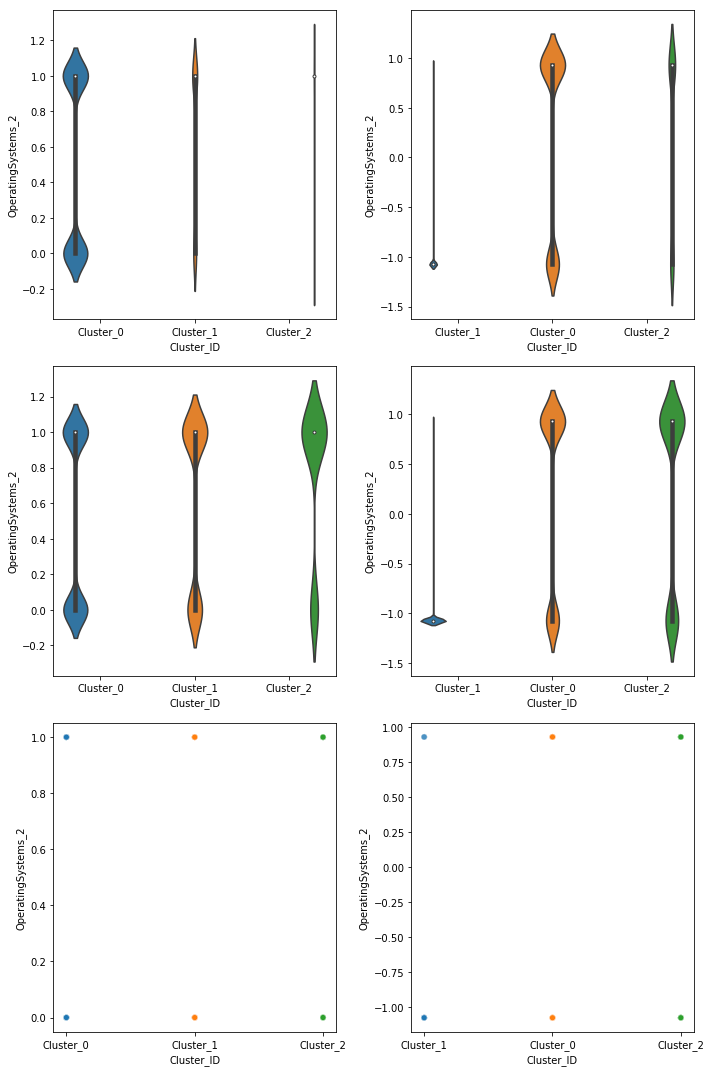

=========================== OperatingSystems_3 ( uint8 ) ===========================


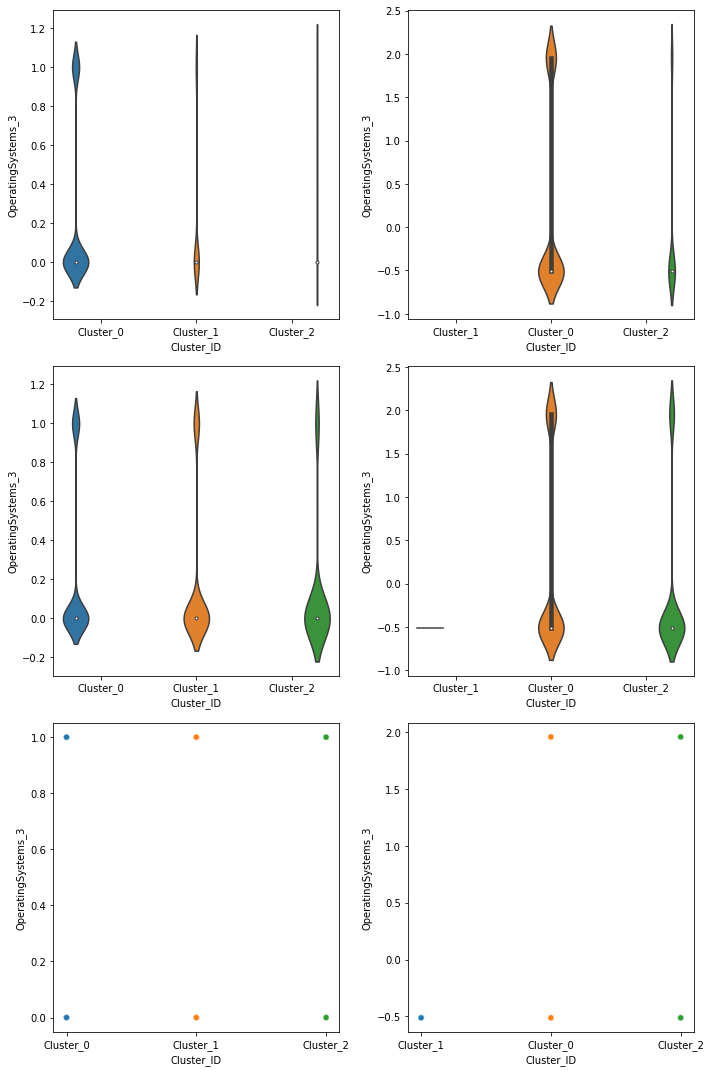

=========================== OperatingSystems_4 ( uint8 ) ===========================


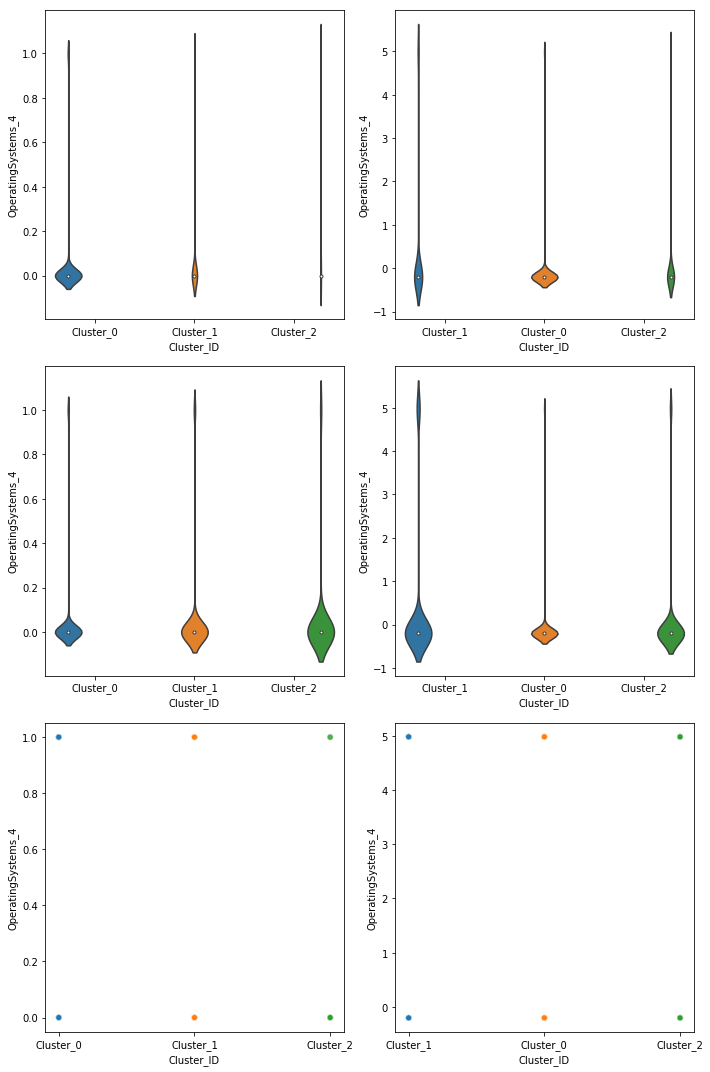

=========================== OperatingSystems_5 ( uint8 ) ===========================


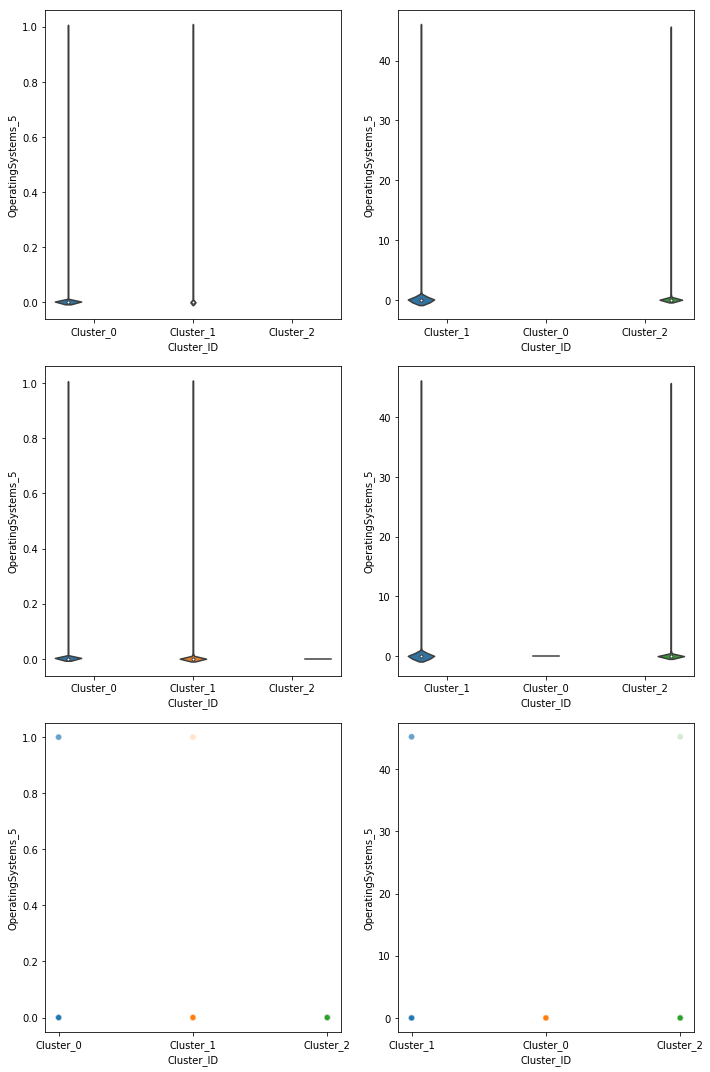

=========================== OperatingSystems_6 ( uint8 ) ===========================


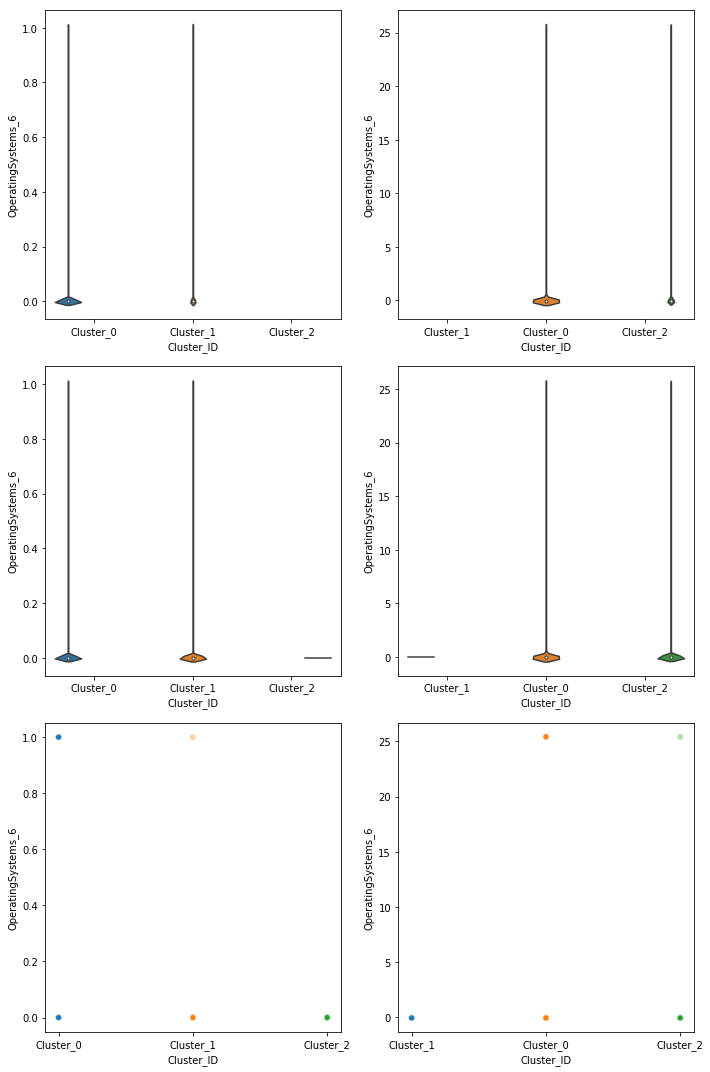

=========================== OperatingSystems_7 ( uint8 ) ===========================


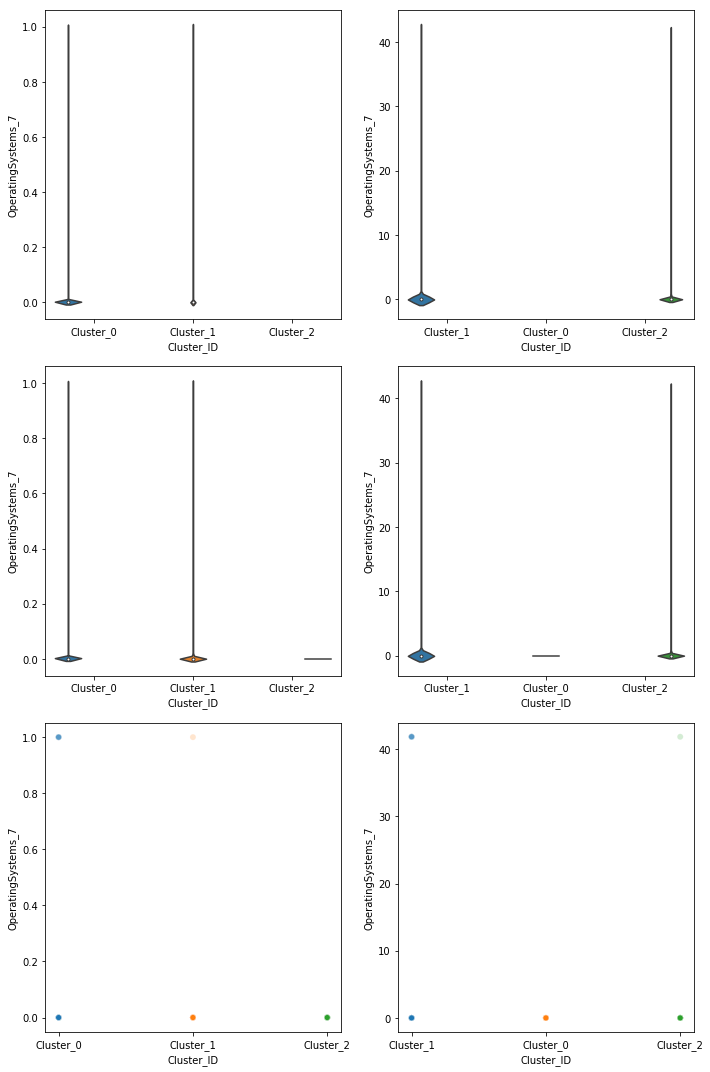

=========================== OperatingSystems_8 ( uint8 ) ===========================


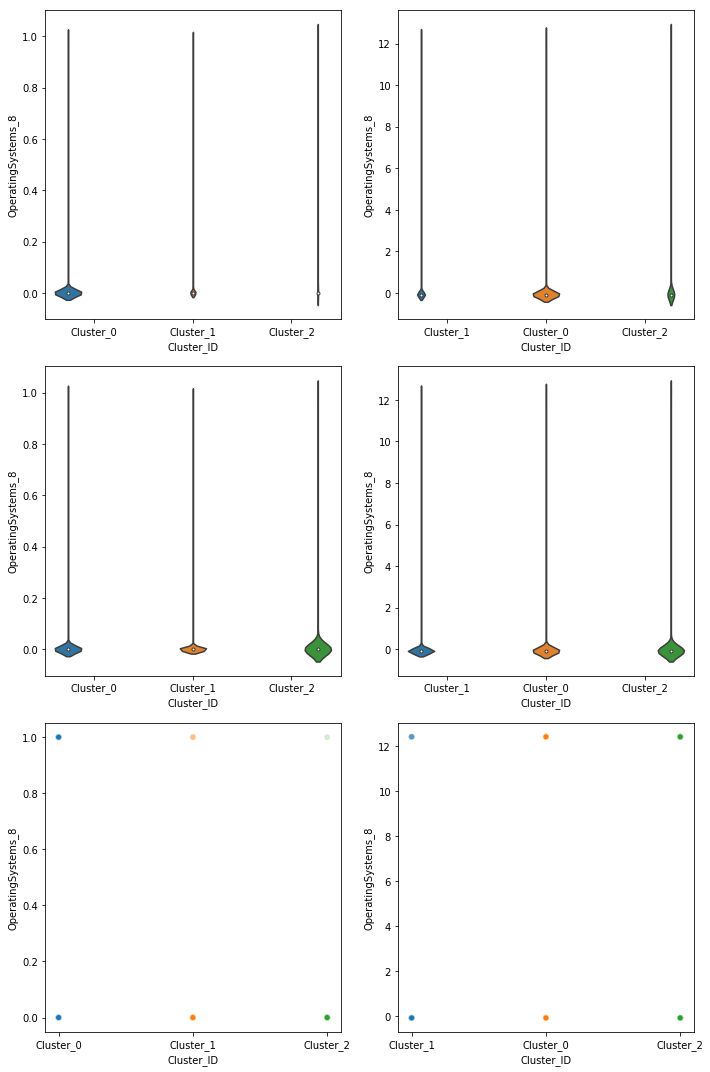

=========================== Browser_1 ( uint8 ) ===========================


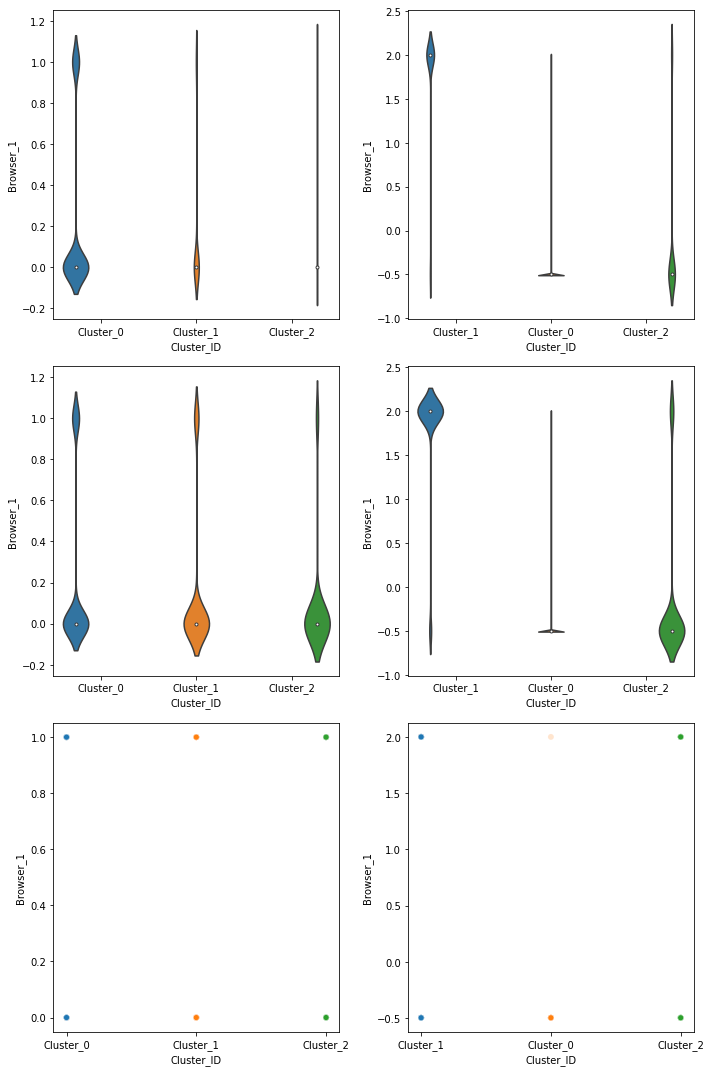

=========================== Browser_2 ( uint8 ) ===========================


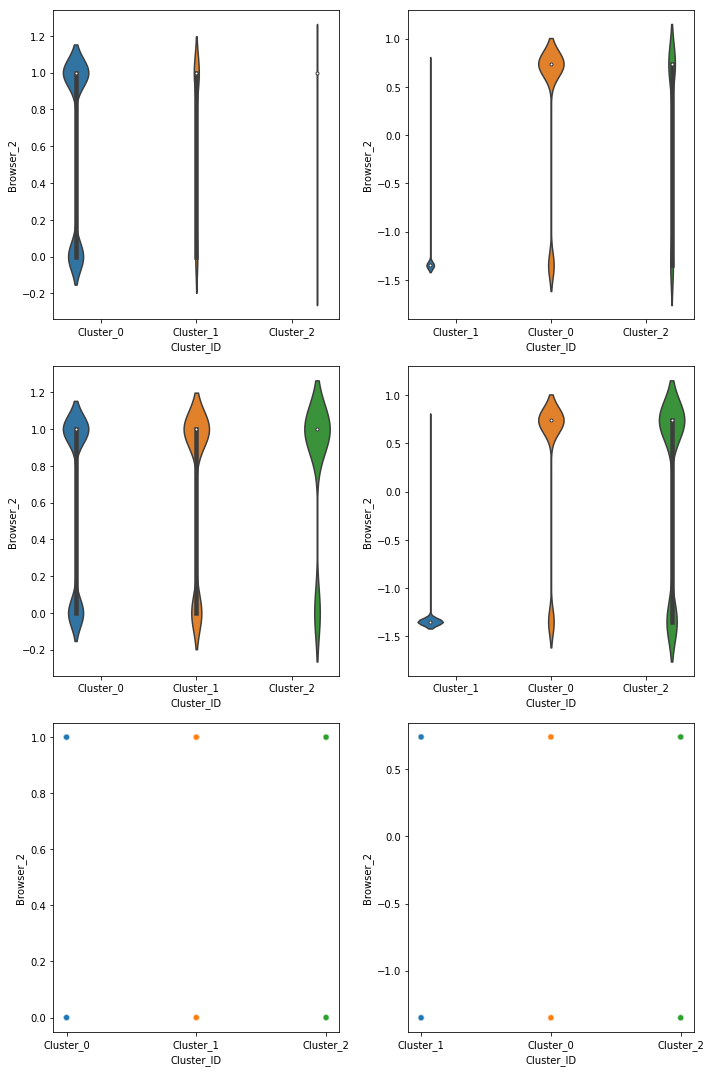

=========================== Browser_3 ( uint8 ) ===========================


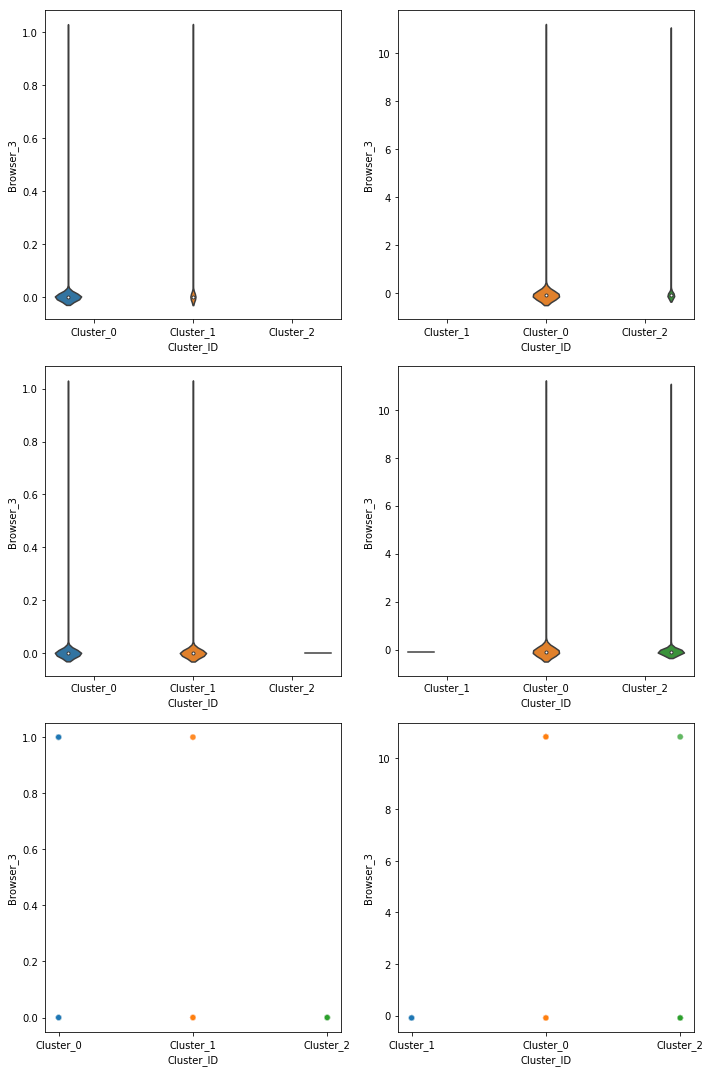

=========================== Browser_4 ( uint8 ) ===========================


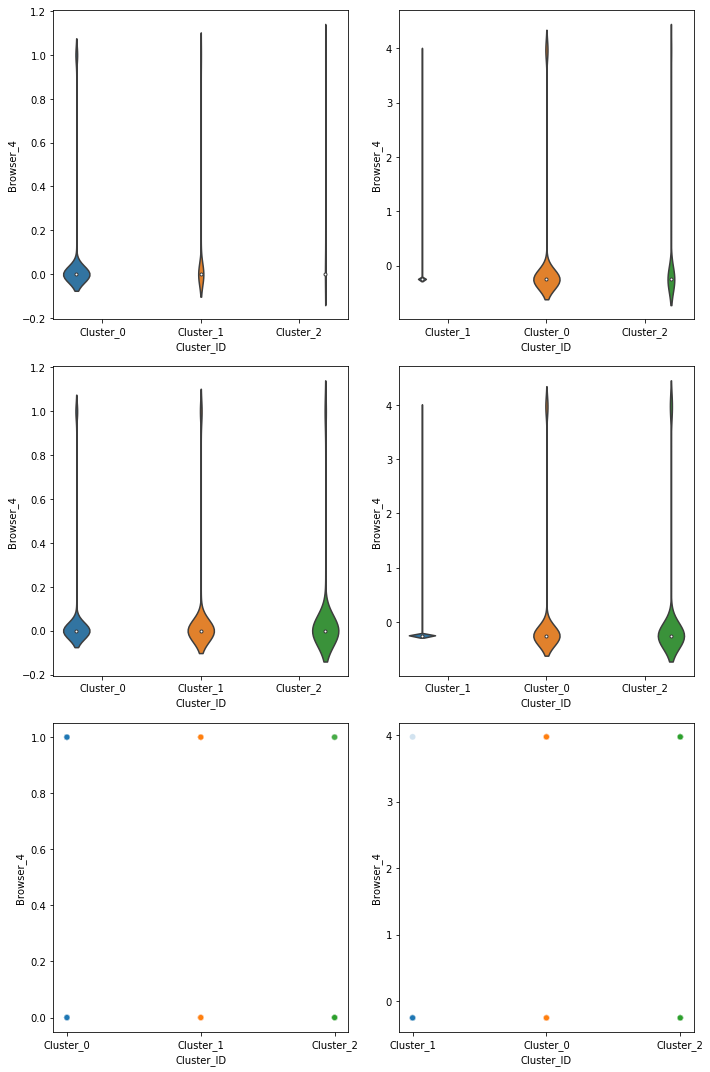

=========================== Browser_5 ( uint8 ) ===========================


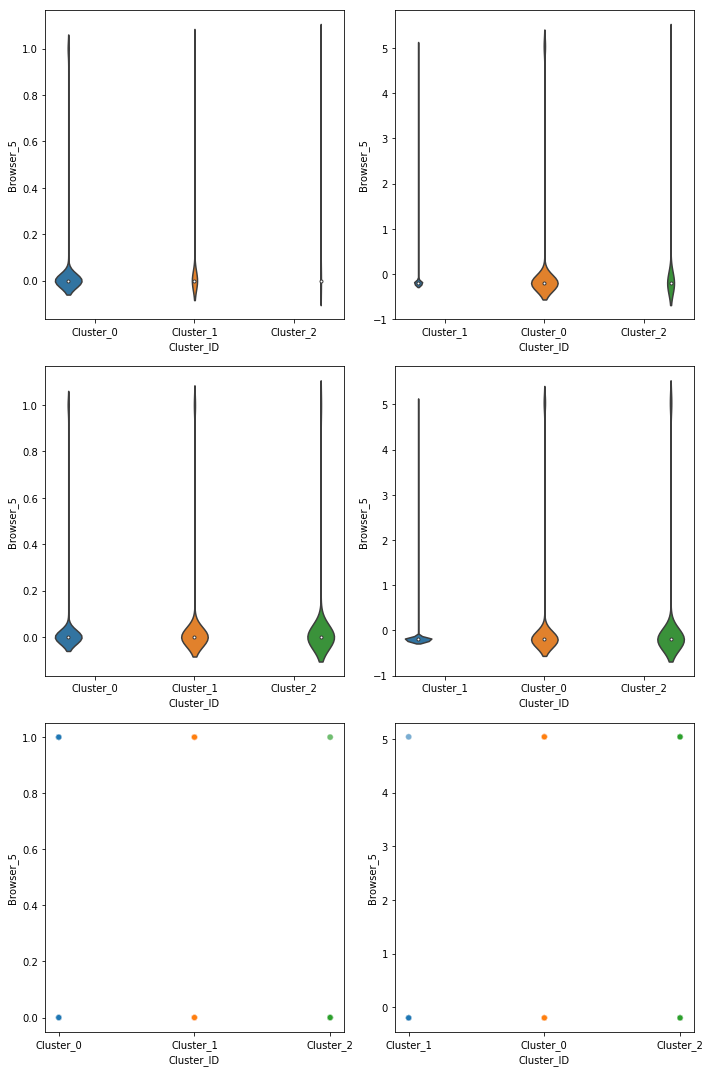

=========================== Browser_6 ( uint8 ) ===========================


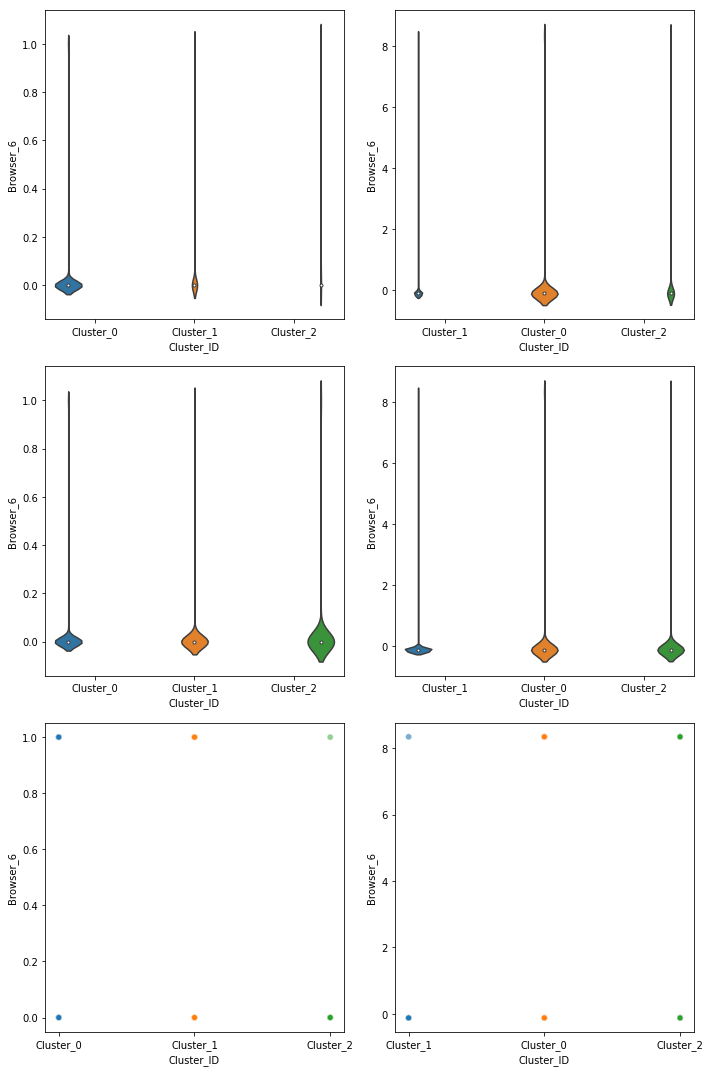

=========================== Browser_7 ( uint8 ) ===========================


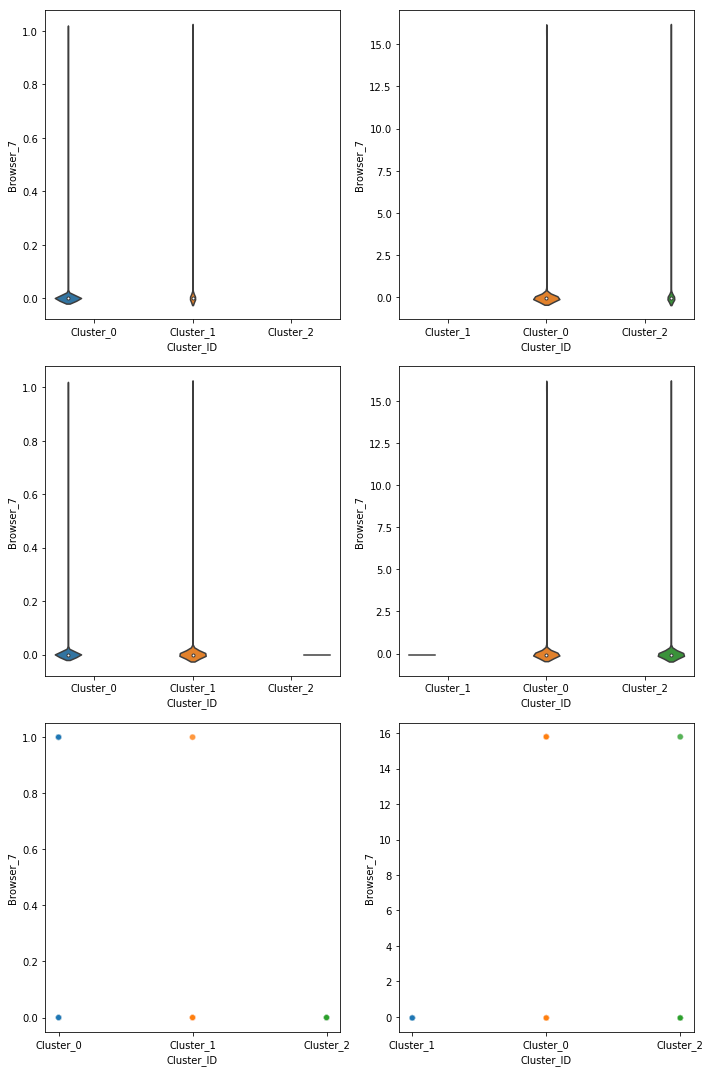

=========================== Browser_8 ( uint8 ) ===========================


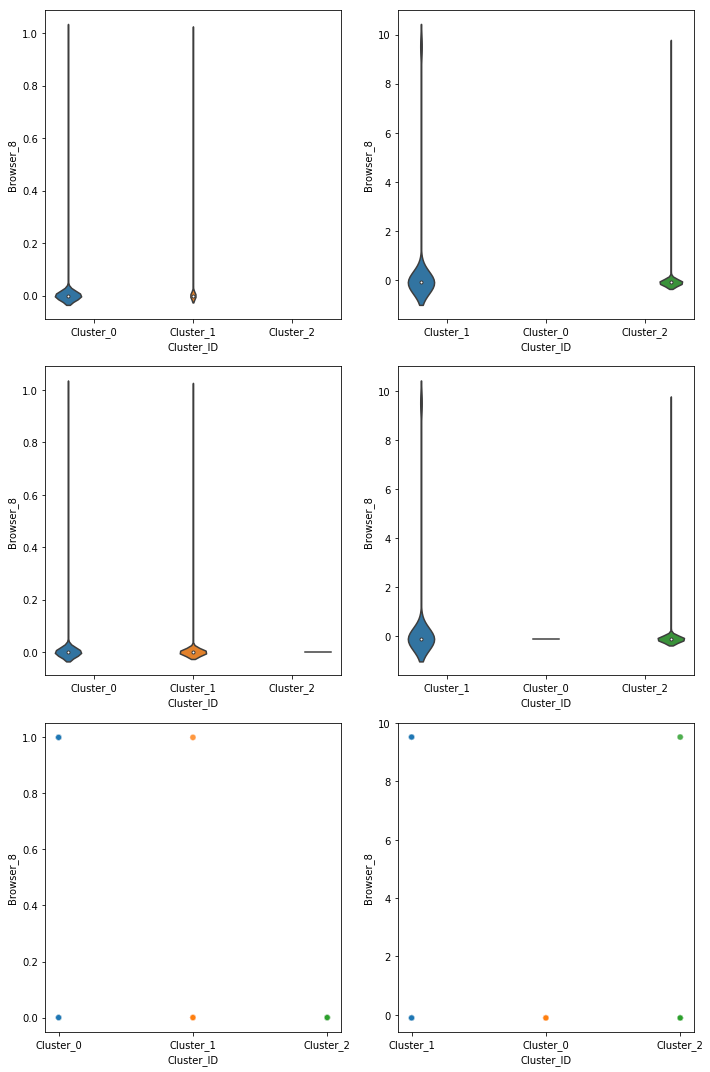

=========================== Browser_9 ( uint8 ) ===========================


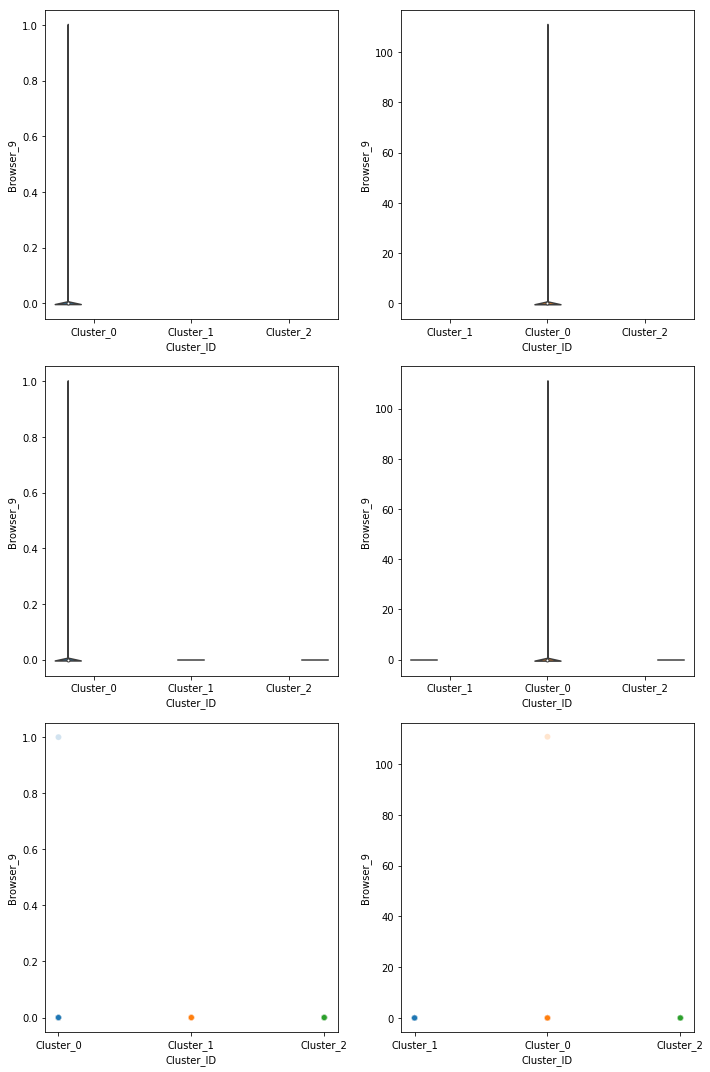

=========================== Browser_10 ( uint8 ) ===========================


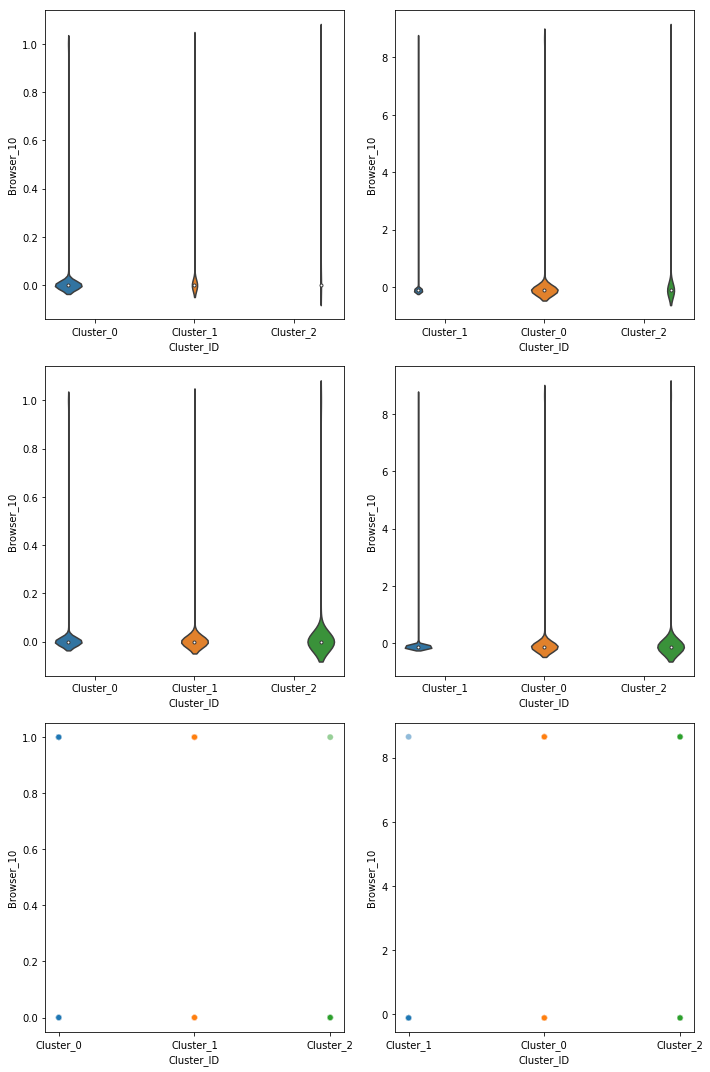

=========================== Browser_11 ( uint8 ) ===========================


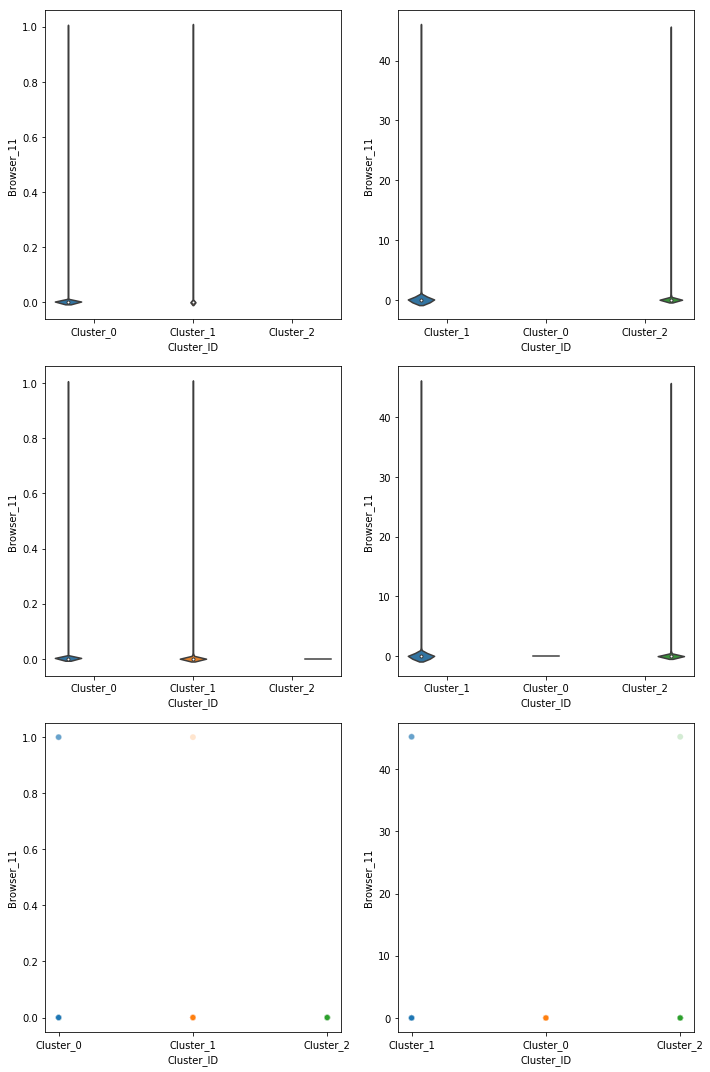

=========================== Browser_12 ( uint8 ) ===========================


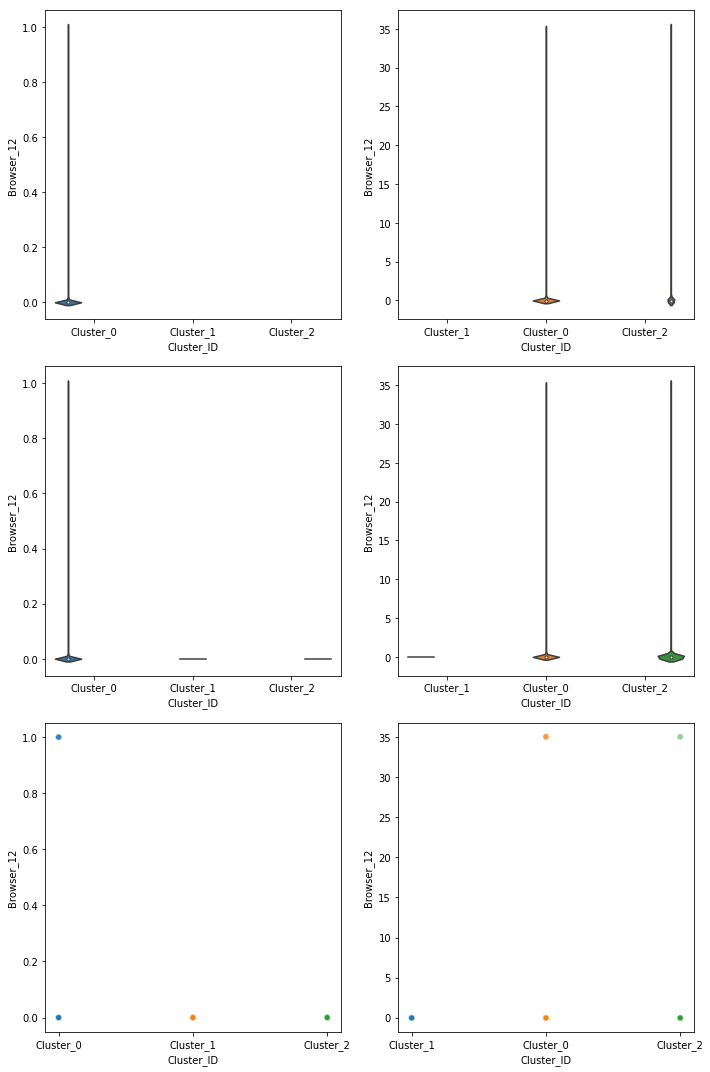

=========================== Browser_13 ( uint8 ) ===========================


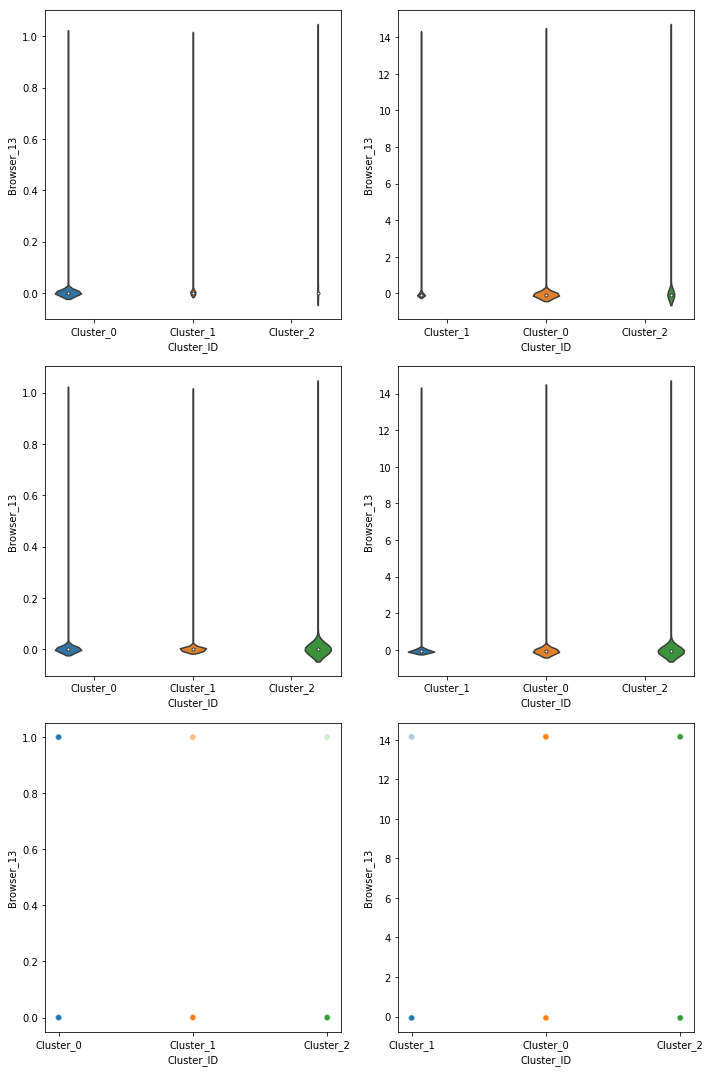

=========================== Region_1 ( uint8 ) ===========================


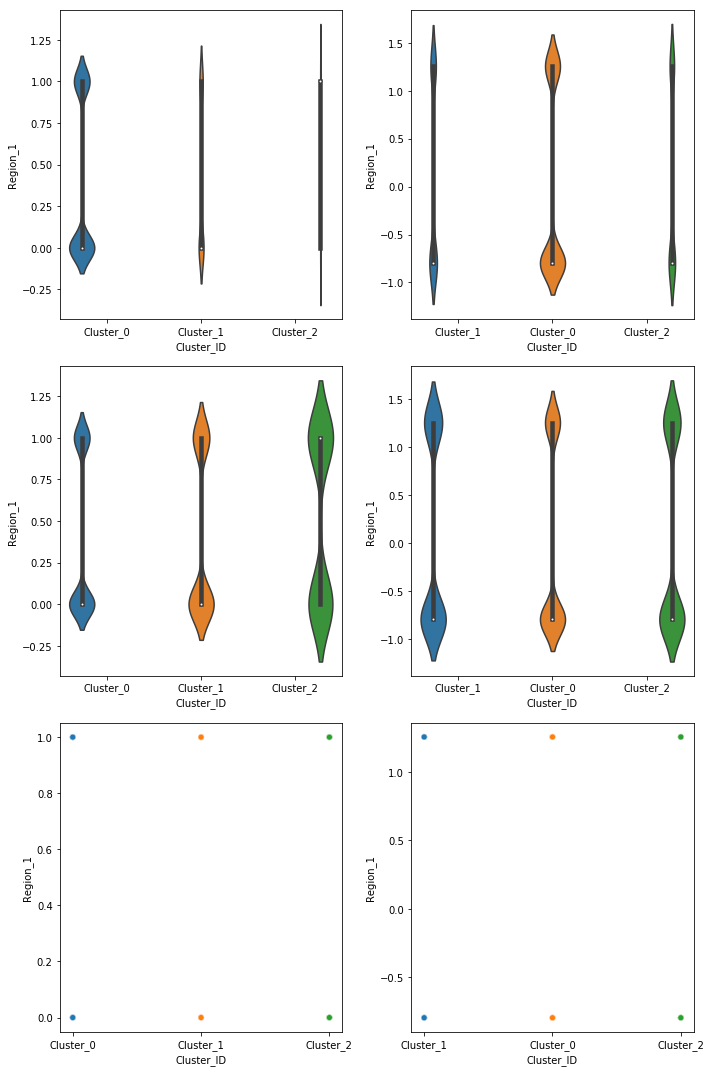

=========================== Region_2 ( uint8 ) ===========================


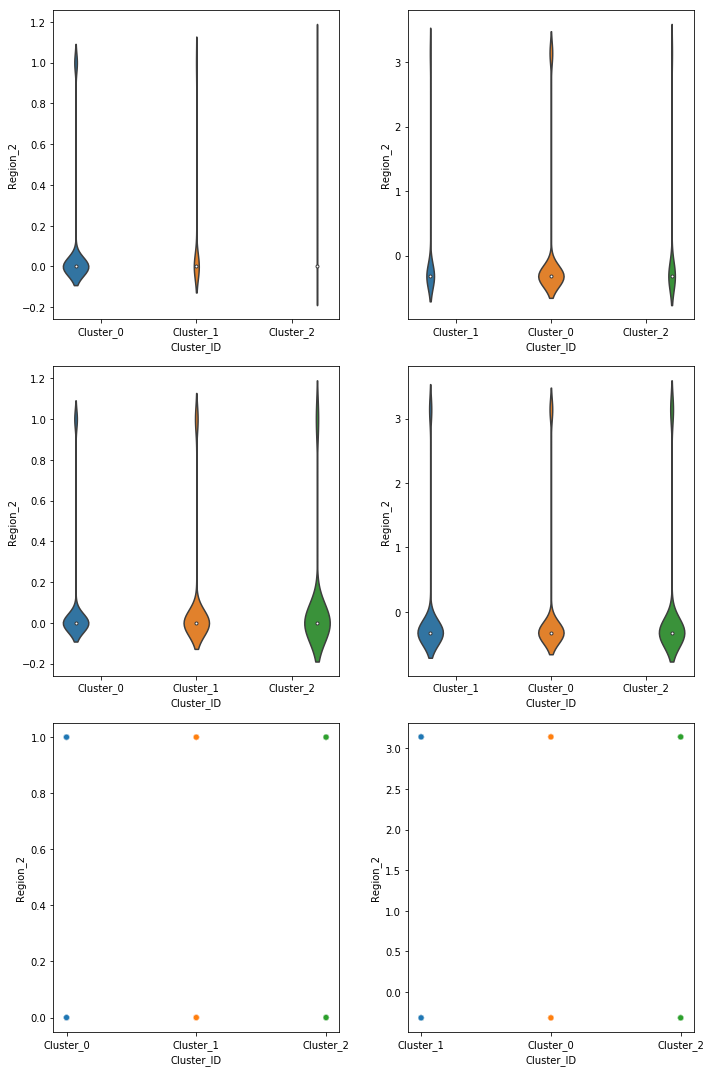

=========================== Region_3 ( uint8 ) ===========================


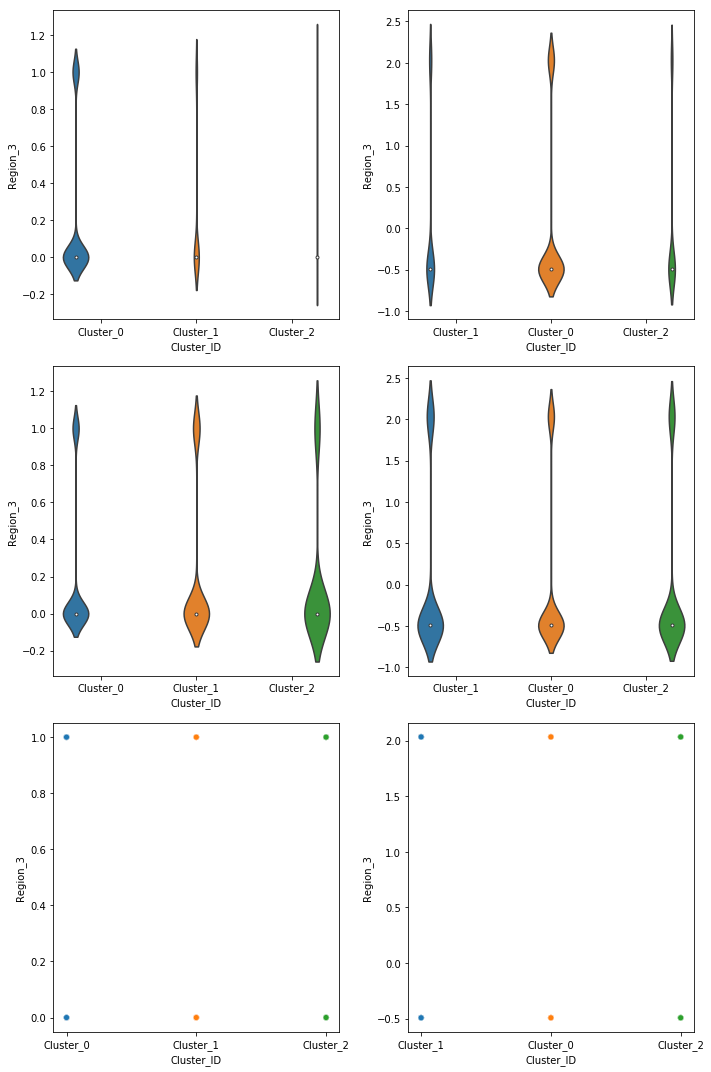

=========================== Region_4 ( uint8 ) ===========================


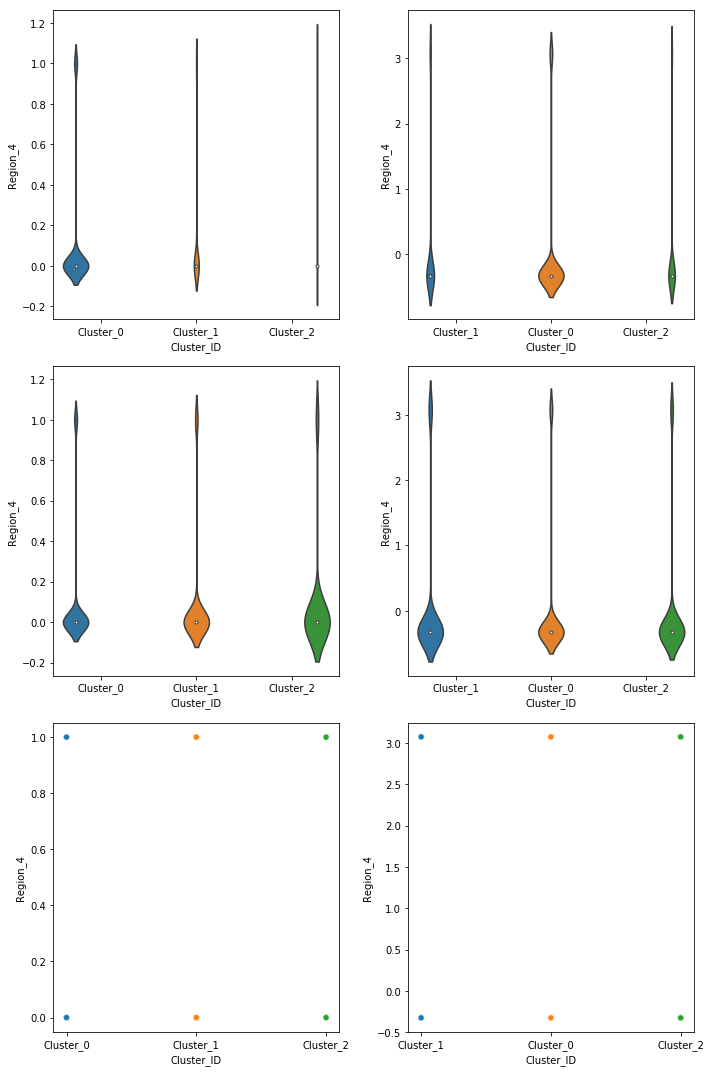

=========================== Region_5 ( uint8 ) ===========================


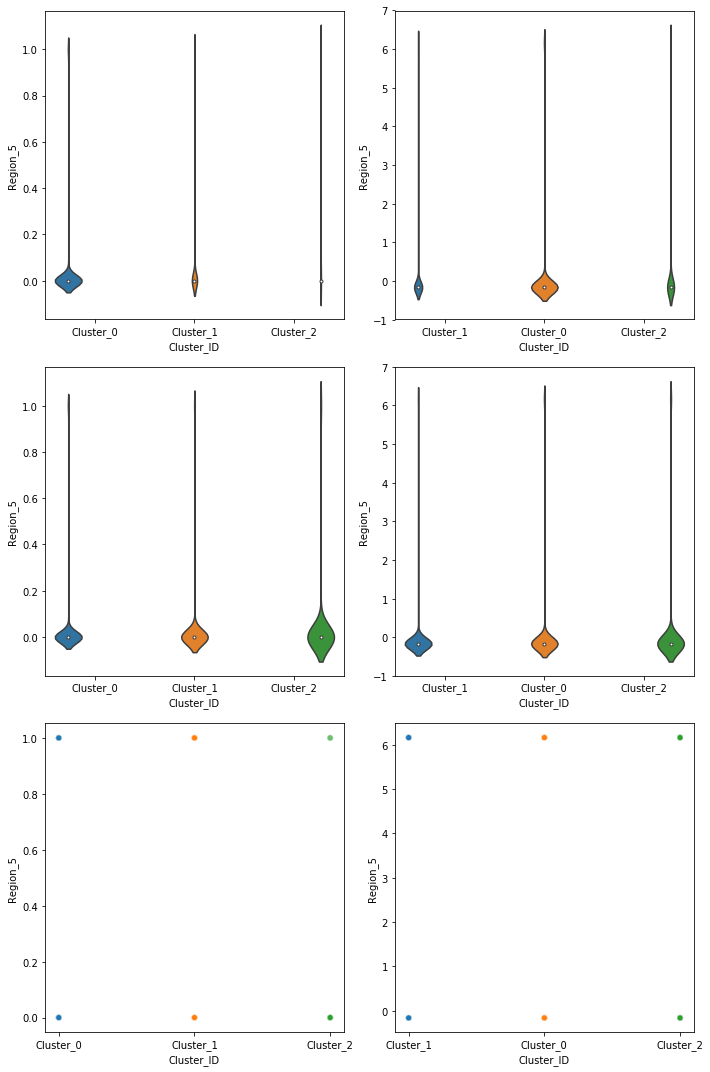

=========================== Region_6 ( uint8 ) ===========================


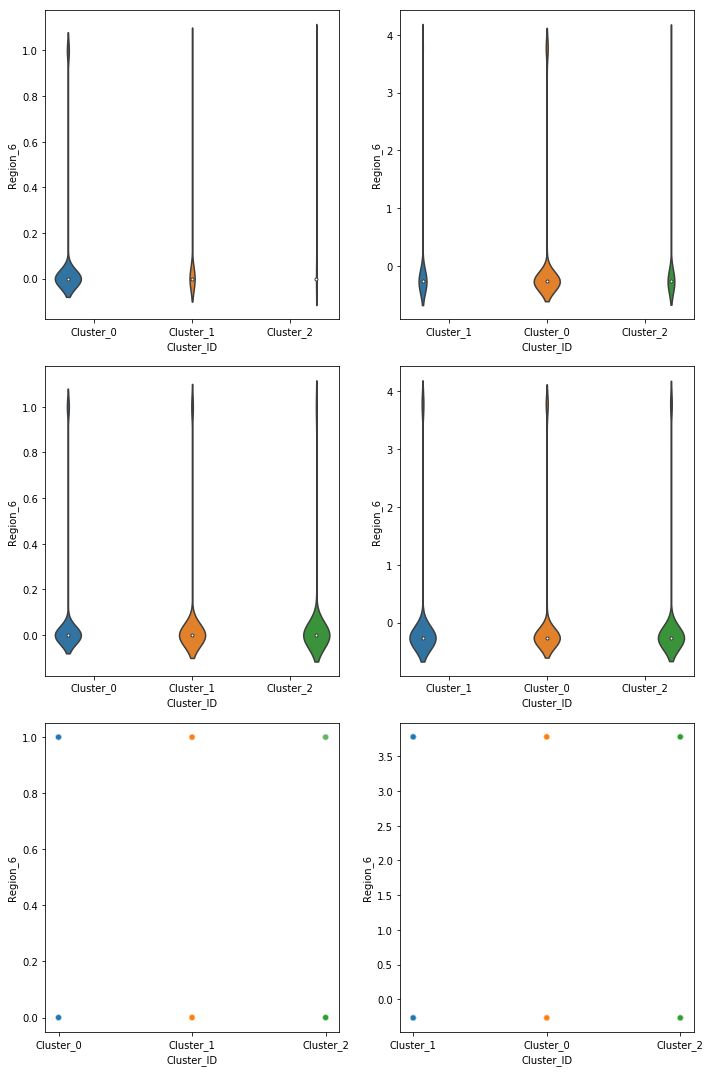

=========================== Region_7 ( uint8 ) ===========================


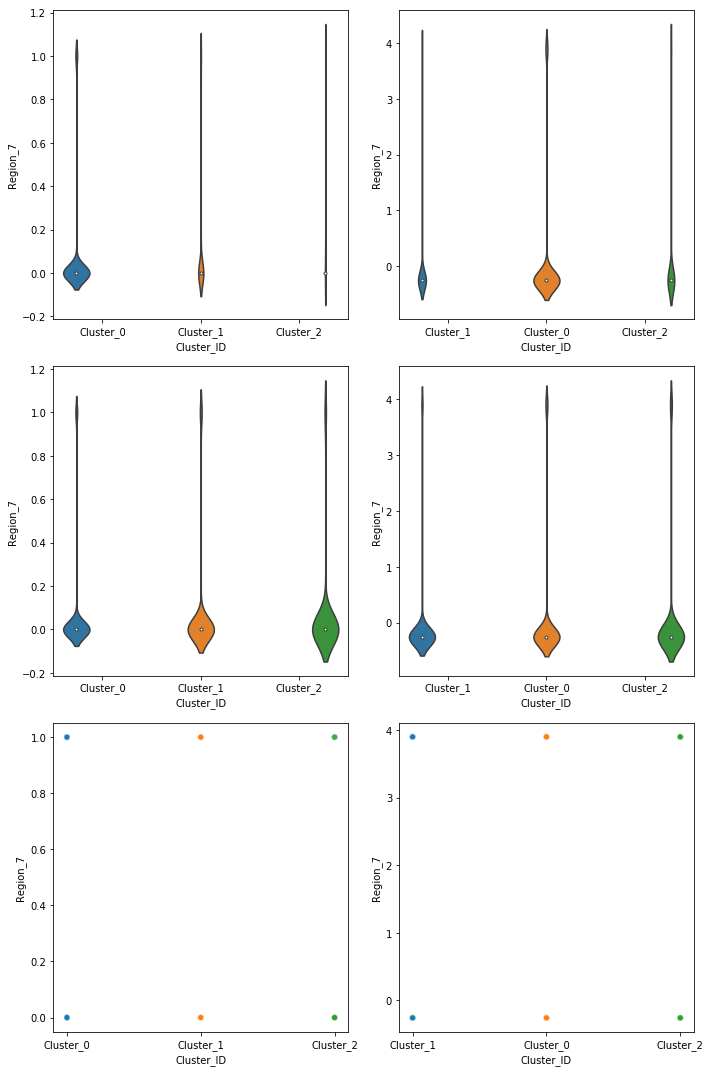

=========================== Region_8 ( uint8 ) ===========================


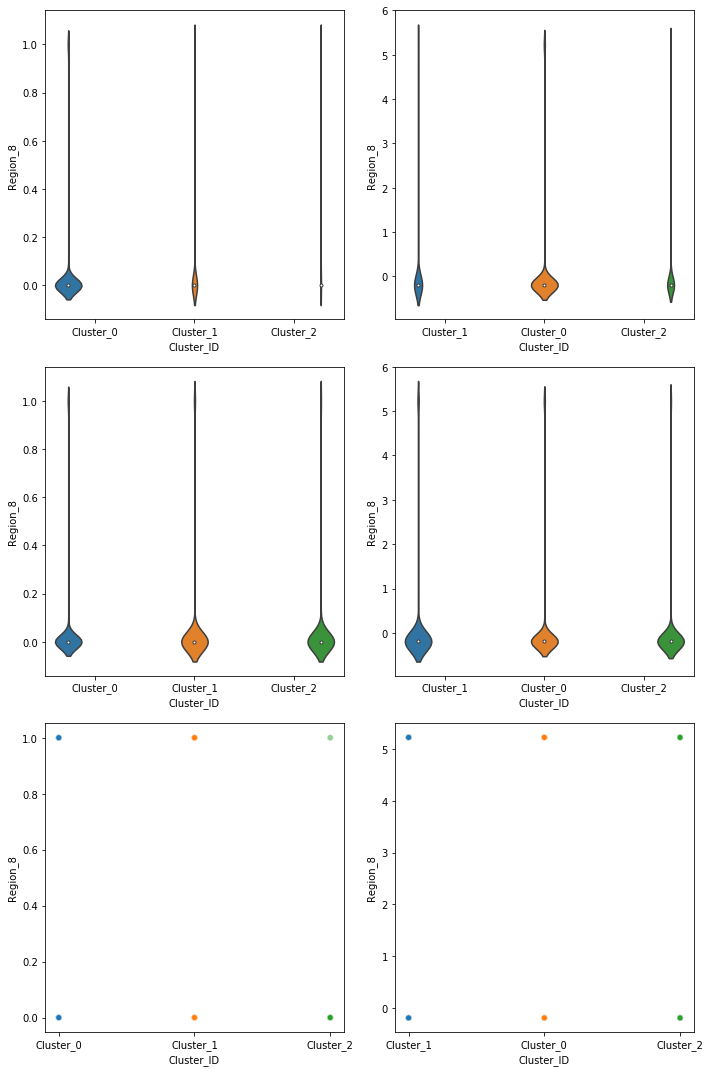

=========================== Region_9 ( uint8 ) ===========================


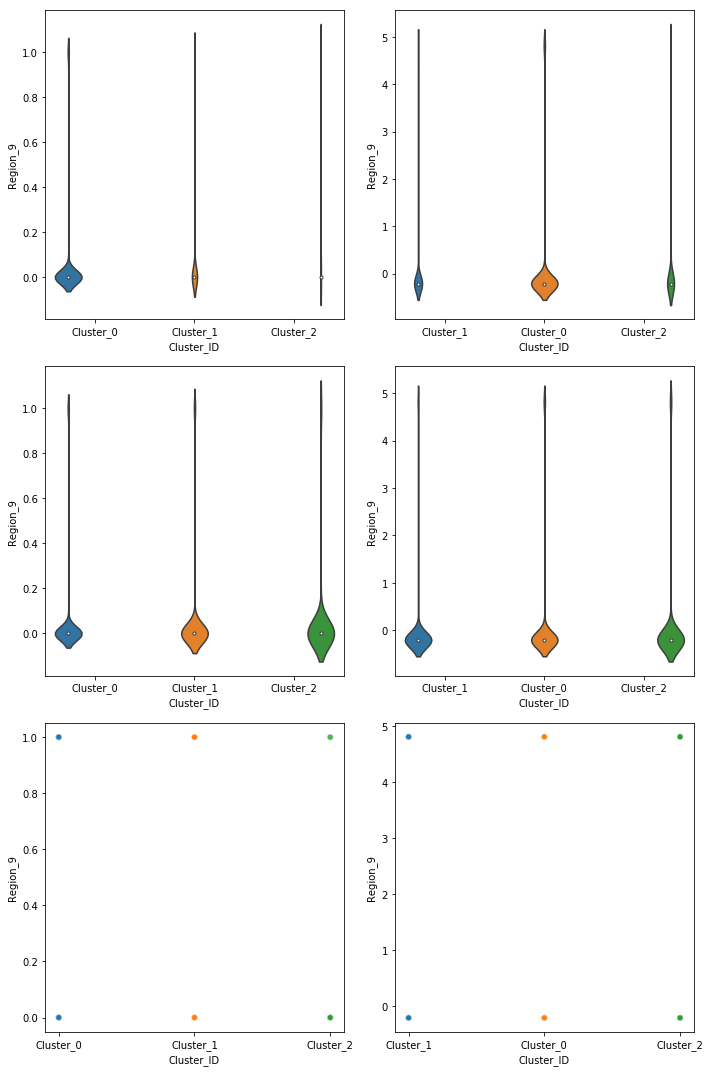

=========================== TrafficType_1 ( uint8 ) ===========================


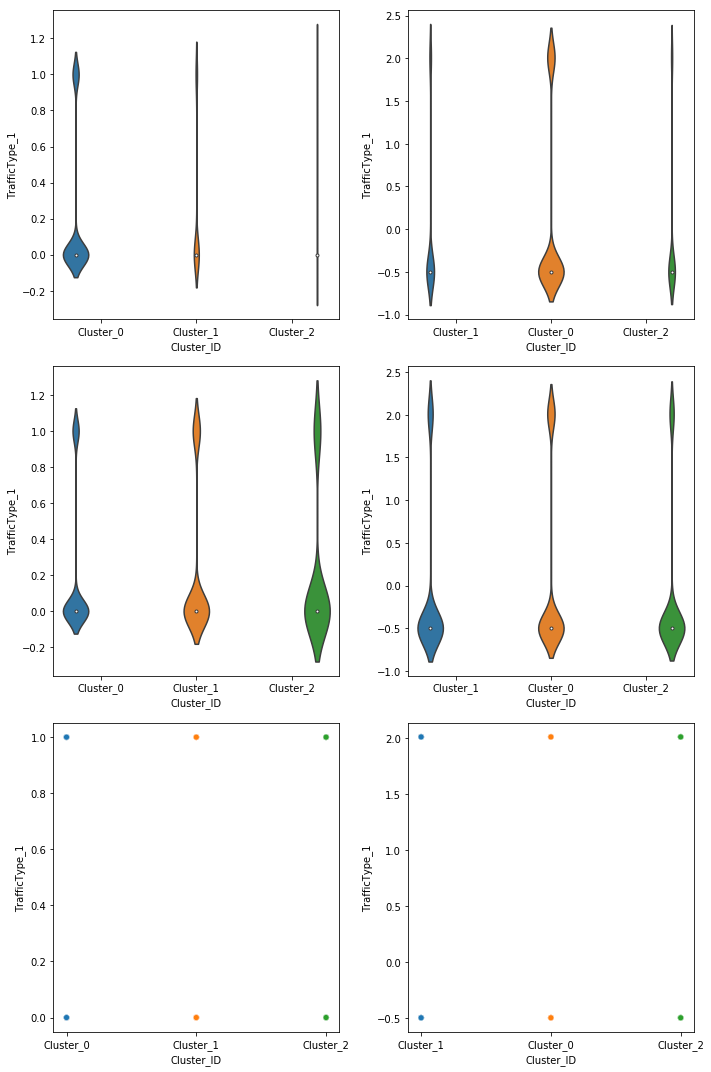

=========================== TrafficType_2 ( uint8 ) ===========================


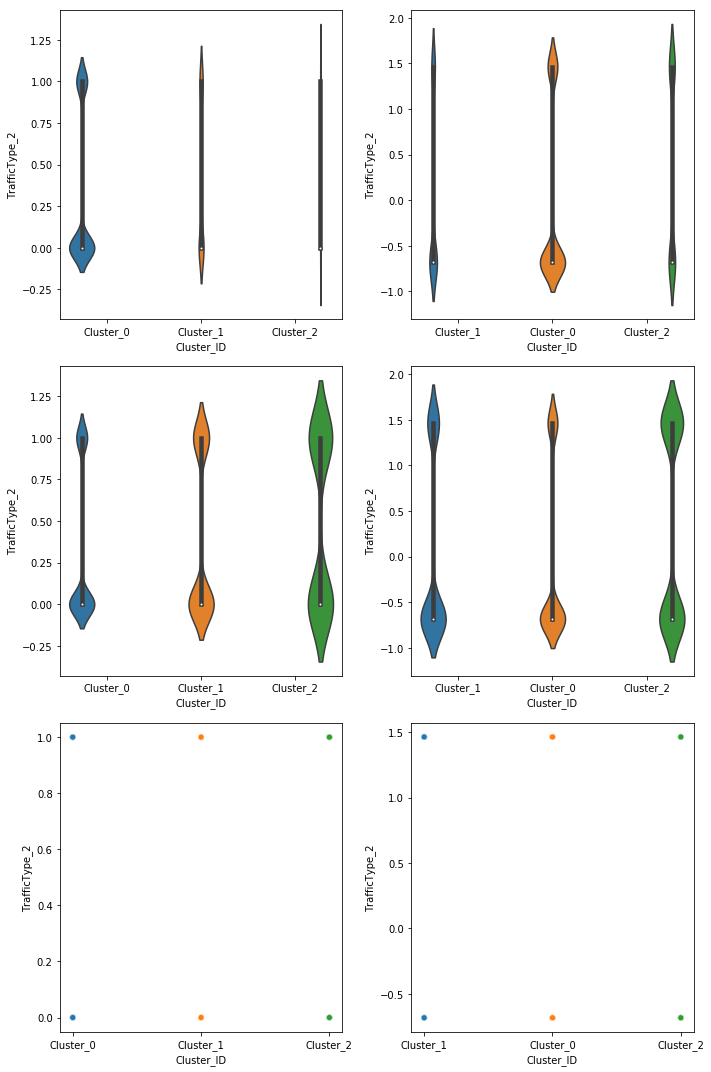

=========================== TrafficType_3 ( uint8 ) ===========================


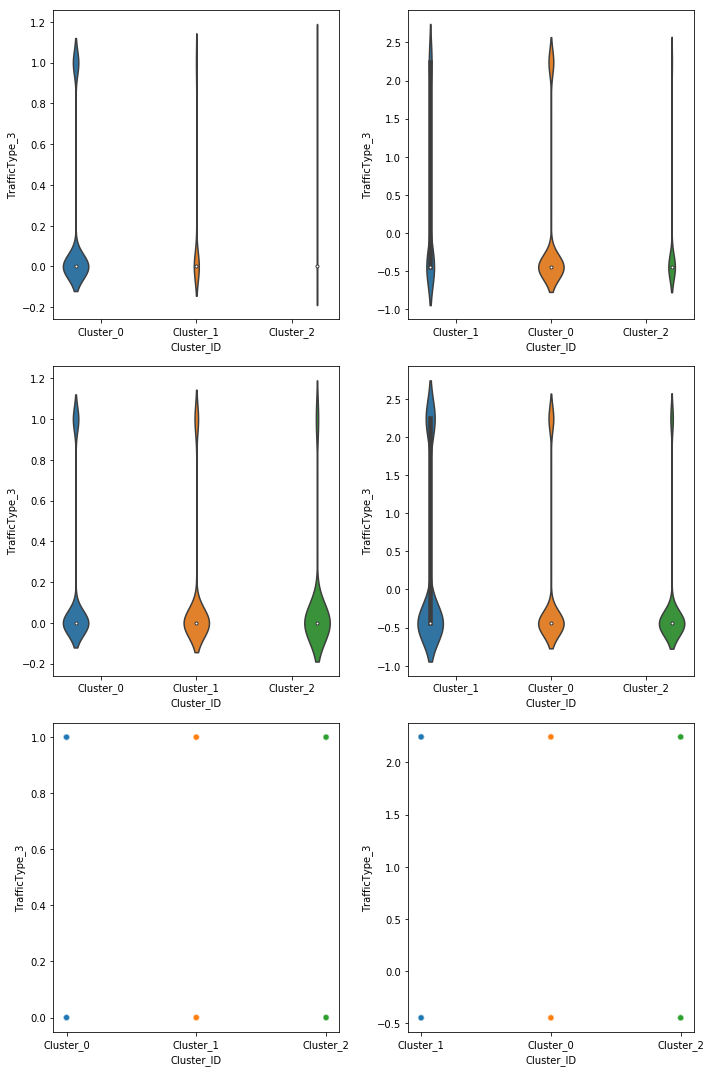

=========================== TrafficType_4 ( uint8 ) ===========================


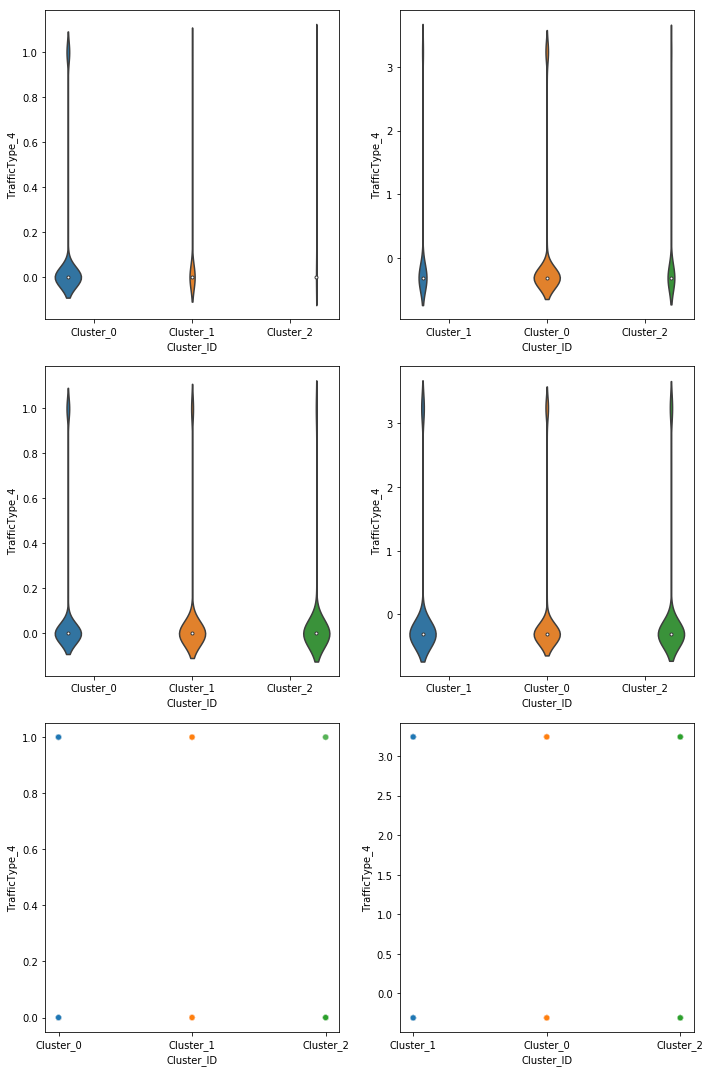

=========================== TrafficType_5 ( uint8 ) ===========================


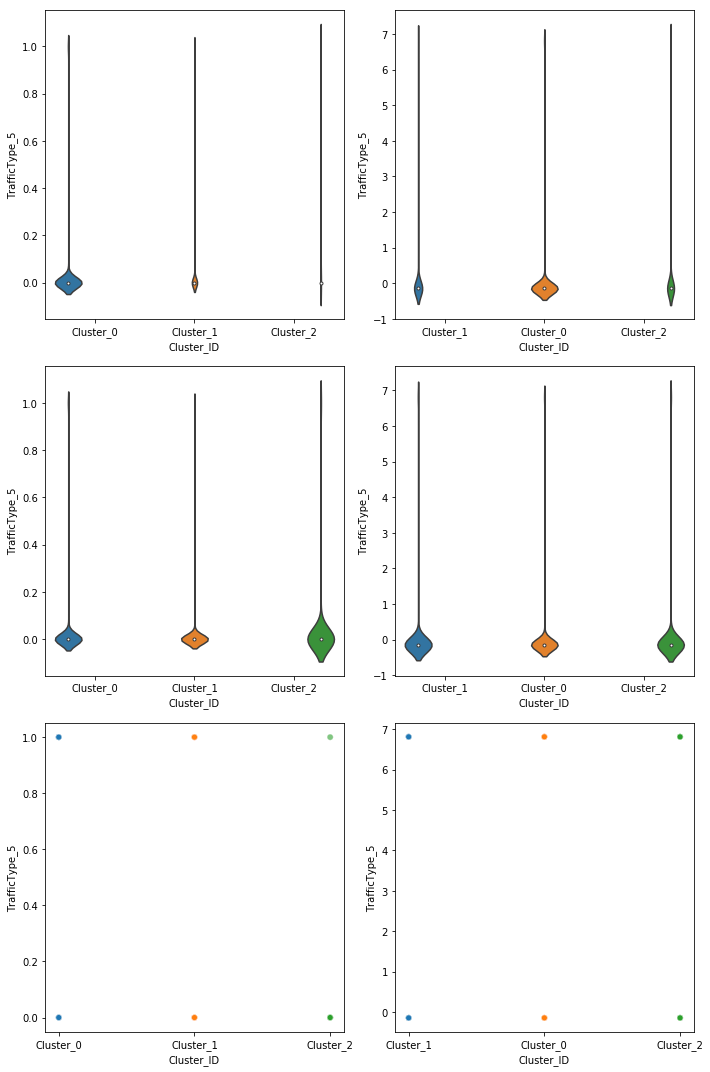

=========================== TrafficType_6 ( uint8 ) ===========================


=========================== TrafficType_7 ( uint8 ) ===========================


=========================== TrafficType_8 ( uint8 ) ===========================


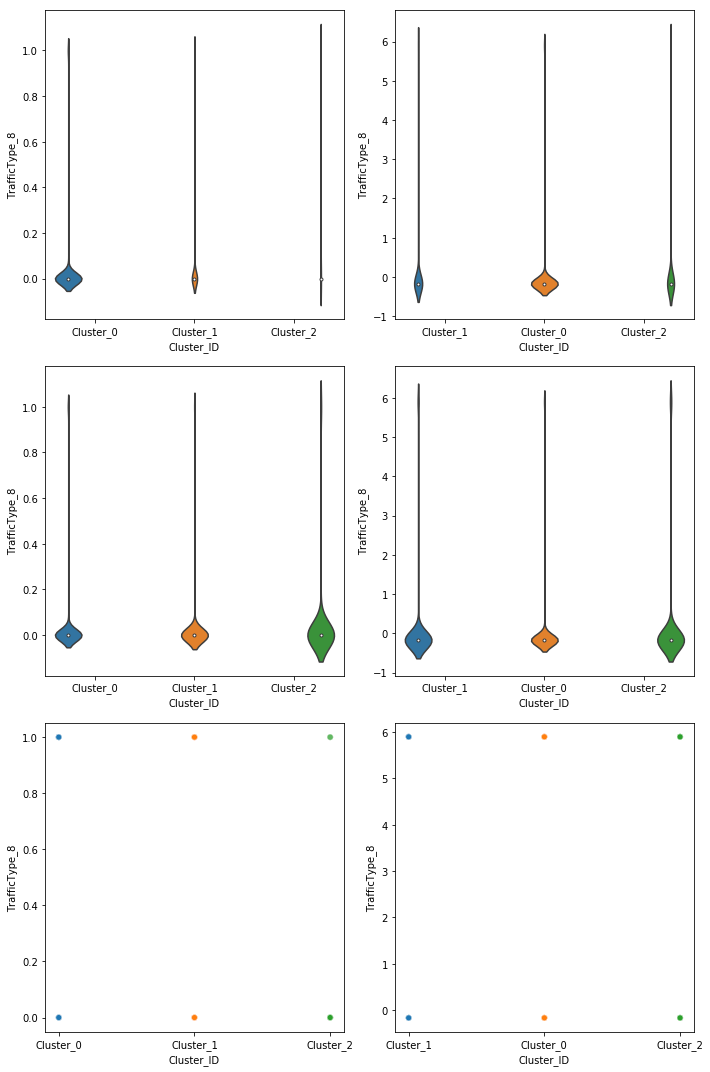

=========================== TrafficType_9 ( uint8 ) ===========================


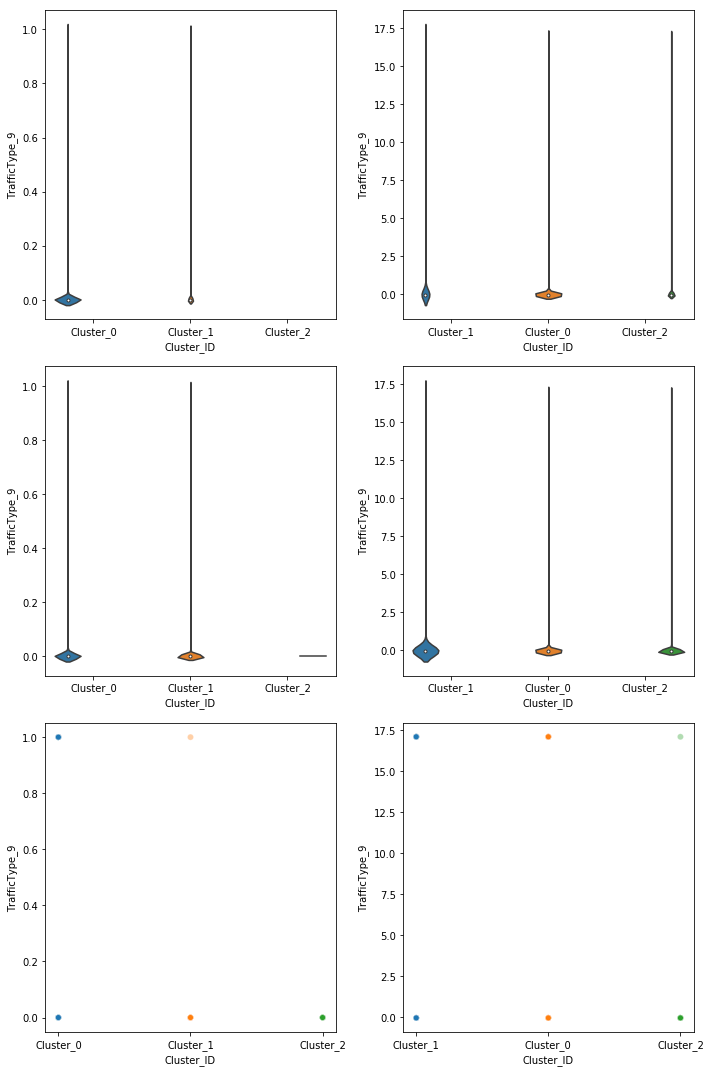

=========================== TrafficType_10 ( uint8 ) ===========================


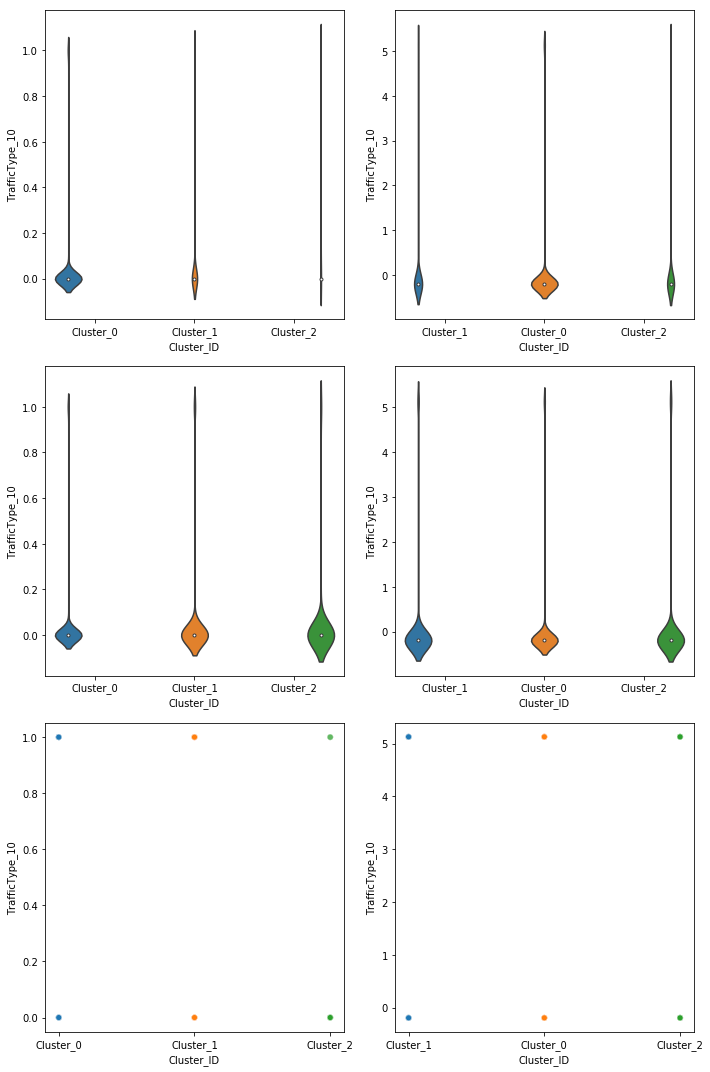

=========================== TrafficType_11 ( uint8 ) ===========================


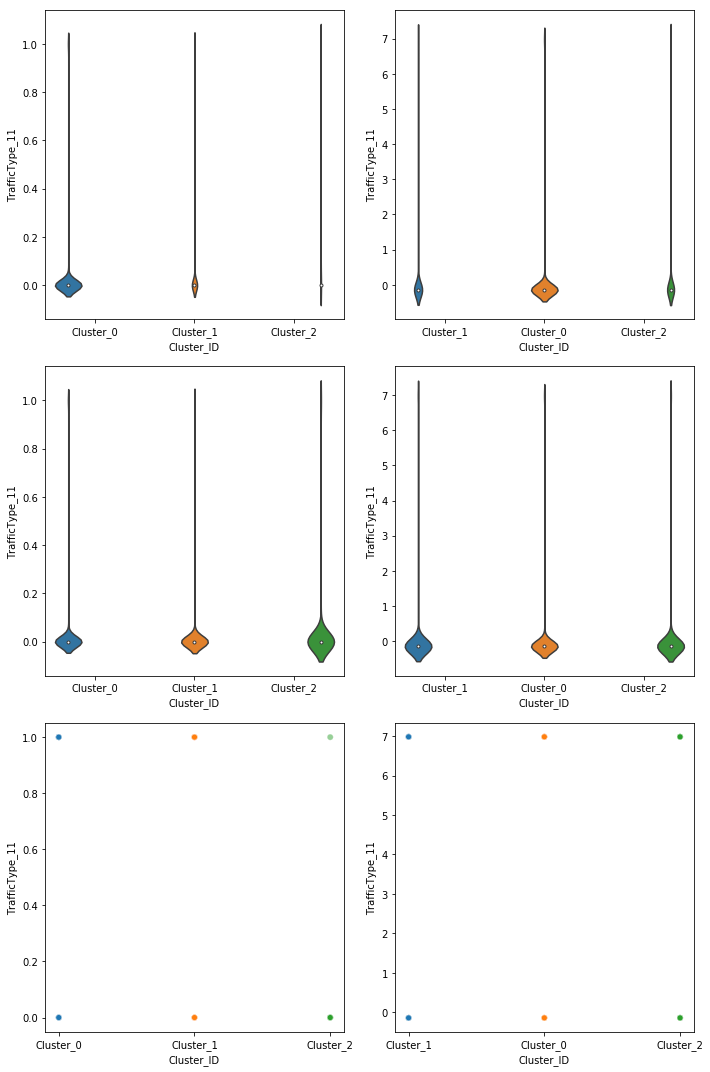

=========================== TrafficType_12 ( uint8 ) ===========================


=========================== TrafficType_13 ( uint8 ) ===========================


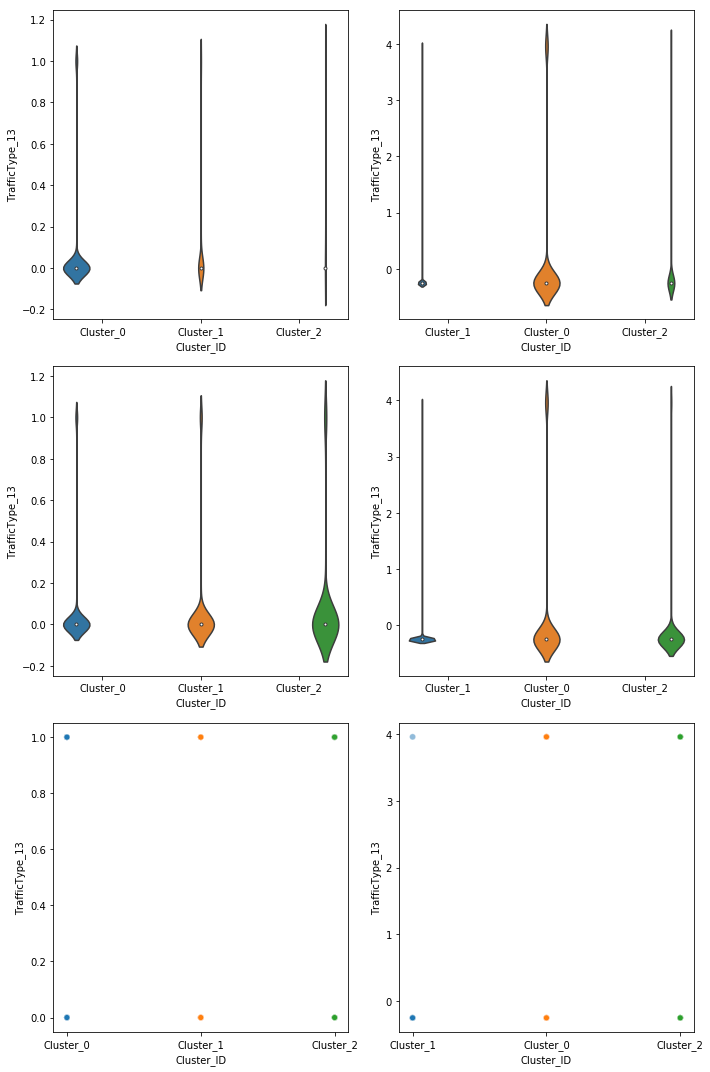

=========================== TrafficType_14 ( uint8 ) ===========================


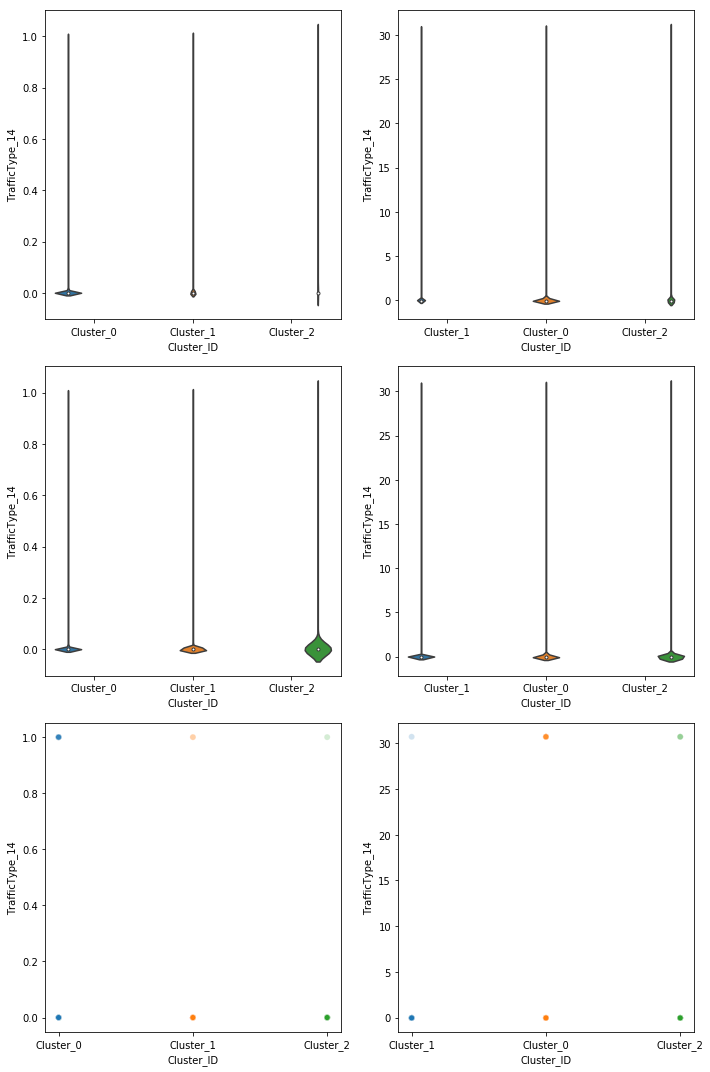

=========================== TrafficType_15 ( uint8 ) ===========================


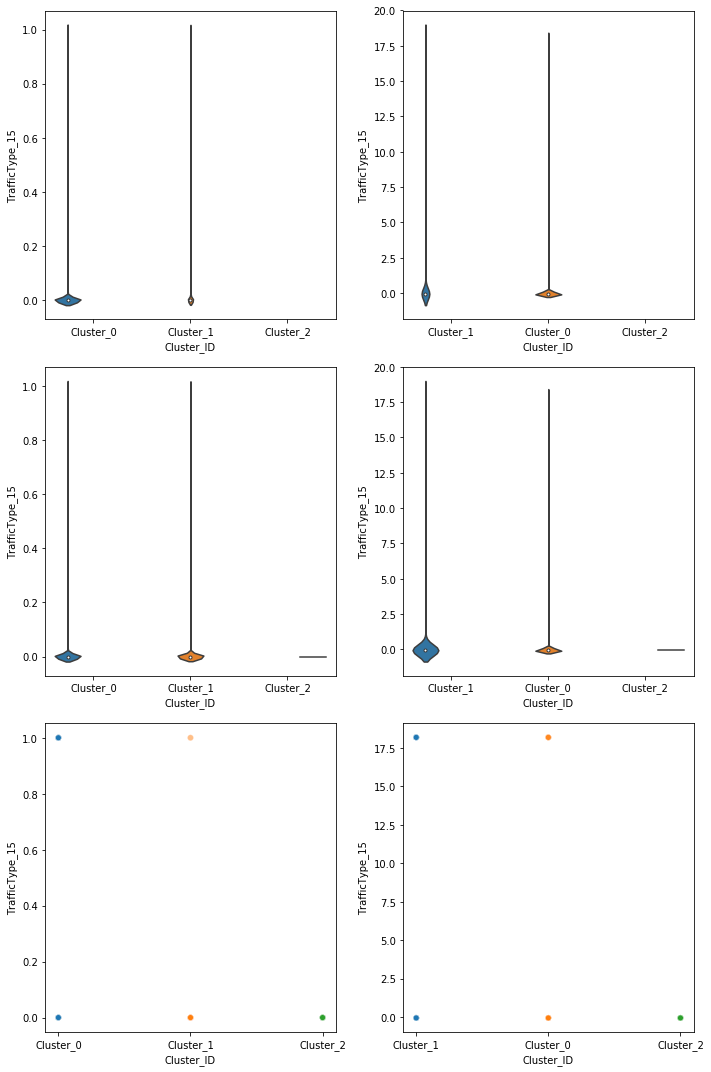

=========================== TrafficType_16 ( uint8 ) ===========================


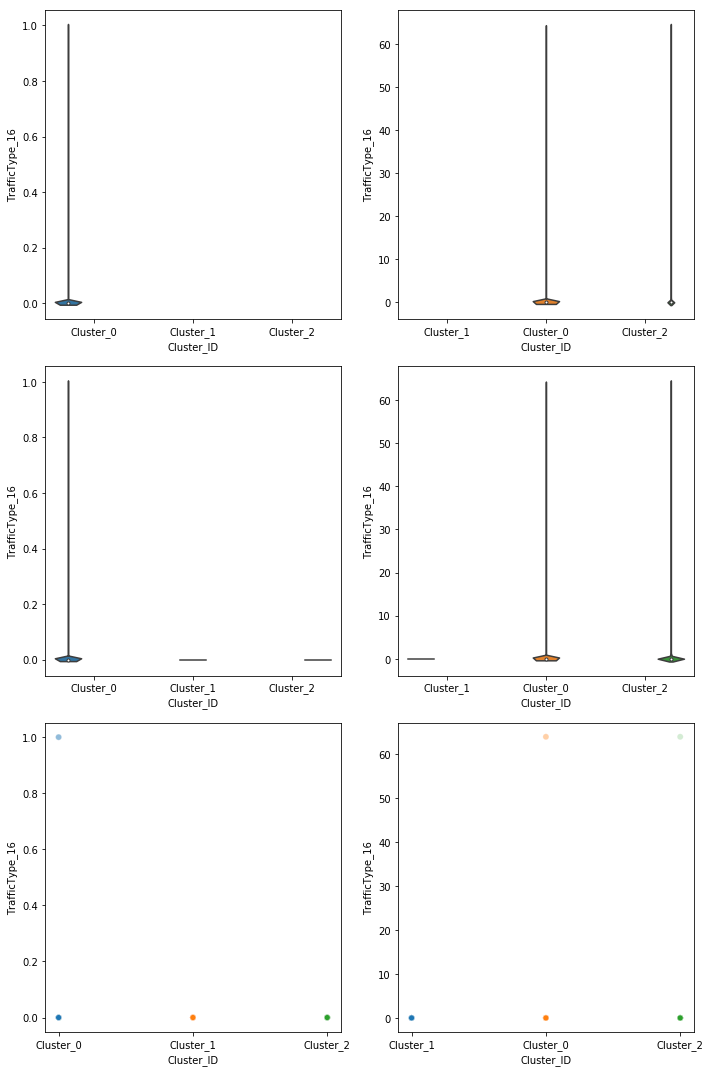

=========================== TrafficType_17 ( uint8 ) ===========================


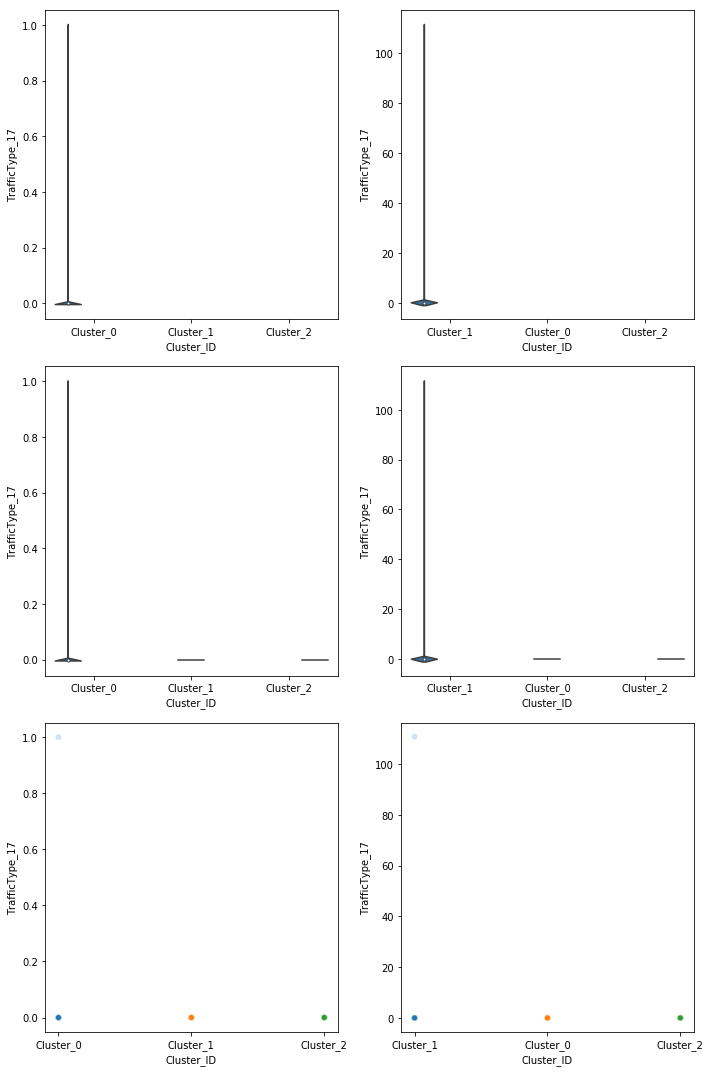

=========================== TrafficType_18 ( uint8 ) ===========================


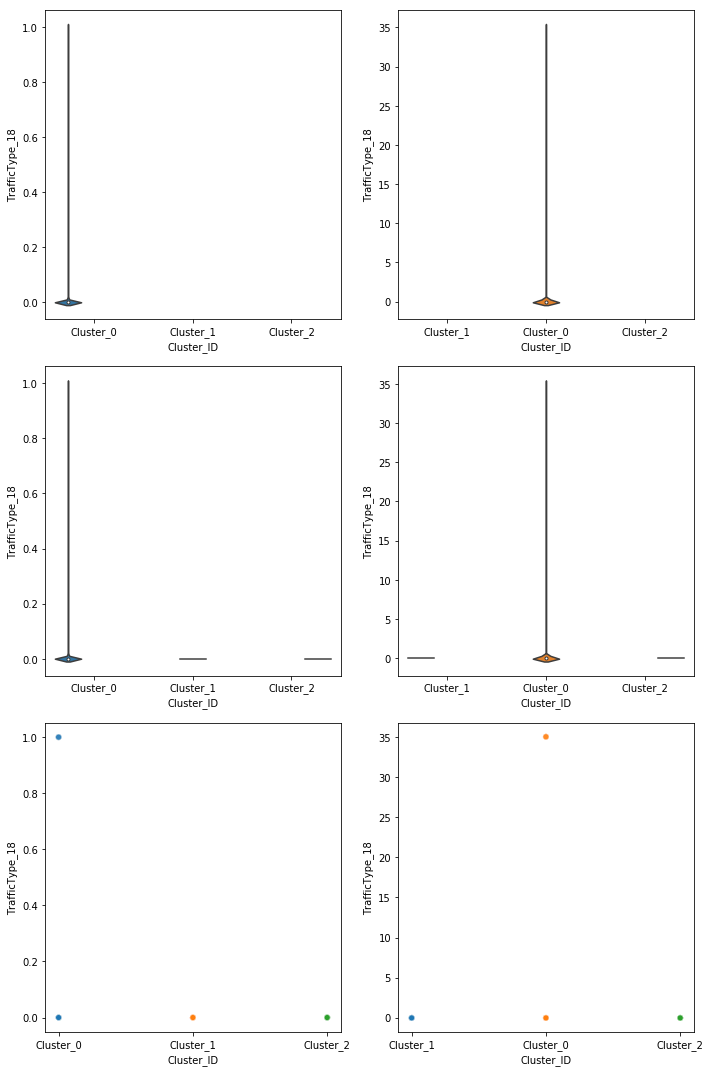

=========================== TrafficType_19 ( uint8 ) ===========================


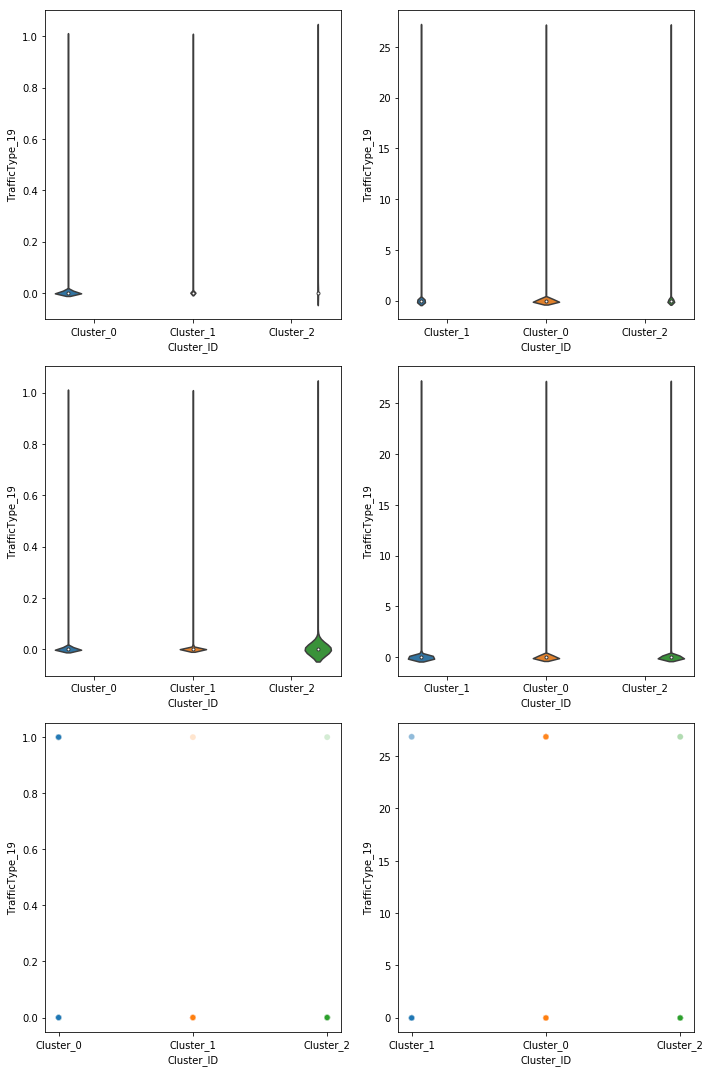

=========================== TrafficType_20 ( uint8 ) ===========================


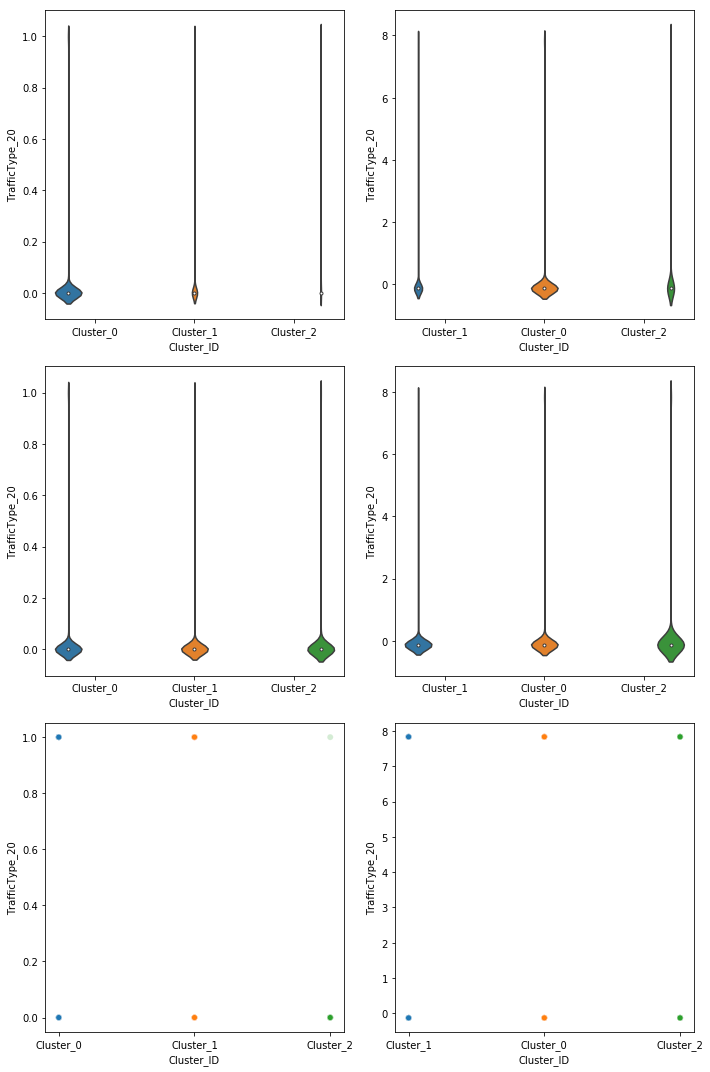

=========================== VisitorType_New_Visitor ( uint8 ) ===========================


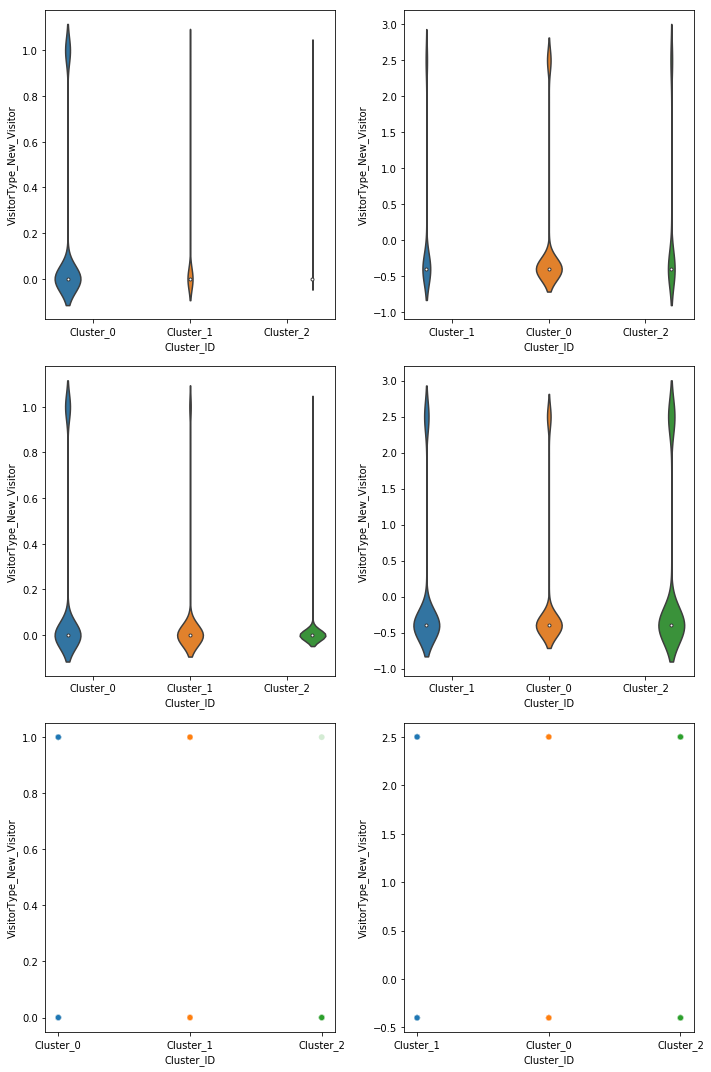

=========================== VisitorType_Other ( uint8 ) ===========================


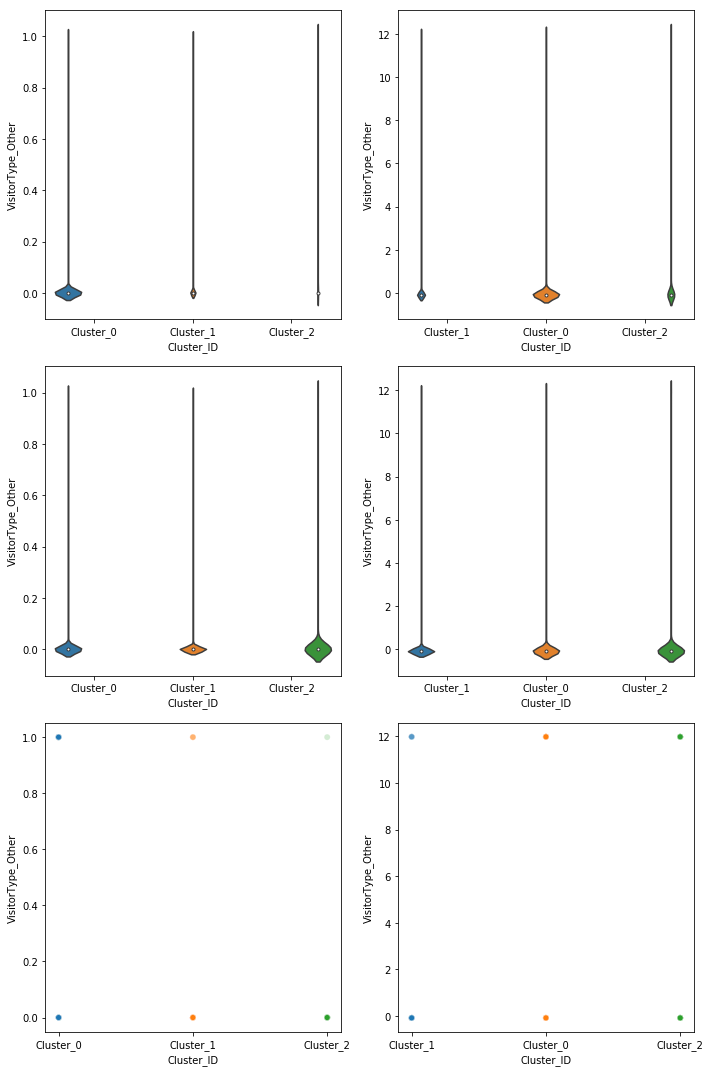

=========================== VisitorType_Returning_Visitor ( uint8 ) ===========================


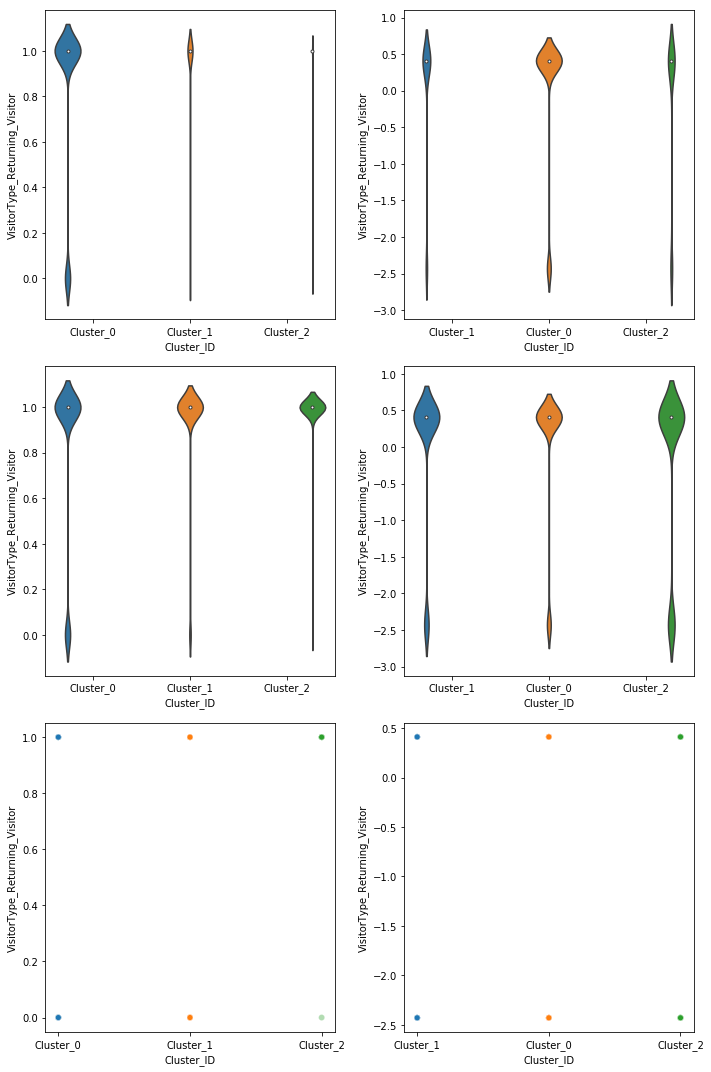

=========================== Weekend_False ( uint8 ) ===========================


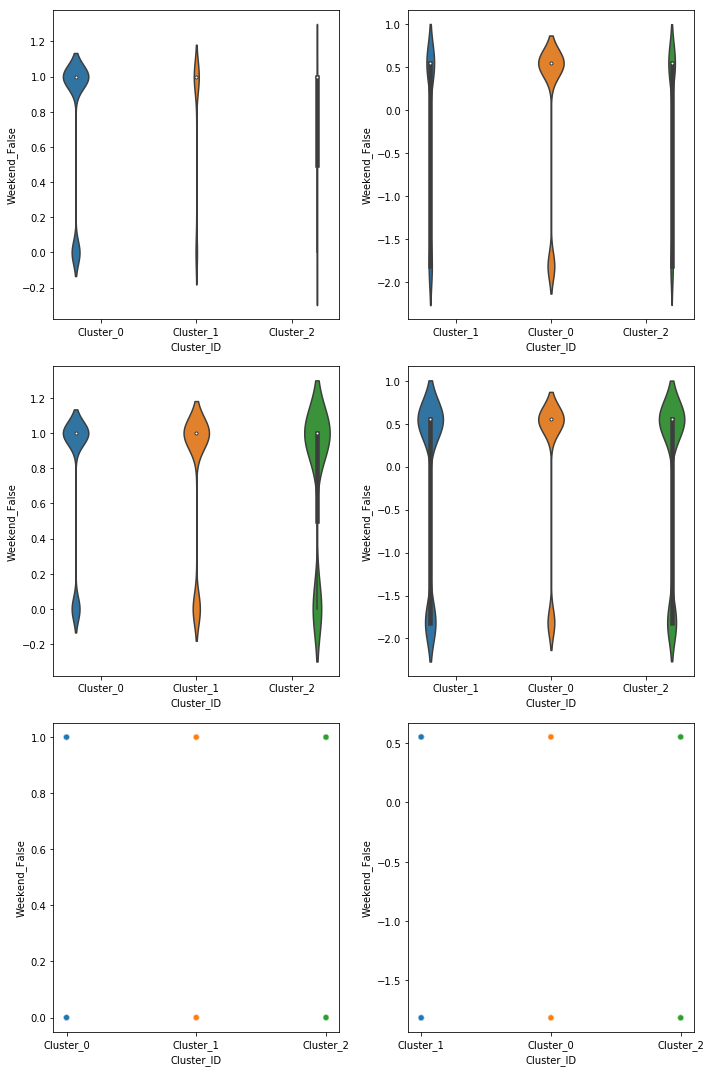

=========================== Weekend_True ( uint8 ) ===========================


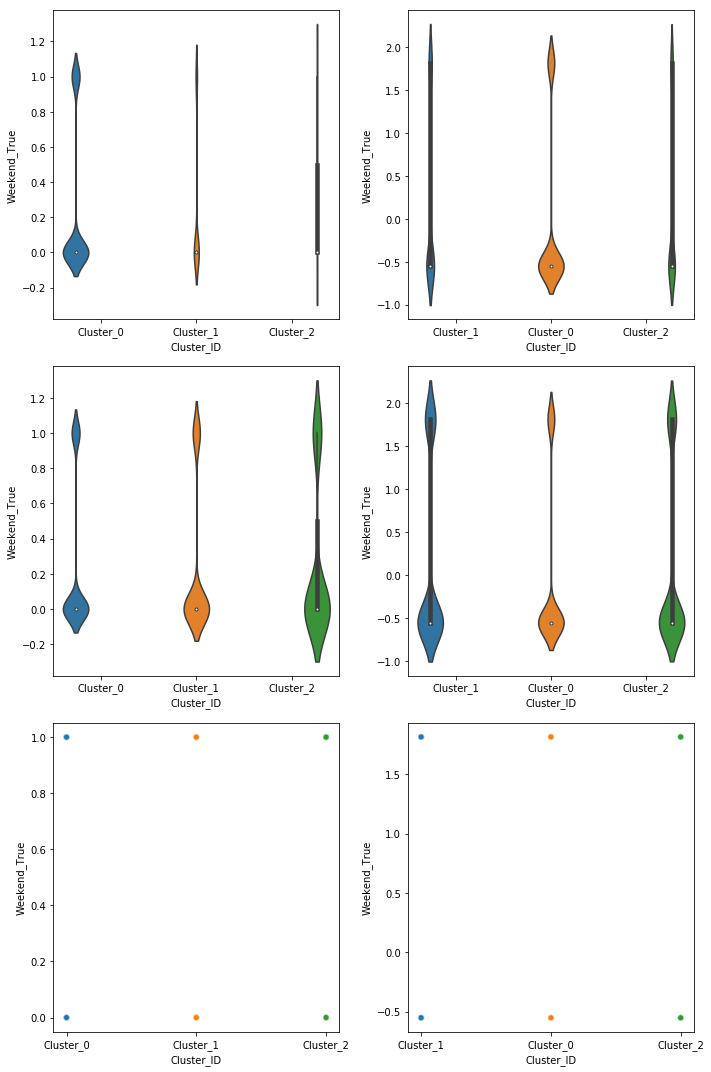

=========================== Revenue_False ( uint8 ) ===========================


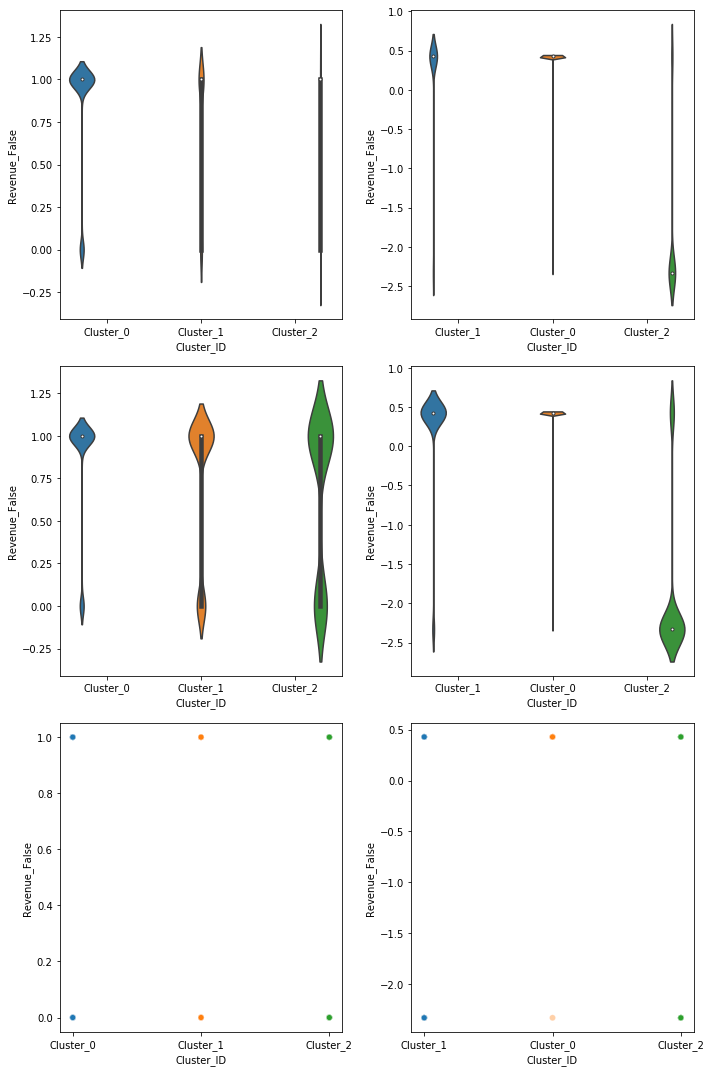

=========================== Revenue_True ( uint8 ) ===========================


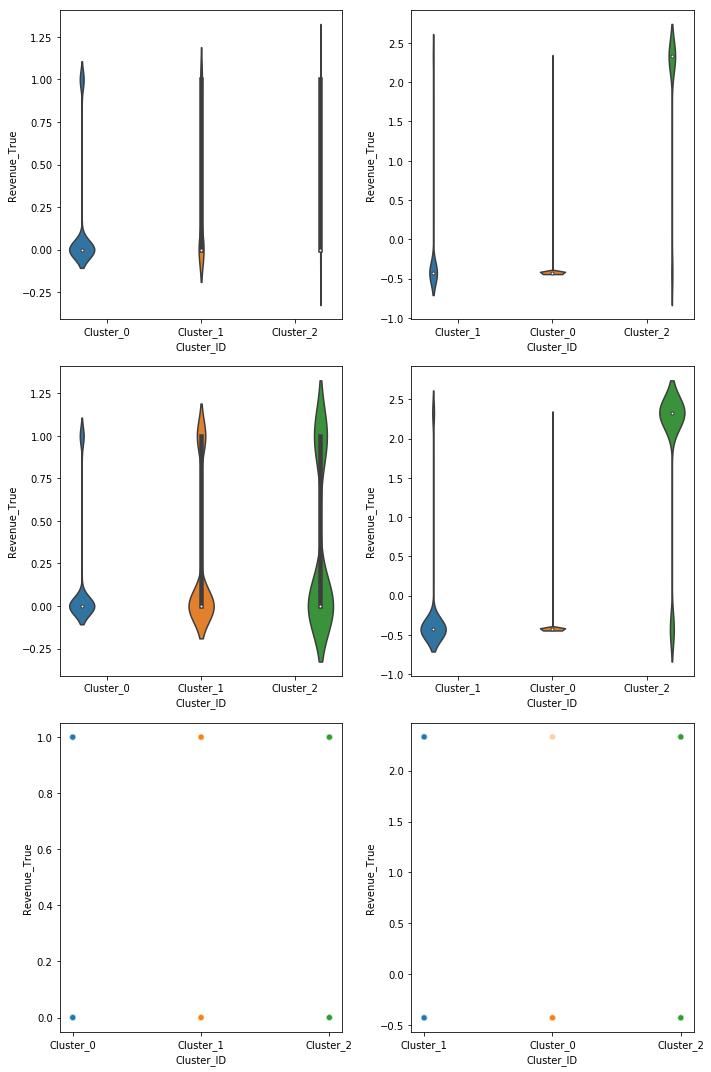

(       Administrative  Administrative_Duration  Informational  \
 0                 0.0                 0.000000            0.0   
 1                 0.0                 0.000000            0.0   
 3                 0.0                 0.000000            0.0   
 4                 0.0                 0.000000            0.0   
 5                 0.0                 0.000000            0.0   
 8                 0.0                 0.000000            0.0   
 9                 0.0                 0.000000            0.0   
 10                0.0                 0.000000            0.0   
 11                0.0                 0.000000            0.0   
 12                0.0                 0.000000            0.0   
 13                0.0                 0.000000            0.0   
 14                0.0                 0.000000            0.0   
 15                2.0                53.000000            0.0   
 17                0.0                 0.000000            0.0   
 18       

In [71]:
CompareVisualization(taskThreeDf, refinedClusters[1], taskThreeDf_Standardised, refinedClusters_Standardised[1], taskThreeDf.columns)

From the above value counts, we can find the standardised model doesn't have a small cluster that less than 1000 instances. And the number of objects in the largest cluster is smaller than the largest cluster in normal model. From the first row of each feature, we can see the largest group Cluster_0. And, the violin shape of Cluster_0 in the original model is similar to the shape of Cluster_0 in the standardised model. Moreover, the shape of Cluster_1 in orginal model is similar to the Cluster_2 in the standardised model. The reason of have a similar shape may be the range of smallest cluster in the orgininal model is extended and include more instances with similar attributes. Therefore, the smallest cluster in the original group become the middle size group in the standardised model. Although the size rank has been changed, the distribution (desity) violin shapes are almost the same.


// TODO: is it a better cluyster result? (balance the number of each cluster)

From the above violin and scatter plots, we can see the Cluster_0 become more compact.


## 3. Can you highlight the differences between the two clustering solutions (Tasks 2.1 & 3.1) focusing on cluster interpretation? In other words, explain what is the effect of adding other variables in the clustering analysis?

In [37]:
sum(df_1_WithID['Cluster_ID'] != df_2_WithID['Cluster_ID'])
# The cluster 1 is the same as cluster 2 

0

The two clustering results don't have the difference. They have the same Cluster_ID, which means adding more features doesn't change the clustering behaviour in this case. After introducing the new features, we found the three duration variables may still be the most important variables, which can help the model to classify the instances.

# Decision Making: Finally, could you detail - how the outcome of clustering analysis can be used by decision makers?

We can use the Revenue feature to find out which characteristics or cluster tend to make a purchasement. Therefore, these clustering models can help the online shops to indentify their target customers. Moreover, the revenue attribute can be removed from the clustering input. Then, we can use the clustering model as a step of feature engineering for a prediction model. For example, we can add a Cluster_ID feature for each instance, then we can introduce the new feature to predict wheather the customer will end with shopping.

# Text Mining

In [38]:
import glob
import string
from nltk.corpus import stopwords as sw
from nltk.corpus import wordnet as wn
from nltk import wordpunct_tokenize
from nltk import WordNetLemmatizer
from nltk import sent_tokenize
from nltk import pos_tag
from sklearn.feature_extraction.text import TfidfVectorizer


path = 'text-files-to-mine/*.txt'
files = glob.glob(path)


allText = []
for name in files:
    with open(name) as f:
        allText.append(f.read()) # .split("\n\n")
        
print('Number of documents: ', len(allText))

Number of documents:  200


In [39]:
lemmatizer = WordNetLemmatizer()
punct = set(string.punctuation)
stopwords = sw.words('english')

def lemmatize(token, tag):
    tag = {
        'N': wn.NOUN,
        'V': wn.VERB,
        'R': wn.ADV,
        'J': wn.ADJ
    }.get(tag[0], wn.NOUN)

    return lemmatizer.lemmatize(token, tag)


def normal_tokenizer(document):
    
    tokens = []
    
    for sent in sent_tokenize(document):
        # split the document into tokens and then create part of speech tag for each token
        for token, tag in pos_tag(wordpunct_tokenize(sent)):
            tokens.append(token)
    
#     return [token for sent in sent_tokenize for token, tag in pos_tag(wordpunct_tokenize(sent))]
    return tokens
        


def cab_tokenizer(document):
    # initialize token list
    tokens = []
    
    # split the document into sentences
    for sent in sent_tokenize(document):
        # split the document into tokens and then create part of speech tag for each token
        for token, tag in pos_tag(wordpunct_tokenize(sent)):
            # preprocess and remove unnecessary characters
            token = token.lower()
            token = token.strip()
            token = token.strip('_')
            token = token.strip('*')

            # If stopword, ignore token and continue
            if token in stopwords:
                continue

            # If punctuation, ignore token and continue
            if all(char in punct for char in token):
                continue

            # Lemmatize the token and add back to the tokens list
            lemma = lemmatize(token, tag)
            tokens.append(lemma)
    
    return tokens



In [40]:
original_vec = TfidfVectorizer(tokenizer= normal_tokenizer, ngram_range=(1,2))
X_original = original_vec.fit_transform(allText)

tfidf_vec = TfidfVectorizer(tokenizer=cab_tokenizer, ngram_range=(1,2))
X = tfidf_vec.fit_transform(allText)

filter_vec = TfidfVectorizer(tokenizer=cab_tokenizer, ngram_range=(1,2), min_df=2, max_df=0.8)
X_filter = filter_vec.fit_transform(allText)

print('Number of unigram and bigram tokens before filtering: ',len(original_vec.get_feature_names()))
print('Number of unigram and bigram tokens before filtering: ',len(tfidf_vec.get_feature_names()))
print('Number of unigram and bigram tokens after filtering: ',len(filter_vec.get_feature_names()))


Number of unigram and bigram tokens before filtering:  47179
Number of unigram and bigram tokens before filtering:  36360
Number of unigram and bigram tokens after filtering:  6914


## 1. What variables did you include in the analysis and what were their roles and measurement level set? Justify your choice.

The input is the tf-idf vetor, which has 36360 dimensions for each document intially. After we plot the Zipf law, we set the parameter "min_df=2, max_df=8", which means we use the terms appearing at least 2 documents and at most 80% * 200 documents. Therefore, we end up with a tf-idf vector with 6914 toknes. Each token is consist of one or two words, which are unigram and bigram. The unigram token can provide the information of sigle word. And the bigram tokens can provide the information of phrses.


## 2. Can you identify data quality issues in order to perform text mining?


If we use the original text as the input, we may include a lot of meaningless features, such as the stopword and puctuations, which means result in a large dimension input. In order to reduce the dimension of the input featues, removing puctuation and stopwords is applied to further reduce the number of input tokens. Moreover, we also apply the lemmatization, which derivationally relates forms of a word to a common base form. Moreover, 

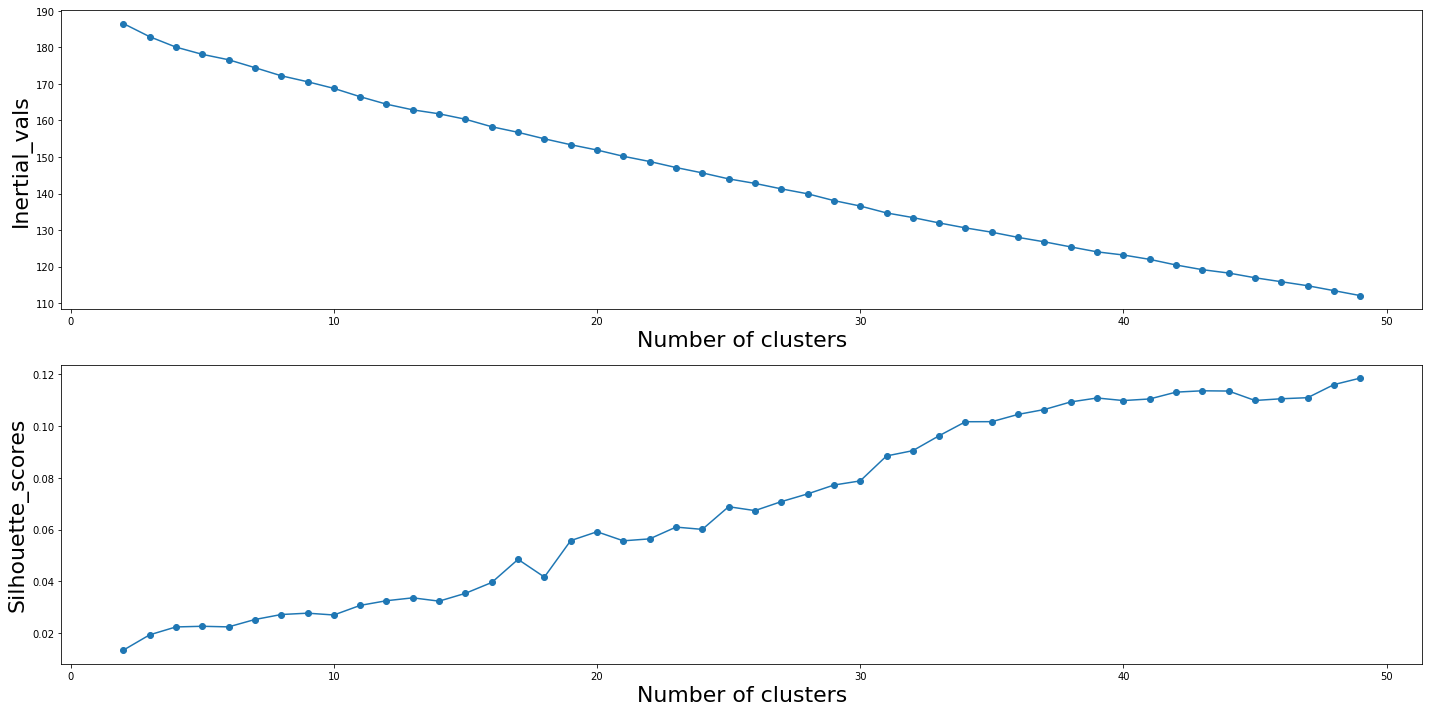

In [41]:
## How to determine the K? (In the tutorial, they use k=7, so I use it as well.)
text_clusters = ElbowEffectAndSilhouetteScore(X_filter, range(2,50))

In [42]:
def visualise_text_cluster(n_clusters, cluster_centers, terms, num_word = 5):
    ordered_centroids = cluster_centers.argsort()[:, ::-1]
    
    for cluster in range(n_clusters):
        print("Top terms for cluster #{}:".format(cluster), end=" ")
        for term_idx in ordered_centroids[cluster, :num_word]:
            print(terms[term_idx], end=', ')
        print()
        
# it we set k=7
visualise_text_cluster(text_clusters[5].n_clusters, text_clusters[5].cluster_centers_, tfidf_vec.get_feature_names())

Top terms for cluster #0: 7 98, betsen doubt, away crucial, chepkemei however, american remain, 
Top terms for cluster #1: behind arsenal, 13 tommy, bouncer first, 2006 time, 14 england, 
Top terms for cluster #2: 22nd world, age batsman, call carroll, circumstance, achieve take, 
Top terms for cluster #3: age batsman, chelsea £, assessment 19, city richard, catch extra, 
Top terms for cluster #4: advantage break, 24 2, anticipate, around world, celestine babayaro, 
Top terms for cluster #5: arsenal semi, body iaaf, clay lose, bedford long, 139 570, 
Top terms for cluster #6: blessing, back time, abysmal performance, beneficial, bloke spinner, 


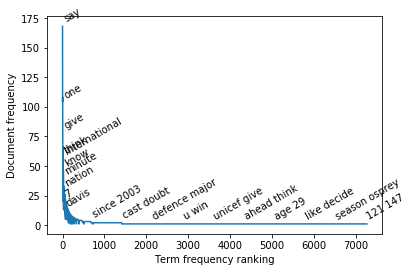

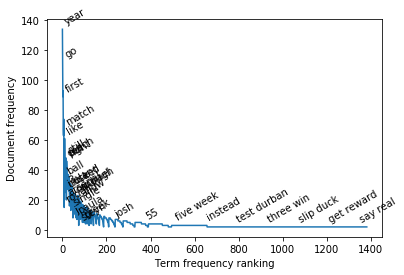

In [43]:
def calculate_tf_idf_terms(document_col, max_df = 1.0, min_df = 1):
    from sklearn.feature_extraction.text import CountVectorizer

    # Filtered Version ,min_df=2, max_df=0.8
    count_vec = CountVectorizer(tokenizer=cab_tokenizer, ngram_range=(1,2), max_df = max_df, min_df = min_df)
    X_count = count_vec.fit_transform(document_col)
    
    terms = [{'term': t, 'idx': count_vec.vocabulary_[t],
              'tf': X_count[:, count_vec.vocabulary_[t]].sum(),
              'df': X_count[:, count_vec.vocabulary_[t]].count_nonzero()}
             for t in count_vec.vocabulary_]
    
    return terms
    
terms = calculate_tf_idf_terms(allText)
filter_terms = calculate_tf_idf_terms(allText, 0.8, 2)

def visualise_zipf(terms, itr_step = 50):
    from scipy.spatial.distance import euclidean
    from math import sqrt
    
    # --- Param ---
    # terms: collection of terms dictionary from calculate_tf_idf_terms function
    # itr_step: used to control how many terms that you want to plot. Num of terms to plot = N terms / itr_step
    
    # sort terms by its frequency
    terms.sort(key=lambda x: (x['tf'], x['df']), reverse=True)
    
    # select a few of the terms for plotting purpose
    sel_terms = [terms[i] for i in range(0, len(terms), itr_step)]
    labels = [term['term'] for term in sel_terms]
    
    # plot term frequency ranking vs its DF
    plt.plot(range(len(sel_terms)), [x['df'] for x in sel_terms])
    plt.xlabel('Term frequency ranking')
    plt.ylabel('Document frequency')
    
    max_x = len(sel_terms)
    max_y = max([x['df'] for x in sel_terms])
    
    # annotate the points
    prev_x, prev_y = 0, 0
    for label, x, y in zip(labels,range(len(sel_terms)), [x['df'] for x in sel_terms]):
        # calculate the relative distance between labels to increase visibility
        x_dist = (abs(x - prev_x) / float(max_x)) ** 2
        y_dist = (abs(y - prev_y) / float(max_y)) ** 2
        scaled_dist = sqrt(x_dist + y_dist)
        
        if (scaled_dist > 0.1):
            plt.text(x+2, y+2, label, {'ha': 'left', 'va': 'bottom'}, rotation=30)
            prev_x, prev_y = x, y
    
    plt.show()
    
visualise_zipf(terms, 5)
visualise_zipf(filter_terms, 5)

## 3. Based on the ZIPF plot, list the top 10 terms that will be least useful for clustering purpose. 

If a token has too high or too low df value, it may not be helpful during clustering. Therefore, we can remove this kind of terms to reduce the dimension and improve the training efficiency. In this dataset, "say" token has the highest docuemnt frequency, which means this terms may present a less information for a certain document. Moreover, the df=1 tokens, doesn't provide any information about the relationship between words. And, these df=1 are the useless features for the clustering purpose. 

In [44]:
filter_terms[-10:] # //TODO: should it be terms or filter_terms?

[{'term': 'every day', 'idx': 2110, 'tf': 2, 'df': 2},
 {'term': '000 people', 'idx': 8, 'tf': 2, 'df': 2},
 {'term': 'give reason', 'idx': 2662, 'tf': 2, 'df': 2},
 {'term': 'world top', 'idx': 6784, 'tf': 2, 'df': 2},
 {'term': 'investment', 'idx': 3177, 'tf': 2, 'df': 2},
 {'term': 'international tennis', 'idx': 3167, 'tf': 2, 'df': 2},
 {'term': 'cheque', 'idx': 1245, 'tf': 2, 'df': 2},
 {'term': 'atp tour', 'idx': 661, 'tf': 2, 'df': 2},
 {'term': 'signal', 'idx': 5526, 'tf': 2, 'df': 2},
 {'term': 'private', 'idx': 4739, 'tf': 2, 'df': 2}]

## 4. Did you disregard any frequent terms in addition to items automatically selected by the Filter tool?

The important terms should only exist in a few documents as the keywords, which means it should has a low document frquency. Moreover, in order to present a document, an important terms should occur in a document fo  r many times. Therefore, we can use the ratio of (tf/df) to check the term importance.

In [45]:
# TODO: Can we use this method to define the useless terms
# TODO: We have to go back to the pre-processing and remove these terms there

for f in filter_terms:
    f['tf/df'] = f['tf']/f['df']
filter_terms.sort(key=lambda x: x['tf/df'], reverse=True)

In [46]:
filter_terms[-10]  

{'term': 'every day', 'idx': 2110, 'tf': 2, 'df': 2, 'tf/df': 1.0}

## 5. Justify the term weighting option selected. 

Three types of weighting can be used, including count, bool and tf-idf. We select the tf-idf to perform the weighting since it can provide more information in this case. If use bool weighting, we may loss the information of the number of occurences. And, the count-based weighting may ignore the relationship between documents. In this clustering task, we need to cosider both the frequency in a document and cross documents. Therefore, the tf-idf will be an appropriate selction.


## 6. What is the number of input features available to execute clustering? (Hint: how the original text data is converted into a feature set that can be mined for knowledge discovery?)

Before the We apply lemmatization, stopwords removal, puctuation removal, we was having 47179 columns for the input. Then, we apply these three strategies to reduce the dimension to 36360. Moreover, we apply zipf law to fidn the the useless tokens and set the argument "min_df=2, max_df=8" to the vectorizer, the number of dimensions has been reduced to 6914. 

In [47]:
print('Number of unigram and bigram tokens before filtering: ',len(original_vec.get_feature_names()))
print('Number of unigram and bigram tokens before filtering: ',len(tfidf_vec.get_feature_names()))
print('Number of unigram and bigram tokens after filtering: ',len(filter_vec.get_feature_names()))


Number of unigram and bigram tokens before filtering:  47179
Number of unigram and bigram tokens before filtering:  36360
Number of unigram and bigram tokens after filtering:  6914


## 7. State how many clusters are generated? Name each cluster meaningfully according to the terms that appear in the clusters?

//TODO: we have to determine the k first


In [ ]:
# And use this function to visualise the important terms

# visualise_text_cluster(text_clusters[5].n_clusters, text_clusters[5].cluster_centers_, tfidf_vec.get_feature_names())

## 8. Identify the first fifteen high frequent terms (that are not stopwords or noise) in the start list?

In [48]:
terms.sort(key=lambda x: (x['tf']), reverse=True) # first rank the tf then df

In [49]:
terms[:15]

[{'term': 'say', 'idx': 27447, 'tf': 447, 'df': 168},
 {'term': 'year', 'idx': 36020, 'tf': 308, 'df': 134},
 {'term': 'game', 'idx': 13304, 'tf': 249, 'df': 106},
 {'term': 'win', 'idx': 35322, 'tf': 246, 'df': 102},
 {'term': 'play', 'idx': 23829, 'tf': 240, 'df': 104},
 {'term': 'one', 'idx': 22447, 'tf': 204, 'df': 104},
 {'term': 'go', 'idx': 14040, 'tf': 203, 'df': 112},
 {'term': 'take', 'idx': 31441, 'tf': 202, 'df': 112},
 {'term': 'england', 'idx': 10579, 'tf': 199, 'df': 52},
 {'term': 'two', 'idx': 33467, 'tf': 197, 'df': 103},
 {'term': 'time', 'idx': 32544, 'tf': 189, 'df': 115},
 {'term': 'first', 'idx': 12301, 'tf': 185, 'df': 89},
 {'term': 'world', 'idx': 35746, 'tf': 180, 'df': 92},
 {'term': 'get', 'idx': 13663, 'tf': 175, 'df': 87},
 {'term': 'player', 'idx': 23996, 'tf': 164, 'df': 82}]

## 9. Describe how these clusters can be useful in the online personalised news story service planned by the news corporation.

These clusters can help the news company to grouping their news automatically. Morever, the company can put two groups of news together when their clusters are closed since they pay provide similar information. Therefore, the reader can find the interesting news efficiently.



